# Mount drive and bucket
Todo: Remove in public version

In [1]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [2]:
import sys
import datetime
import logging

# nblog = open(f"/content/bigdata/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
# print(nblog)
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

#get_ipython().log.handlers[0].stream = nblog
#get_ipython().log.setLevel(logging.INFO)

%autosave 60

Autosaving every 60 seconds


In [3]:
# if COLAB:
#   from google.colab import drive
#   drive.mount('/content/drive')

In [4]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [5]:
# Todo: Check if possible in local docker
# from google.cloud import storage

In [6]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-03-24 18:47:38.720598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 18:47:38.811560: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 18:47:38.845494: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-24 18:47:39.332117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


In [7]:
from tensorflow import keras
# import tensorflow_gcs_config
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten #, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

In [8]:
import os
from os import listdir
from os.path import isfile, join

In [9]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random

In [10]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [11]:
# Set the checkpoint path for saving train progress
if COLAB:
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [12]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    #%cd /content/CryptoCrystalBall/JupyterDocker/notebooks
    %cd /content

In [13]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [14]:
try:
  from transformers import TFRobertaModel, RobertaConfig
except:
  # Important!: Version 4.23 does not work on TPU
  !pip install transformers==4.22

  from transformers import TFRobertaModel, RobertaConfig

In [15]:
# !pip uninstall -y tensorboard-plugin-profile

In [16]:
# # Required to do profiling
# !pip install tensorboard-plugin-profile

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [18]:
# # Get the current directory
# current_dir = os.getcwd()
# current_dir_splitted = current_dir.split(os.sep)

# Todo: is inside /content/CB in local docker
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [19]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [20]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [21]:
# Define the tick data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /content/DemoData


In [22]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /content/Documentation/Images


In [84]:
# Define a global random seed
RANDOM_SEED = 42+1

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [24]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 256

In [25]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 384

In [26]:
# A fixed number of features is used
FEATURES = 160

In [27]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [28]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the train dataset

In [29]:
# Get train file names - Only pick the ones ending with -USDT to prevent
# influence between different currencies
TRAIN_PATH = "/content/dataset/etffancy"

# Get all file names
ALL_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
ALL_FILES = sorted(ALL_FILES)

print(f"The train dataset contains {len(ALL_FILES)} files.")
print(ALL_FILES[:3])

The train dataset contains 1064 files.
['/content/dataset/etffancy/DE0002635265.csv', '/content/dataset/etffancy/DE0002635273.csv', '/content/dataset/etffancy/DE0002635281.csv']


In [30]:
# Split the dataset into train, test (trade algorithm train) and eval (trade algorithm test)
SPLIT_RANDOM_SEED = 666
TRAIN_SET_SIZE = 0.5
TEST_SET_SIZE = 0.25
# EVAL_SET_SIZE: The rest

random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
print(f"train_split_index: {train_split_index}")

test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
print(f"test_split_index: {test_split_index}")

TRAIN_FILES = ALL_FILES[:train_split_index]
TEST_FILES = ALL_FILES[train_split_index:test_split_index]
EVAL_FILES = ALL_FILES[test_split_index:]

train_split_index: 532
test_split_index: 798


---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  
Target values (y-data) from the data generator would not be necessary in this notebook, but since it cannot be switched off, the future direction and its derviation of the price have been chosen in `Y_TYPE_DICT` since they are not expensive to compute. A switch flag will be added in a future release.

In [31]:
# FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)
Y_TYPE_DICT["gain_timespan"] = 28
Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 28,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48}

In [32]:
TARGET_FEATURE_CNT = 256

In [33]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT)
XShape

(384, 256, 256)

In [107]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorSignalsTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y']
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)
        
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [108]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 4)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

<PrefetchDataset element_spec=(TensorSpec(shape=(384, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(384, 4), dtype=tf.float32, name=None))>

---
# Create the neural network

In the example, two Conv1D pyramids are used to extract features at different levels out of the feature and the time dimension.

It is also possible to use different architecures, like LSTM, Conv2D, Attention-Based ones or even NLP-based models. I have already tried many different ones and will publish them into the model zoo.

```
Todo: Create Model Zoo
```

```
Todo: Create Image of netwrok structure
```

In [36]:
# from keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D, UnitNormalization, UpSampling1D
from keras.layers import UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention, Dropout

In [37]:
# Create the FPNWithFScaledInput model
# Infos about the feature pyramid: https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c

def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttentionBigger",
      "VERSION": "1",
      "CNN_INITIAL_FILTERS": 64,
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 64,
      "HEAD_DENSE_SIZE": 32
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, TARGET_FEATURE_CNT), name='inputTicksAndIndicators', dtype='float32')
  inputTicksAndIndicators = Dropout(0.1, name='inputDropout')(inputTicksAndIndicators)

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # Permute it to Conv over Features
  normalized = Permute((2, 1), name="PermuteInput")(normalized)

  # ----------------------------------------------------------------------------

  # As an example a 1D-CNN pyramid is used to extract higher-level features out
  # of the indicator+tick dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_1")(source_layer)
    
    res_net_element = Activation("relu",
                              name=f"ResNet_{i}_ReLU")(res_net_element)
    
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_2")(res_net_element)
    
    res_net_element = Add(name=f"ResNet_{i}_Add")([res_net_element, source_layer])
        
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"ResNet_{i}_Feature_Conv1D_FilterDimReduction")(res_net_element)

    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(4, activation="tanh", name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 128, 64)
feature_conv_attentioned.shape: (None, 128, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 64, 128)
feature_conv_attentioned.shape: (None, 64, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 32, 256)
feature_conv_attentioned.shape: (None, 32, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 512)
feature_conv_attentioned.shape: (None, 16, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 1024)
feature_conv_attentioned.shape: (None, 8, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 2048)
feature_conv_attentioned.shape: (None, 4, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 4, 256)
Building feat

# Train the model

### Train strategy in the paper
https://huggingface.co/roberta-base

The model was trained on 1024 V100 GPUs for 500K steps with a batch size of 8K and a sequence length of 512. The optimizer used is Adam with a learning rate of 6e-4, β1=0.9\beta_{1} = 0.9β1​=0.9, β2=0.98\beta_{2} = 0.98β2​=0.98 and ϵ=1e−6\epsilon = 1e-6ϵ=1e−6, a weight decay of 0.01, learning rate warmup for 24,000 steps and linear decay of the learning rate after.

In [38]:
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttentionBigger_1_GPU_256LB'

In [39]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-04,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [40]:
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = ["mse"], 
    metrics=["mae"])

In [41]:
#@title CustomCallback
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

      fp = os.path.join(_save_folder, "c.pickle")
      with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
      logging.info(f"Saved optimizer config to '{fp}'")

      # Save optimizer weights
      # w = copy.deepcopy(self.model.optimizer.get_weights())

      fp = os.path.join(_save_folder, "w.pickle")
      with open(fp, "wb") as handle:
        # with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
      logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [42]:
gc.collect()

9885

In [80]:
epoch_add = 31

In [44]:
CALLBACK_EVERY_N_BATCHES = 2000

In [81]:
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [46]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [47]:
%reload_ext tensorboard

The TensorBoard UI is displayed in a browser window. In this colab, perform the following steps to prepare to capture profile information.
1.  Click on the dropdown menu box on the top right side and scroll down and click PROFILE. A new window appears that shows: **No profile data was found** at the top.
1.  Click on the CAPTURE PROFILE button. A new dialog appears. The top input line shows: **Profile Service URL or TPU name**. Copy and paste the Profile Service URL (the service_addr value shown before launching TensorBoard) into the top input line. While still on the dialog box, start the training with the next step.
1.  Click on the next colab cell to start training the model.
1.  Watch the output from the training until several epochs have completed. This allows time for the profile data to start being collected. Return to the dialog box and click on the CAPTURE button. If the capture succeeds, the page will auto refresh and redirect you to the profiling results.

In [48]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/bigdata/log",log_dir.split("/")[-1])

log_dir

'/content/bigdata/log/FPNWithAttentionBigger_1_GPU_256LB20230324-184744'

In [49]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-03-24 18:47:44.077061: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-24 18:47:44.077082: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-24 18:47:44.077112: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-03-24 18:47:44.077422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-03-24 18:47:44.170582: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-24 18:47:44.170819: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [50]:
# model.load_weights("/content/bigdata/chk/FPNWithAttention_6_ETF_Trained_PastFutureGainSignals_TrainSetOnly_GPU_256LB/cp_daily_valid_21_end/model.h5")

In [51]:
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

In [52]:
# model.fit(tfGenTraining,
#           epochs=1,
#           verbose = 1,
#           callbacks=[tensorboard_callback, cc])

In [82]:
model.optimizer.learning_rate = 5e-6

In [83]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5e-06>

In [128]:
model.fit(tfGenTraining,
          epochs=3,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

Epoch 1/3


INFO:root:File 'IE00B5377D42.csv' loaded, 531 left
INFO:root:File 'LU1681040223.csv' loaded, 530 left
INFO:root:File 'LU1681040819.csv' loaded, 529 left
INFO:root:File 'DE0002635273.csv' loaded, 528 left
INFO:root:File 'LU1686830909.csv' loaded, 527 left
INFO:root:File 'LU1681049109.csv' loaded, 526 left
INFO:root:File 'LU2356220926.csv' loaded, 525 left
INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 524 left


      4/Unknown - 13s 288ms/step - loss: 6.0866e-04 - mae: 0.0198

2023-03-25 08:43:10.415382: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-25 08:43:10.415415: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


      6/Unknown - 14s 308ms/step - loss: 6.2571e-04 - mae: 0.0200WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1461s vs `on_train_batch_end` time: 0.1526s). Check your callbacks.


INFO:root:File 'IE00BD1F4L37.csv' loaded, 523 left


     19/Unknown - 18s 344ms/step - loss: 6.5129e-04 - mae: 0.0201

INFO:root:File 'IE00BYSX4739.csv' loaded, 522 left


     38/Unknown - 25s 333ms/step - loss: 6.2717e-04 - mae: 0.0198

INFO:root:File 'IE00B4L5YC18.csv' loaded, 521 left


     40/Unknown - 27s 376ms/step - loss: 6.2225e-04 - mae: 0.0197

INFO:root:File 'LU1079842321.csv' loaded, 520 left


     49/Unknown - 31s 384ms/step - loss: 6.2514e-04 - mae: 0.0199

INFO:root:File 'IE00B459R192.csv' loaded, 519 left


     86/Unknown - 42s 355ms/step - loss: 6.4240e-04 - mae: 0.0200

INFO:root:File 'IE00B53HP851.csv' loaded, 518 left


     90/Unknown - 45s 372ms/step - loss: 6.3519e-04 - mae: 0.0199

INFO:root:File 'LU1834986900.csv' loaded, 517 left


     93/Unknown - 48s 391ms/step - loss: 6.3410e-04 - mae: 0.0199

INFO:root:File 'IE000UQND7H4.csv' loaded, 516 left


     94/Unknown - 49s 390ms/step - loss: 6.3438e-04 - mae: 0.0199

INFO:root:File 'IE00BKX55S42.csv' loaded, 515 left


     95/Unknown - 51s 408ms/step - loss: 6.3674e-04 - mae: 0.0200

INFO:root:File 'LU2198883410.csv' loaded, 514 left


     96/Unknown - 51s 411ms/step - loss: 6.4084e-04 - mae: 0.0200

INFO:root:File 'LU1900066975.csv' loaded, 513 left


     99/Unknown - 54s 431ms/step - loss: 6.4468e-04 - mae: 0.0201

2023-03-25 08:43:52.088916: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-25 08:43:52.093225: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-03-25 08:43:52.443883: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 585793 callback api events and 588498 activity events. 
INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left
2023-03-25 08:43:57.372324: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-25 08:44:02.724643: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /content/bigdata/log/FPNWithAttentionBigger_1_GPU_256LB20230324-184744/plugins/profile/2023_03_25_08_43_57

INFO:root:File 'IE00BMH5YF48.csv' loaded, 511 left
2023-03-25 08:44:06.646930: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /content/bigdata/log/FPNWith

    102/Unknown - 74s 610ms/step - loss: 6.4459e-04 - mae: 0.0201

INFO:root:File 'DE0005933956.csv' loaded, 510 left


    104/Unknown - 77s 626ms/step - loss: 6.4285e-04 - mae: 0.0201

INFO:root:File 'DE0005933923.csv' loaded, 509 left


    106/Unknown - 78s 628ms/step - loss: 6.4403e-04 - mae: 0.0201

INFO:root:File 'IE000QUOSE01.csv' loaded, 508 left


    107/Unknown - 80s 638ms/step - loss: 6.4420e-04 - mae: 0.0202

INFO:root:File 'IE00BM8R0N95.csv' loaded, 507 left


    109/Unknown - 81s 637ms/step - loss: 6.4564e-04 - mae: 0.0202

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 506 left


    114/Unknown - 83s 628ms/step - loss: 6.4056e-04 - mae: 0.0201

INFO:root:File 'DE000A0Q4R69.csv' loaded, 505 left


    123/Unknown - 86s 604ms/step - loss: 6.7441e-04 - mae: 0.0202

INFO:root:File 'IE00BDDRF478.csv' loaded, 504 left


    128/Unknown - 88s 597ms/step - loss: 6.7341e-04 - mae: 0.0202

INFO:root:File 'FR0010869578.csv' loaded, 503 left


    153/Unknown - 96s 553ms/step - loss: 6.7141e-04 - mae: 0.0203

INFO:root:File 'LU1812090543.csv' loaded, 502 left


    156/Unknown - 98s 555ms/step - loss: 6.7050e-04 - mae: 0.0203

INFO:root:File 'LU1650492256.csv' loaded, 501 left


    161/Unknown - 101s 554ms/step - loss: 6.7424e-04 - mae: 0.0203

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 500 left


    194/Unknown - 111s 510ms/step - loss: 6.7820e-04 - mae: 0.0204

INFO:root:File 'IE00BNDS1P30.csv' loaded, 499 left


    201/Unknown - 113s 504ms/step - loss: 6.7578e-04 - mae: 0.0203

INFO:root:File 'IE00BLF7VW10.csv' loaded, 498 left


    203/Unknown - 114s 504ms/step - loss: 6.7475e-04 - mae: 0.0203

INFO:root:File 'IE00BD4TXV59.csv' loaded, 497 left


    216/Unknown - 118s 492ms/step - loss: 6.8619e-04 - mae: 0.0205

INFO:root:File 'LU1681044647.csv' loaded, 496 left


    227/Unknown - 123s 488ms/step - loss: 6.9126e-04 - mae: 0.0205

INFO:root:File 'LU0959210278.csv' loaded, 495 left


    231/Unknown - 125s 489ms/step - loss: 6.9149e-04 - mae: 0.0205

INFO:root:File 'DE000A0F5UH1.csv' loaded, 494 left


    235/Unknown - 127s 492ms/step - loss: 6.9258e-04 - mae: 0.0205

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 493 left


    241/Unknown - 130s 492ms/step - loss: 6.9509e-04 - mae: 0.0205

INFO:root:File 'LU1407888053.csv' loaded, 492 left


    254/Unknown - 135s 485ms/step - loss: 6.9819e-04 - mae: 0.0206

INFO:root:File 'LU1829218822.csv' loaded, 491 left


    291/Unknown - 146s 462ms/step - loss: 6.9581e-04 - mae: 0.0206

INFO:root:File 'IE00BMYDM794.csv' loaded, 490 left


    292/Unknown - 147s 463ms/step - loss: 6.9535e-04 - mae: 0.0206

INFO:root:File 'IE00B87RLX93.csv' loaded, 489 left


    294/Unknown - 149s 465ms/step - loss: 6.9454e-04 - mae: 0.0205

INFO:root:File 'IE000QNJAOX1.csv' loaded, 488 left


    295/Unknown - 149s 465ms/step - loss: 6.9506e-04 - mae: 0.0205

INFO:root:File 'IE00BJQRDM08.csv' loaded, 487 left


    305/Unknown - 152s 461ms/step - loss: 6.9920e-04 - mae: 0.0206

INFO:root:File 'DE000A0Q4R02.csv' loaded, 486 left


    306/Unknown - 153s 461ms/step - loss: 6.9870e-04 - mae: 0.0206

INFO:root:File 'IE00BWTNM966.csv' loaded, 485 left


    318/Unknown - 160s 465ms/step - loss: 6.9702e-04 - mae: 0.0206

INFO:root:File 'LU1681045537.csv' loaded, 484 left


    333/Unknown - 166s 462ms/step - loss: 6.9387e-04 - mae: 0.0206

INFO:root:File 'IE00B4WXJG34.csv' loaded, 483 left


    334/Unknown - 166s 461ms/step - loss: 6.9360e-04 - mae: 0.0206

INFO:root:File 'IE00BYM31M36.csv' loaded, 482 left


    338/Unknown - 170s 468ms/step - loss: 6.9513e-04 - mae: 0.0206

INFO:root:File 'IE00BFXR5W90.csv' loaded, 481 left


    352/Unknown - 175s 463ms/step - loss: 7.0003e-04 - mae: 0.0206

INFO:root:File 'IE00BFNM3B99.csv' loaded, 480 left


    357/Unknown - 177s 463ms/step - loss: 7.0043e-04 - mae: 0.0206

INFO:root:File 'IE0031442068.csv' loaded, 479 left


    364/Unknown - 182s 467ms/step - loss: 7.0574e-04 - mae: 0.0207

INFO:root:File 'IE00B4L5Y983.csv' loaded, 478 left


    365/Unknown - 182s 466ms/step - loss: 7.0555e-04 - mae: 0.0207

INFO:root:File 'LU0136240974.csv' loaded, 477 left


    379/Unknown - 190s 471ms/step - loss: 7.0324e-04 - mae: 0.0207

INFO:root:File 'IE00B7KMNP07.csv' loaded, 476 left


    380/Unknown - 191s 471ms/step - loss: 7.0272e-04 - mae: 0.0206

INFO:root:File 'DE0002635307.csv' loaded, 475 left


    417/Unknown - 205s 463ms/step - loss: 6.9514e-04 - mae: 0.0206

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 474 left


    433/Unknown - 211s 461ms/step - loss: 6.9451e-04 - mae: 0.0206

INFO:root:File 'IE00B1TXHL60.csv' loaded, 473 left


    452/Unknown - 219s 458ms/step - loss: 6.9166e-04 - mae: 0.0205

INFO:root:File 'DE000ETFL441.csv' loaded, 472 left


    457/Unknown - 221s 459ms/step - loss: 6.8985e-04 - mae: 0.0205

INFO:root:File 'LU1287023342.csv' loaded, 471 left


    461/Unknown - 224s 461ms/step - loss: 6.8939e-04 - mae: 0.0205

INFO:root:File 'IE00BCRY6003.csv' loaded, 470 left


    511/Unknown - 240s 446ms/step - loss: 6.8585e-04 - mae: 0.0204

INFO:root:File 'IE00BZ048462.csv' loaded, 469 left


    514/Unknown - 242s 447ms/step - loss: 6.8648e-04 - mae: 0.0204

INFO:root:File 'IE00BD3V0B10.csv' loaded, 468 left


    520/Unknown - 244s 447ms/step - loss: 6.8661e-04 - mae: 0.0204

INFO:root:File 'DE0002635299.csv' loaded, 467 left


    522/Unknown - 247s 451ms/step - loss: 6.8649e-04 - mae: 0.0204

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 466 left


    523/Unknown - 248s 452ms/step - loss: 6.8604e-04 - mae: 0.0204

INFO:root:File 'IE00B1FZS806.csv' loaded, 465 left


    527/Unknown - 252s 456ms/step - loss: 6.8563e-04 - mae: 0.0204

INFO:root:File 'IE00BKVL7D31.csv' loaded, 464 left


    543/Unknown - 257s 452ms/step - loss: 6.8477e-04 - mae: 0.0204

INFO:root:File 'IE00BYTRR970.csv' loaded, 463 left


    545/Unknown - 259s 453ms/step - loss: 6.8519e-04 - mae: 0.0204

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 462 left


    549/Unknown - 261s 454ms/step - loss: 6.8526e-04 - mae: 0.0204

INFO:root:File 'IE00BG8BCY43.csv' loaded, 461 left


    550/Unknown - 262s 455ms/step - loss: 6.8590e-04 - mae: 0.0204

INFO:root:File 'IE00BQT3WG13.csv' loaded, 460 left


    556/Unknown - 265s 456ms/step - loss: 6.8678e-04 - mae: 0.0205

INFO:root:File 'FR0011475078.csv' loaded, 459 left


    573/Unknown - 271s 453ms/step - loss: 6.8599e-04 - mae: 0.0205

INFO:root:File 'IE00B23D8S39.csv' loaded, 458 left


    580/Unknown - 275s 454ms/step - loss: 6.8550e-04 - mae: 0.0205

INFO:root:File 'IE00BYV1YH46.csv' loaded, 457 left


    590/Unknown - 279s 453ms/step - loss: 6.8248e-04 - mae: 0.0204

INFO:root:File 'LU2082997516.csv' loaded, 456 left


    595/Unknown - 281s 453ms/step - loss: 6.8198e-04 - mae: 0.0204

INFO:root:File 'IE0032077012.csv' loaded, 455 left


    604/Unknown - 286s 454ms/step - loss: 6.8134e-04 - mae: 0.0204

INFO:root:File 'LU2197908721.csv' loaded, 454 left


    605/Unknown - 287s 455ms/step - loss: 6.8124e-04 - mae: 0.0204

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 453 left


    612/Unknown - 290s 454ms/step - loss: 6.8120e-04 - mae: 0.0204

INFO:root:File 'IE00BFNM3N12.csv' loaded, 452 left


    615/Unknown - 292s 455ms/step - loss: 6.8087e-04 - mae: 0.0204

INFO:root:File 'IE00B23D9570.csv' loaded, 451 left


    618/Unknown - 294s 457ms/step - loss: 6.7979e-04 - mae: 0.0204

INFO:root:File 'IE00B5MJYC95.csv' loaded, 450 left


    626/Unknown - 298s 458ms/step - loss: 6.7976e-04 - mae: 0.0204

INFO:root:File 'LU2082997359.csv' loaded, 449 left


    639/Unknown - 303s 455ms/step - loss: 6.8167e-04 - mae: 0.0204

INFO:root:File 'DE000ETF7029.csv' loaded, 448 left


    640/Unknown - 304s 456ms/step - loss: 6.8178e-04 - mae: 0.0204

INFO:root:File 'LU0603942888.csv' loaded, 447 left


    641/Unknown - 305s 458ms/step - loss: 6.8155e-04 - mae: 0.0204

INFO:root:File 'IE00BYXPXL17.csv' loaded, 446 left


    650/Unknown - 309s 458ms/step - loss: 6.8172e-04 - mae: 0.0204

INFO:root:File 'IE0004U3TX15.csv' loaded, 445 left


    651/Unknown - 310s 458ms/step - loss: 6.8137e-04 - mae: 0.0204

INFO:root:File 'DE000ETFL482.csv' loaded, 444 left


    672/Unknown - 317s 455ms/step - loss: 6.7958e-04 - mae: 0.0204

INFO:root:File 'IE0001VXZTV7.csv' loaded, 443 left


    673/Unknown - 318s 455ms/step - loss: 6.7940e-04 - mae: 0.0204

INFO:root:File 'DE0006289473.csv' loaded, 442 left


    679/Unknown - 322s 457ms/step - loss: 6.7811e-04 - mae: 0.0204

INFO:root:File 'LU0480132876.csv' loaded, 441 left


    684/Unknown - 325s 458ms/step - loss: 6.7767e-04 - mae: 0.0204

INFO:root:File 'IE00B4K6B022.csv' loaded, 440 left


    701/Unknown - 332s 457ms/step - loss: 6.7676e-04 - mae: 0.0204

INFO:root:File 'DE000A0Q4R85.csv' loaded, 439 left


    709/Unknown - 335s 456ms/step - loss: 6.7974e-04 - mae: 0.0204

INFO:root:File 'LU1681047236.csv' loaded, 438 left


    716/Unknown - 339s 457ms/step - loss: 6.7859e-04 - mae: 0.0204

INFO:root:File 'IE00B466KX20.csv' loaded, 437 left


    724/Unknown - 343s 457ms/step - loss: 6.7732e-04 - mae: 0.0203

INFO:root:File 'IE00BYV1Y969.csv' loaded, 436 left


    729/Unknown - 345s 457ms/step - loss: 6.7744e-04 - mae: 0.0203

INFO:root:File 'IE00BJXRZ273.csv' loaded in retry loop, 435 left


    744/Unknown - 350s 455ms/step - loss: 6.7774e-04 - mae: 0.0203

INFO:root:File 'IE00BK5BC677.csv' loaded, 434 left


    746/Unknown - 352s 456ms/step - loss: 6.7745e-04 - mae: 0.0203

INFO:root:File 'IE00BZ0G8860.csv' loaded, 433 left


    759/Unknown - 356s 454ms/step - loss: 6.7566e-04 - mae: 0.0203

INFO:root:File 'LU0908501488.csv' loaded, 432 left


    766/Unknown - 359s 453ms/step - loss: 6.7609e-04 - mae: 0.0203

INFO:root:File 'IE00B1FZS350.csv' loaded, 431 left


    767/Unknown - 360s 454ms/step - loss: 6.7610e-04 - mae: 0.0203

INFO:root:File 'IE00B6YX5B26.csv' loaded, 430 left


    773/Unknown - 365s 457ms/step - loss: 6.7642e-04 - mae: 0.0203

INFO:root:File 'LU1829219390.csv' loaded, 429 left


    781/Unknown - 369s 457ms/step - loss: 6.7814e-04 - mae: 0.0204

INFO:root:File 'LU1681043599.csv' loaded, 428 left


    796/Unknown - 375s 456ms/step - loss: 6.7973e-04 - mae: 0.0204

INFO:root:File 'IE00BKP5L730.csv' loaded, 427 left


    801/Unknown - 377s 456ms/step - loss: 6.7933e-04 - mae: 0.0204

INFO:root:File 'LU0629460089.csv' loaded, 426 left


    813/Unknown - 382s 455ms/step - loss: 6.8209e-04 - mae: 0.0204

INFO:root:File 'IE00BF4G7076.csv' loaded, 425 left


    815/Unknown - 383s 456ms/step - loss: 6.8236e-04 - mae: 0.0204

INFO:root:File 'DE0006289382.csv' loaded, 424 left


    816/Unknown - 384s 457ms/step - loss: 6.8229e-04 - mae: 0.0204

INFO:root:File 'IE00BYPLS672.csv' loaded, 423 left


    837/Unknown - 393s 456ms/step - loss: 6.8009e-04 - mae: 0.0204

INFO:root:File 'LU2082996542.csv' loaded, 422 left


    841/Unknown - 395s 456ms/step - loss: 6.8054e-04 - mae: 0.0204

INFO:root:File 'IE000GOJO2A3.csv' loaded, 421 left


    842/Unknown - 395s 456ms/step - loss: 6.8024e-04 - mae: 0.0204

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


    848/Unknown - 399s 457ms/step - loss: 6.8080e-04 - mae: 0.0204

INFO:root:File 'LU1602144575.csv' loaded, 419 left


    852/Unknown - 402s 458ms/step - loss: 6.8153e-04 - mae: 0.0204

INFO:root:File 'FR0010342592.csv' loaded, 418 left


    867/Unknown - 408s 457ms/step - loss: 6.8247e-04 - mae: 0.0204

INFO:root:File 'IE000L5NW549.csv' loaded, 417 left


    872/Unknown - 410s 456ms/step - loss: 6.8272e-04 - mae: 0.0204

INFO:root:File 'LU2244387457.csv' loaded, 416 left


    880/Unknown - 413s 456ms/step - loss: 6.8193e-04 - mae: 0.0204

INFO:root:File 'IE00BLSNMW37.csv' loaded, 415 left


    882/Unknown - 414s 457ms/step - loss: 6.8187e-04 - mae: 0.0204

INFO:root:File 'IE00BKLWY790.csv' loaded, 414 left


    883/Unknown - 415s 457ms/step - loss: 6.8197e-04 - mae: 0.0204

INFO:root:File 'IE00BYVZV757.csv' loaded, 413 left


    885/Unknown - 417s 458ms/step - loss: 6.8258e-04 - mae: 0.0204

INFO:root:File 'IE00BRKWGL70.csv' loaded, 412 left


    887/Unknown - 419s 459ms/step - loss: 6.8249e-04 - mae: 0.0204

INFO:root:File 'LU1681044480.csv' loaded, 411 left


    902/Unknown - 425s 458ms/step - loss: 6.8167e-04 - mae: 0.0204

INFO:root:File 'IE00B0M63284.csv' loaded, 410 left


    916/Unknown - 431s 457ms/step - loss: 6.8235e-04 - mae: 0.0204

INFO:root:File 'IE00BF2B0L69.csv' loaded, 409 left


    938/Unknown - 438s 454ms/step - loss: 8.3701e-04 - mae: 0.0205

INFO:root:File 'IE00BDDRDW15.csv' loaded, 408 left


    943/Unknown - 440s 454ms/step - loss: 8.3590e-04 - mae: 0.0205

INFO:root:File 'DE000ETF9033.csv' loaded in retry loop, 407 left


    952/Unknown - 444s 454ms/step - loss: 8.3507e-04 - mae: 0.0205

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 406 left


    959/Unknown - 446s 453ms/step - loss: 8.3357e-04 - mae: 0.0205

INFO:root:File 'LU1291098827.csv' loaded, 405 left


    966/Unknown - 449s 453ms/step - loss: 8.3142e-04 - mae: 0.0204

INFO:root:File 'IE00B5MTZM66.csv' loaded, 404 left


    972/Unknown - 453s 454ms/step - loss: 8.3056e-04 - mae: 0.0204

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 403 left


    973/Unknown - 454s 454ms/step - loss: 8.3070e-04 - mae: 0.0205

INFO:root:File 'IE00B802KR88.csv' loaded, 402 left


    974/Unknown - 456s 456ms/step - loss: 8.3066e-04 - mae: 0.0205

INFO:root:File 'IE00BMH5XY61.csv' loaded, 401 left


    975/Unknown - 457s 456ms/step - loss: 8.3025e-04 - mae: 0.0204

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 400 left


    978/Unknown - 459s 457ms/step - loss: 8.2967e-04 - mae: 0.0204

INFO:root:File 'IE00B4K48X80.csv' loaded, 399 left


    991/Unknown - 464s 456ms/step - loss: 8.2648e-04 - mae: 0.0204

INFO:root:File 'DE000A0H08N1.csv' loaded, 398 left


    993/Unknown - 467s 459ms/step - loss: 8.2631e-04 - mae: 0.0204

INFO:root:File 'IE00B8FHGS14.csv' loaded, 397 left


   1007/Unknown - 472s 457ms/step - loss: 8.2266e-04 - mae: 0.0204

INFO:root:File 'IE00BK5BQY34.csv' loaded, 396 left


   1028/Unknown - 479s 454ms/step - loss: 8.1936e-04 - mae: 0.0204

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


   1029/Unknown - 480s 455ms/step - loss: 8.1917e-04 - mae: 0.0204

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 394 left


   1046/Unknown - 487s 454ms/step - loss: 8.1772e-04 - mae: 0.0204

INFO:root:File 'IE00BYZTVV78.csv' loaded, 393 left


   1050/Unknown - 489s 455ms/step - loss: 8.1697e-04 - mae: 0.0204

INFO:root:File 'IE00BMCZLH06.csv' loaded, 392 left


   1064/Unknown - 494s 453ms/step - loss: 0.0011 - mae: 0.0206    

INFO:root:File 'IE00B3F81409.csv' loaded, 391 left


   1065/Unknown - 495s 453ms/step - loss: 0.0011 - mae: 0.0207

INFO:root:File 'FR0007054358.csv' loaded, 390 left
INFO:root:File 'IE00BJQRDK83.csv' loaded, 389 left


   1067/Unknown - 499s 457ms/step - loss: 0.0011 - mae: 0.0207

INFO:root:File 'DE000ETF7037.csv' loaded, 388 left


   1075/Unknown - 502s 456ms/step - loss: 0.0011 - mae: 0.0207

INFO:root:File 'IE00BLF7VX27.csv' loaded, 387 left


   1088/Unknown - 506s 455ms/step - loss: 0.0054 - mae: 0.0212

INFO:root:File 'IE00BYPC1H27.csv' loaded, 386 left


   1089/Unknown - 507s 455ms/step - loss: 0.0069 - mae: 0.0214

INFO:root:File 'IE00B3YLTY66.csv' loaded, 385 left


   1095/Unknown - 511s 456ms/step - loss: 0.0097 - mae: 0.0217

INFO:root:File 'LU1806495575.csv' loaded, 384 left


   1099/Unknown - 513s 456ms/step - loss: 0.0097 - mae: 0.0217

INFO:root:File 'LU1681046691.csv' loaded, 383 left


   1100/Unknown - 514s 457ms/step - loss: 0.0097 - mae: 0.0217

INFO:root:File 'IE00BJK9HD13.csv' loaded, 382 left


   1110/Unknown - 518s 456ms/step - loss: 0.0096 - mae: 0.0216

INFO:root:File 'IE00B4M7GH52.csv' loaded, 381 left


   1122/Unknown - 523s 456ms/step - loss: 0.0095 - mae: 0.0216

INFO:root:File 'LU1437015735.csv' loaded, 380 left


   1126/Unknown - 525s 456ms/step - loss: 0.0095 - mae: 0.0216

INFO:root:File 'IE00BJK9H753.csv' loaded, 379 left


   1143/Unknown - 531s 454ms/step - loss: 0.0093 - mae: 0.0216

INFO:root:File 'IE000BWKUES1.csv' loaded, 378 left


   1147/Unknown - 533s 454ms/step - loss: 0.0093 - mae: 0.0216

INFO:root:File 'IE00BMH5Y871.csv' loaded, 377 left


   1150/Unknown - 534s 454ms/step - loss: 0.0093 - mae: 0.0216

INFO:root:File 'LU0950674928.csv' loaded in retry loop, 376 left


   1151/Unknown - 535s 454ms/step - loss: 0.0093 - mae: 0.0216

INFO:root:File 'DE000ETFL383.csv' loaded, 375 left
INFO:root:File 'LU1215454460.csv' loaded, 374 left


   1164/Unknown - 541s 455ms/step - loss: 0.0092 - mae: 0.0216

INFO:root:File 'IE00BMDX0M10.csv' loaded, 373 left


   1165/Unknown - 542s 455ms/step - loss: 0.0092 - mae: 0.0216

INFO:root:File 'DE000A2QP349.csv' loaded, 372 left


   1172/Unknown - 545s 455ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'IE00B0M63623.csv' loaded, 371 left


   1173/Unknown - 546s 455ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'IE00B5L8K969.csv' loaded, 370 left


   1179/Unknown - 551s 457ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'IE00B74DQ490.csv' loaded, 369 left


   1188/Unknown - 555s 457ms/step - loss: 0.0090 - mae: 0.0216

INFO:root:File 'LU1753045415.csv' loaded, 368 left


   1197/Unknown - 558s 457ms/step - loss: 0.0090 - mae: 0.0216

INFO:root:File 'LU1681041890.csv' loaded, 367 left


   1203/Unknown - 561s 457ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'DE000ETFL581.csv' loaded, 366 left


   1218/Unknown - 566s 455ms/step - loss: 0.0088 - mae: 0.0216

INFO:root:File 'IE00B3VWM098.csv' loaded, 365 left


   1221/Unknown - 568s 456ms/step - loss: 0.0088 - mae: 0.0216

INFO:root:File 'LU1681040736.csv' loaded, 364 left


   1227/Unknown - 572s 456ms/step - loss: 0.0088 - mae: 0.0216

INFO:root:File 'IE00B1FZS244.csv' loaded, 363 left


   1235/Unknown - 576s 457ms/step - loss: 0.0087 - mae: 0.0216

INFO:root:File 'IE00BKX55Q28.csv' loaded, 362 left


   1243/Unknown - 580s 457ms/step - loss: 0.0087 - mae: 0.0216

INFO:root:File 'IE00B60SX287.csv' loaded, 361 left


   1252/Unknown - 584s 457ms/step - loss: 0.0086 - mae: 0.0215

INFO:root:File 'IE00BYZK4883.csv' loaded, 360 left


   1264/Unknown - 588s 456ms/step - loss: 0.0085 - mae: 0.0215

INFO:root:File 'IE00B1W57M07.csv' loaded, 359 left


   1294/Unknown - 599s 453ms/step - loss: 0.0083 - mae: 0.0215

INFO:root:File 'IE00B23LNQ02.csv' loaded, 358 left


   1295/Unknown - 599s 453ms/step - loss: 0.0083 - mae: 0.0215

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 357 left


   1298/Unknown - 603s 455ms/step - loss: 0.0083 - mae: 0.0215

INFO:root:File 'IE000APK27S2.csv' loaded, 356 left


   1304/Unknown - 605s 455ms/step - loss: 0.0083 - mae: 0.0215

INFO:root:File 'IE00BP3QZ601.csv' loaded, 355 left


   1312/Unknown - 609s 455ms/step - loss: 0.0082 - mae: 0.0215

INFO:root:File 'IE00BMFNWC33.csv' loaded, 354 left


   1317/Unknown - 611s 455ms/step - loss: 0.0082 - mae: 0.0215

INFO:root:File 'LU1390062831.csv' loaded, 353 left


   1320/Unknown - 613s 455ms/step - loss: 0.0082 - mae: 0.0215

INFO:root:File 'IE00BYVJRR92.csv' loaded, 352 left


   1344/Unknown - 620s 453ms/step - loss: 0.0081 - mae: 0.0215

INFO:root:File 'LU0671493277.csv' loaded, 351 left


   1346/Unknown - 623s 454ms/step - loss: 0.0080 - mae: 0.0215

INFO:root:File 'IE00BYTRRC02.csv' loaded, 350 left


   1353/Unknown - 626s 454ms/step - loss: 0.0080 - mae: 0.0214

INFO:root:File 'DE0005933972.csv' loaded, 349 left


   1363/Unknown - 631s 454ms/step - loss: 0.0079 - mae: 0.0214

INFO:root:File 'IE00BGJWWY63.csv' loaded, 348 left


   1364/Unknown - 632s 454ms/step - loss: 0.0079 - mae: 0.0214

INFO:root:File 'IE00BMZ17W23.csv' loaded, 347 left


   1365/Unknown - 633s 455ms/step - loss: 0.0079 - mae: 0.0214

INFO:root:File 'LU1525418643.csv' loaded, 346 left


   1376/Unknown - 637s 455ms/step - loss: 0.0079 - mae: 0.0214

INFO:root:File 'FR0011550185.csv' loaded, 345 left


   1379/Unknown - 639s 455ms/step - loss: 0.0079 - mae: 0.0214

INFO:root:File 'LU2082998324.csv' loaded, 344 left


   1384/Unknown - 642s 455ms/step - loss: 0.0078 - mae: 0.0214

INFO:root:File 'IE00B66F4759.csv' loaded, 343 left


   1392/Unknown - 645s 455ms/step - loss: 0.0078 - mae: 0.0214

INFO:root:File 'IE00BFNM3M05.csv' loaded, 342 left


   1393/Unknown - 646s 455ms/step - loss: 0.0078 - mae: 0.0214

INFO:root:File 'IE00B53QDK08.csv' loaded, 341 left


   1405/Unknown - 652s 455ms/step - loss: 0.0077 - mae: 0.0214

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 340 left


   1406/Unknown - 653s 456ms/step - loss: 0.0077 - mae: 0.0214

INFO:root:File 'LU1686832194.csv' loaded, 339 left


   1420/Unknown - 658s 455ms/step - loss: 0.0077 - mae: 0.0214

INFO:root:File 'IE00B5MTYL84.csv' loaded, 338 left


   1425/Unknown - 661s 456ms/step - loss: 0.0076 - mae: 0.0214

INFO:root:File 'LU1781540957.csv' loaded, 337 left


   1443/Unknown - 667s 454ms/step - loss: 0.0075 - mae: 0.0214

INFO:root:File 'LU1681046006.csv' loaded, 336 left


   1456/Unknown - 673s 454ms/step - loss: 0.0075 - mae: 0.0214

INFO:root:File 'IE0002MXIF34.csv' loaded, 335 left


   1457/Unknown - 673s 454ms/step - loss: 0.0075 - mae: 0.0214

INFO:root:File 'LU1981859819.csv' loaded, 334 left
INFO:root:File 'LU1852212965.csv' loaded, 333 left


   1462/Unknown - 676s 455ms/step - loss: 0.0075 - mae: 0.0214

INFO:root:File 'IE00BLSN7P11.csv' loaded, 332 left


   1472/Unknown - 680s 454ms/step - loss: 0.0074 - mae: 0.0214

INFO:root:File 'LU0392496260.csv' loaded, 331 left


   1474/Unknown - 682s 455ms/step - loss: 0.0074 - mae: 0.0214

INFO:root:File 'IE00BMDKNW35.csv' loaded, 330 left


   1476/Unknown - 683s 455ms/step - loss: 0.0074 - mae: 0.0214

INFO:root:File 'IE00B1FZSD53.csv' loaded, 329 left


   1482/Unknown - 687s 456ms/step - loss: 0.0074 - mae: 0.0214

INFO:root:File 'IE00BLCHJ534.csv' loaded, 328 left


   1485/Unknown - 689s 456ms/step - loss: 0.0074 - mae: 0.0214

INFO:root:File 'IE00077FRP95.csv' loaded, 327 left


   1487/Unknown - 690s 456ms/step - loss: 0.0073 - mae: 0.0214

INFO:root:File 'LU1079841273.csv' loaded, 326 left


   1488/Unknown - 691s 456ms/step - loss: 0.0073 - mae: 0.0214

INFO:root:File 'LU0603940916.csv' loaded, 325 left
INFO:root:File 'IE00BKT1CS59.csv' loaded, 324 left


   1504/Unknown - 698s 456ms/step - loss: 0.0073 - mae: 0.0214

INFO:root:File 'IE00BLCHJB90.csv' loaded, 323 left


   1508/Unknown - 700s 456ms/step - loss: 0.0073 - mae: 0.0214

INFO:root:File 'IE000BPQIAA3.csv' loaded, 322 left


   1509/Unknown - 700s 456ms/step - loss: 0.0073 - mae: 0.0214

INFO:root:File 'FR0011720911.csv' loaded, 321 left


   1514/Unknown - 703s 457ms/step - loss: 0.0072 - mae: 0.0214

INFO:root:File 'LU2082997946.csv' loaded, 320 left


   1519/Unknown - 705s 457ms/step - loss: 0.0072 - mae: 0.0214

INFO:root:File 'IE00BZ4BMM98.csv' loaded in retry loop, 319 left


   1528/Unknown - 709s 456ms/step - loss: 0.0072 - mae: 0.0214

INFO:root:File 'IE00BQN1K786.csv' loaded, 318 left


   1540/Unknown - 713s 456ms/step - loss: 0.0071 - mae: 0.0214

INFO:root:File 'IE00BN4Q1675.csv' loaded, 317 left


   1541/Unknown - 714s 456ms/step - loss: 0.0071 - mae: 0.0213

INFO:root:File 'LU2056739464.csv' loaded, 316 left


   1547/Unknown - 717s 456ms/step - loss: 0.0071 - mae: 0.0213

INFO:root:File 'LU1650491795.csv' loaded, 315 left


   1556/Unknown - 720s 455ms/step - loss: 0.0071 - mae: 0.0213

INFO:root:File 'IE00B3S5XW04.csv' loaded, 314 left


   1560/Unknown - 723s 456ms/step - loss: 0.0070 - mae: 0.0213

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 313 left


   1567/Unknown - 726s 456ms/step - loss: 0.0070 - mae: 0.0213

INFO:root:File 'IE00B6YX5L24.csv' loaded, 312 left


   1568/Unknown - 727s 456ms/step - loss: 0.0070 - mae: 0.0213

INFO:root:File 'IE00BFNM3C07.csv' loaded, 311 left


   1571/Unknown - 730s 457ms/step - loss: 0.0070 - mae: 0.0213

INFO:root:File 'IE00BYMS5W68.csv' loaded, 310 left


   1575/Unknown - 732s 457ms/step - loss: 0.0070 - mae: 0.0213

INFO:root:File 'LU0599612842.csv' loaded, 309 left


   1584/Unknown - 736s 457ms/step - loss: 0.0069 - mae: 0.0213

INFO:root:File 'IE00BCBJF711.csv' loaded, 308 left


   1594/Unknown - 740s 457ms/step - loss: 0.0069 - mae: 0.0213

INFO:root:File 'LU1900068328.csv' loaded, 307 left


   1595/Unknown - 741s 457ms/step - loss: 0.0069 - mae: 0.0213

INFO:root:File 'IE00BLRPN388.csv' loaded, 306 left


   1606/Unknown - 746s 457ms/step - loss: 0.0069 - mae: 0.0213

INFO:root:File 'LU1799934903.csv' loaded, 305 left


   1611/Unknown - 748s 457ms/step - loss: 0.0068 - mae: 0.0213

INFO:root:File 'IE00BD4TYG73.csv' loaded, 304 left


   1615/Unknown - 751s 458ms/step - loss: 0.0068 - mae: 0.0213

INFO:root:File 'IE00B5MTY077.csv' loaded, 303 left


   1641/Unknown - 760s 456ms/step - loss: 0.0067 - mae: 0.0213

INFO:root:File 'DE000A0D8Q49.csv' loaded, 302 left


   1644/Unknown - 763s 457ms/step - loss: 0.0067 - mae: 0.0213

INFO:root:File 'NL0010408704.csv' loaded, 301 left


   1648/Unknown - 765s 457ms/step - loss: 0.0067 - mae: 0.0213

INFO:root:File 'DE0006289499.csv' loaded, 300 left


   1649/Unknown - 768s 458ms/step - loss: 0.0067 - mae: 0.0213

INFO:root:File 'DE0005933931.csv' loaded, 299 left


   1658/Unknown - 773s 459ms/step - loss: 0.0067 - mae: 0.0213

INFO:root:File 'IE00BYTRR863.csv' loaded, 298 left


   1678/Unknown - 780s 458ms/step - loss: 0.0066 - mae: 0.0213

INFO:root:File 'DE000ETFL557.csv' loaded, 297 left


   1693/Unknown - 785s 457ms/step - loss: 0.0065 - mae: 0.0213

INFO:root:File 'IE00BFD2H405.csv' loaded, 296 left


   1705/Unknown - 789s 456ms/step - loss: 0.0065 - mae: 0.0213

INFO:root:File 'LU1650489385.csv' loaded, 295 left


   1713/Unknown - 794s 457ms/step - loss: 0.0065 - mae: 0.0213

INFO:root:File 'LU1974696418.csv' loaded, 294 left


   1714/Unknown - 795s 457ms/step - loss: 0.0065 - mae: 0.0213

INFO:root:File 'IE00B77D4428.csv' loaded, 293 left


   1717/Unknown - 797s 458ms/step - loss: 0.0065 - mae: 0.0213

INFO:root:File 'IE00BHBFDF83.csv' loaded, 292 left


   1718/Unknown - 798s 457ms/step - loss: 0.0065 - mae: 0.0213

INFO:root:File 'LU1681041205.csv' loaded, 291 left


   1735/Unknown - 805s 457ms/step - loss: 0.0064 - mae: 0.0212

INFO:root:File 'LU1829218749.csv' loaded, 290 left


   1768/Unknown - 817s 455ms/step - loss: 0.0063 - mae: 0.0212

INFO:root:File 'DE000A0H08J9.csv' loaded, 289 left


   1779/Unknown - 823s 456ms/step - loss: 0.0063 - mae: 0.0212

INFO:root:File 'LU1861134382.csv' loaded, 288 left


   1791/Unknown - 827s 455ms/step - loss: 0.0062 - mae: 0.0212

INFO:root:File 'LU1377382368.csv' loaded, 287 left


   1792/Unknown - 828s 455ms/step - loss: 0.0062 - mae: 0.0212

INFO:root:File 'LU0488317701.csv' loaded, 286 left


   1806/Unknown - 834s 455ms/step - loss: 0.0062 - mae: 0.0212

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 285 left


   1807/Unknown - 834s 455ms/step - loss: 0.0062 - mae: 0.0212

INFO:root:File 'IE00BFNM3F38.csv' loaded, 284 left


   1808/Unknown - 836s 456ms/step - loss: 0.0062 - mae: 0.0212

INFO:root:File 'IE00B4WXJH41.csv' loaded, 283 left


   1812/Unknown - 839s 456ms/step - loss: 0.0062 - mae: 0.0212

INFO:root:File 'IE00B6YX5C33.csv' loaded, 282 left


   1829/Unknown - 845s 456ms/step - loss: 0.0061 - mae: 0.0212

INFO:root:File 'LU1602144906.csv' loaded, 281 left


   1835/Unknown - 848s 456ms/step - loss: 0.0061 - mae: 0.0212

INFO:root:File 'IE00BDFK1573.csv' loaded, 280 left


   1845/Unknown - 851s 455ms/step - loss: 0.0061 - mae: 0.0212

INFO:root:File 'LU1900065811.csv' loaded, 279 left


   1860/Unknown - 857s 455ms/step - loss: 0.0061 - mae: 0.0212

INFO:root:File 'IE00B539F030.csv' loaded, 278 left


   1862/Unknown - 859s 455ms/step - loss: 0.0061 - mae: 0.0212

INFO:root:File 'DE000ETF9090.csv' loaded, 277 left


   1867/Unknown - 862s 455ms/step - loss: 0.0060 - mae: 0.0212

INFO:root:File 'IE00BFTWP510.csv' loaded, 276 left


   1878/Unknown - 866s 455ms/step - loss: 0.0060 - mae: 0.0212

INFO:root:File 'LU1280303014.csv' loaded, 275 left


   1884/Unknown - 869s 455ms/step - loss: 0.0060 - mae: 0.0212

INFO:root:File 'IE00B0M62Q58.csv' loaded, 274 left


   1890/Unknown - 873s 456ms/step - loss: 0.0060 - mae: 0.0212

INFO:root:File 'DE000A0Q4R28.csv' loaded, 273 left


   1908/Unknown - 880s 455ms/step - loss: 0.0059 - mae: 0.0212

INFO:root:File 'IE00B0M62X26.csv' loaded, 272 left


   1919/Unknown - 885s 455ms/step - loss: 0.0059 - mae: 0.0212

INFO:root:File 'IE00B3VWN179.csv' loaded, 271 left


   1928/Unknown - 890s 455ms/step - loss: 0.0059 - mae: 0.0212

INFO:root:File 'IE00BYTH5R14.csv' loaded, 270 left


   1929/Unknown - 891s 456ms/step - loss: 0.0059 - mae: 0.0212

INFO:root:File 'IE00BMFNW783.csv' loaded, 269 left
INFO:root:File 'DE000ETFL029.csv' loaded, 268 left


   1936/Unknown - 895s 456ms/step - loss: 0.0058 - mae: 0.0212

INFO:root:File 'LU1861138961.csv' loaded, 267 left


   1937/Unknown - 896s 456ms/step - loss: 0.0058 - mae: 0.0212

INFO:root:File 'IE00BG5J1M21.csv' loaded, 266 left


   1954/Unknown - 902s 456ms/step - loss: 0.0058 - mae: 0.0212

INFO:root:File 'IE00BP2C1V62.csv' loaded, 265 left


   1955/Unknown - 902s 456ms/step - loss: 0.0058 - mae: 0.0212

INFO:root:File 'IE00BNGFMY78.csv' loaded, 264 left


   1961/Unknown - 905s 456ms/step - loss: 0.0058 - mae: 0.0212

INFO:root:File 'IE00B4X9L533.csv' loaded, 263 left


   1962/Unknown - 906s 456ms/step - loss: 0.0058 - mae: 0.0212

INFO:root:File 'IE00BCRY6557.csv' loaded, 262 left


   1966/Unknown - 910s 457ms/step - loss: 0.0058 - mae: 0.0212

INFO:root:File 'LU2297533809.csv' loaded, 261 left


   1975/Unknown - 913s 456ms/step - loss: 0.0057 - mae: 0.0212

INFO:root:File 'FR0010296061.csv' loaded, 260 left


   2000/Unknown - 922s 455ms/step - loss: 0.0074 - mae: 0.0214

INFO:root:2023-03-25 08:58:19.386841
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_31_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_31_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_31_02000/w.pickle'
INFO:root:Did a gc collect: 0


   2008/Unknown - 925s 455ms/step - loss: 0.0073 - mae: 0.0214

INFO:root:File 'IE00BN76Y761.csv' loaded, 259 left


   2016/Unknown - 928s 454ms/step - loss: 0.0090 - mae: 0.0216

INFO:root:File 'IE00B1FZSC47.csv' loaded, 258 left


   2018/Unknown - 930s 455ms/step - loss: 0.0092 - mae: 0.0216

INFO:root:File 'IE00BFXR5T61.csv' loaded, 257 left


   2027/Unknown - 933s 455ms/step - loss: 0.0095 - mae: 0.0217

INFO:root:File 'IE00B60SX170.csv' loaded, 256 left


   2035/Unknown - 937s 455ms/step - loss: 0.0095 - mae: 0.0217

INFO:root:File 'LU0721552973.csv' loaded in retry loop, 255 left


   2038/Unknown - 940s 455ms/step - loss: 0.0094 - mae: 0.0217

INFO:root:File 'LU1681045370.csv' loaded, 254 left


   2042/Unknown - 942s 456ms/step - loss: 0.0094 - mae: 0.0217

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 253 left


   2046/Unknown - 945s 456ms/step - loss: 0.0094 - mae: 0.0217

INFO:root:File 'IE00B6YX5D40.csv' loaded, 252 left


   2049/Unknown - 947s 457ms/step - loss: 0.0094 - mae: 0.0217

INFO:root:File 'LU2109786827.csv' loaded, 251 left


   2065/Unknown - 952s 456ms/step - loss: 0.0093 - mae: 0.0216

INFO:root:File 'LU2090062949.csv' loaded, 250 left


   2078/Unknown - 957s 455ms/step - loss: 0.0093 - mae: 0.0216

INFO:root:File 'IE00B3B8PX14.csv' loaded, 249 left


   2099/Unknown - 964s 454ms/step - loss: 0.0092 - mae: 0.0216

INFO:root:File 'IE00B6TLBW47.csv' loaded, 248 left


   2100/Unknown - 966s 454ms/step - loss: 0.0092 - mae: 0.0216

INFO:root:File 'LU2008763935.csv' loaded, 247 left


   2113/Unknown - 971s 454ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'IE00BYTH5T38.csv' loaded, 246 left


   2119/Unknown - 973s 454ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'IE00BYZK4776.csv' loaded, 245 left


   2121/Unknown - 975s 454ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'LU1686832277.csv' loaded, 244 left


   2126/Unknown - 977s 454ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'LU1602144229.csv' loaded, 243 left


   2127/Unknown - 978s 454ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'IE00BMH5YL08.csv' loaded, 242 left


   2128/Unknown - 979s 454ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 241 left


   2131/Unknown - 982s 455ms/step - loss: 0.0091 - mae: 0.0216

INFO:root:File 'LU1681043086.csv' loaded, 240 left


   2134/Unknown - 984s 456ms/step - loss: 0.0090 - mae: 0.0216

INFO:root:File 'LU1169821292.csv' loaded, 239 left


   2137/Unknown - 986s 456ms/step - loss: 0.0090 - mae: 0.0216

INFO:root:File 'LU1437018838.csv' loaded, 238 left


   2149/Unknown - 990s 455ms/step - loss: 0.0090 - mae: 0.0216

INFO:root:File 'LU1681041627.csv' loaded, 237 left


   2163/Unknown - 996s 455ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'LU2250132763.csv' loaded, 236 left


   2165/Unknown - 997s 455ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'IE000L2ZNB07.csv' loaded, 235 left


   2166/Unknown - 998s 455ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 234 left


   2173/Unknown - 1001s 455ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'LU0392496427.csv' loaded, 233 left


   2176/Unknown - 1003s 456ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 232 left


   2177/Unknown - 1004s 456ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'LU1681046857.csv' loaded, 231 left


   2179/Unknown - 1006s 456ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'IE00BJXRT698.csv' loaded, 230 left


   2181/Unknown - 1007s 457ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'LU1829218319.csv' loaded, 229 left


   2184/Unknown - 1009s 457ms/step - loss: 0.0089 - mae: 0.0216

INFO:root:File 'FR0010245514.csv' loaded in retry loop, 228 left


   2201/Unknown - 1016s 456ms/step - loss: 0.0088 - mae: 0.0216

INFO:root:File 'IE00BFWXDY69.csv' loaded, 227 left


   2225/Unknown - 1024s 455ms/step - loss: 0.0090 - mae: 0.0216

INFO:root:File 'IE00BNG8L278.csv' loaded, 226 left


   2228/Unknown - 1025s 455ms/step - loss: 0.0107 - mae: 0.0219

INFO:root:File 'DE000ETFL037.csv' loaded, 225 left


   2231/Unknown - 1028s 456ms/step - loss: 0.0108 - mae: 0.0219

INFO:root:File 'IE000YDZG487.csv' loaded, 224 left


   2233/Unknown - 1029s 456ms/step - loss: 0.0107 - mae: 0.0219

INFO:root:File 'IE00BCLWRD08.csv' loaded, 223 left


   2234/Unknown - 1031s 456ms/step - loss: 0.0107 - mae: 0.0219

INFO:root:File 'LU1861137484.csv' loaded, 222 left


   2235/Unknown - 1032s 456ms/step - loss: 0.0107 - mae: 0.0219

INFO:root:File 'LU1230561679.csv' loaded, 221 left


   2237/Unknown - 1034s 457ms/step - loss: 0.0107 - mae: 0.0219

INFO:root:File 'IE00BM9GRM34.csv' loaded, 220 left


   2246/Unknown - 1037s 456ms/step - loss: 0.0107 - mae: 0.0219

INFO:root:File 'DE000A0D8Q31.csv' loaded, 219 left


   2250/Unknown - 1040s 457ms/step - loss: 0.0107 - mae: 0.0219

INFO:root:File 'LU2023678282.csv' loaded, 218 left


   2263/Unknown - 1045s 456ms/step - loss: 0.0106 - mae: 0.0219

INFO:root:File 'IE00BNG8L385.csv' loaded, 217 left


   2268/Unknown - 1047s 456ms/step - loss: 0.0106 - mae: 0.0219

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 216 left


   2272/Unknown - 1049s 457ms/step - loss: 0.0106 - mae: 0.0219

INFO:root:File 'IE000KDY10O3.csv' loaded, 215 left


   2274/Unknown - 1050s 457ms/step - loss: 0.0106 - mae: 0.0219

INFO:root:File 'IE00BK5BCH80.csv' loaded, 214 left


   2276/Unknown - 1051s 457ms/step - loss: 0.0106 - mae: 0.0219

INFO:root:File 'IE00BLRPRR04.csv' loaded, 213 left


   2283/Unknown - 1054s 456ms/step - loss: 0.0105 - mae: 0.0219

INFO:root:File 'IE00BDZZTM54.csv' loaded, 212 left


   2286/Unknown - 1056s 457ms/step - loss: 0.0105 - mae: 0.0219

INFO:root:File 'IE00BYYW2V44.csv' loaded, 211 left


   2287/Unknown - 1057s 457ms/step - loss: 0.0105 - mae: 0.0219

INFO:root:File 'IE00BYSZ5R67.csv' loaded in retry loop, 210 left


   2299/Unknown - 1061s 457ms/step - loss: 0.0105 - mae: 0.0219

INFO:root:File 'IE00BYZK4669.csv' loaded, 209 left


   2310/Unknown - 1065s 456ms/step - loss: 0.0104 - mae: 0.0219

INFO:root:File 'IE00BD1F4M44.csv' loaded, 208 left


   2314/Unknown - 1068s 456ms/step - loss: 0.0104 - mae: 0.0219

INFO:root:File 'LU0496786574.csv' loaded, 207 left


   2318/Unknown - 1071s 457ms/step - loss: 0.0104 - mae: 0.0218

INFO:root:File 'IE00BKY59G90.csv' loaded, 206 left


   2325/Unknown - 1073s 457ms/step - loss: 0.0104 - mae: 0.0218

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 205 left


   2332/Unknown - 1076s 457ms/step - loss: 0.0103 - mae: 0.0218

INFO:root:File 'LU0832435464.csv' loaded, 204 left


   2335/Unknown - 1079s 457ms/step - loss: 0.0103 - mae: 0.0218

INFO:root:File 'FR0007052782.csv' loaded, 203 left


   2336/Unknown - 1080s 457ms/step - loss: 0.0103 - mae: 0.0218

INFO:root:File 'IE00BHZPJ783.csv' loaded, 202 left


   2343/Unknown - 1085s 458ms/step - loss: 0.0103 - mae: 0.0218

INFO:root:File 'IE00B1XNHC34.csv' loaded, 201 left


   2353/Unknown - 1089s 458ms/step - loss: 0.0102 - mae: 0.0218

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 200 left


   2360/Unknown - 1092s 458ms/step - loss: 0.0102 - mae: 0.0218

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 199 left


   2374/Unknown - 1097s 457ms/step - loss: 0.0102 - mae: 0.0218

INFO:root:File 'LU2265794276.csv' loaded in retry loop, 198 left


   2375/Unknown - 1098s 457ms/step - loss: 0.0101 - mae: 0.0218

INFO:root:File 'IE00B6R52143.csv' loaded, 197 left


   2383/Unknown - 1102s 458ms/step - loss: 0.0101 - mae: 0.0218

INFO:root:File 'NL0010273801.csv' loaded, 196 left


   2384/Unknown - 1102s 458ms/step - loss: 0.0101 - mae: 0.0218

INFO:root:File 'LU1615092217.csv' loaded, 195 left


   2406/Unknown - 1111s 457ms/step - loss: 0.0100 - mae: 0.0218

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 194 left


   2407/Unknown - 1112s 457ms/step - loss: 0.0100 - mae: 0.0218

INFO:root:File 'IE00BYXVGY31.csv' loaded, 193 left


   2420/Unknown - 1117s 457ms/step - loss: 0.0100 - mae: 0.0218

INFO:root:File 'LU1220245556.csv' loaded, 192 left


   2438/Unknown - 1123s 456ms/step - loss: 0.0099 - mae: 0.0218

INFO:root:File 'DE000ETFL540.csv' loaded, 191 left


   2442/Unknown - 1125s 456ms/step - loss: 0.0099 - mae: 0.0218

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 190 left


   2446/Unknown - 1126s 456ms/step - loss: 0.0099 - mae: 0.0218

INFO:root:File 'IE00B40B8R38.csv' loaded, 189 left


   2453/Unknown - 1129s 456ms/step - loss: 0.0099 - mae: 0.0218

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 188 left


   2456/Unknown - 1132s 456ms/step - loss: 0.0098 - mae: 0.0218

INFO:root:File 'IE00B3FH7618.csv' loaded, 187 left


   2457/Unknown - 1132s 456ms/step - loss: 0.0098 - mae: 0.0218

INFO:root:File 'LU2244386053.csv' loaded, 186 left
INFO:root:File 'LU1931975152.csv' loaded, 185 left


   2458/Unknown - 1135s 457ms/step - loss: 0.0098 - mae: 0.0218

INFO:root:File 'LU2082999058.csv' loaded, 184 left


   2466/Unknown - 1139s 457ms/step - loss: 0.0098 - mae: 0.0218

INFO:root:File 'IE00BG0J4C88.csv' loaded, 183 left


   2470/Unknown - 1141s 457ms/step - loss: 0.0098 - mae: 0.0218

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 182 left


   2474/Unknown - 1143s 457ms/step - loss: 0.0098 - mae: 0.0218

INFO:root:File 'IE00BLCHJH52.csv' loaded, 181 left


   2478/Unknown - 1144s 457ms/step - loss: 0.0098 - mae: 0.0218

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 180 left


   2482/Unknown - 1147s 458ms/step - loss: 0.0097 - mae: 0.0218

INFO:root:File 'LU1291101555.csv' loaded, 179 left


   2486/Unknown - 1150s 458ms/step - loss: 0.0097 - mae: 0.0217

INFO:root:File 'DE000A0H08H3.csv' loaded, 178 left


   2495/Unknown - 1155s 458ms/step - loss: 0.0097 - mae: 0.0217

INFO:root:File 'IE000KPJJWM6.csv' loaded, 177 left


   2496/Unknown - 1155s 458ms/step - loss: 0.0097 - mae: 0.0217

INFO:root:File 'LU1974693662.csv' loaded, 176 left


   2498/Unknown - 1157s 458ms/step - loss: 0.0097 - mae: 0.0217

INFO:root:File 'IE00BHZPJ015.csv' loaded, 175 left


   2503/Unknown - 1159s 458ms/step - loss: 0.0124 - mae: 0.0221

INFO:root:File 'IE00BQN1K901.csv' loaded, 174 left


   2515/Unknown - 1164s 458ms/step - loss: 0.0193 - mae: 0.0229

INFO:root:File 'LU1481203070.csv' loaded, 173 left


   2520/Unknown - 1166s 458ms/step - loss: 0.0203 - mae: 0.0231

INFO:root:File 'LU1437016204.csv' loaded, 172 left


   2522/Unknown - 1168s 458ms/step - loss: 0.0204 - mae: 0.0231

INFO:root:File 'LU1953188833.csv' loaded, 171 left


   2530/Unknown - 1171s 458ms/step - loss: 0.0219 - mae: 0.0233

INFO:root:File 'LU1829219713.csv' loaded, 170 left


   2544/Unknown - 1176s 458ms/step - loss: 0.0243 - mae: 0.0237

INFO:root:File 'LU1650488817.csv' loaded, 169 left


   2554/Unknown - 1180s 457ms/step - loss: 0.0242 - mae: 0.0238

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 168 left


   2557/Unknown - 1181s 457ms/step - loss: 0.0242 - mae: 0.0238

INFO:root:File 'LU1285960032.csv' loaded, 167 left


   2558/Unknown - 1182s 458ms/step - loss: 0.0242 - mae: 0.0238

INFO:root:File 'FR0007056841.csv' loaded, 166 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 165 left


   2559/Unknown - 1186s 459ms/step - loss: 0.0242 - mae: 0.0238

INFO:root:File 'LU1563454310.csv' loaded, 164 left


   2562/Unknown - 1188s 459ms/step - loss: 0.0242 - mae: 0.0238

INFO:root:File 'IE00B4LN9N13.csv' loaded, 163 left


   2578/Unknown - 1194s 459ms/step - loss: 0.0240 - mae: 0.0238

INFO:root:File 'LU2182388582.csv' loaded, 162 left


   2593/Unknown - 1199s 458ms/step - loss: 0.0239 - mae: 0.0237

INFO:root:File 'IE00BJRCLL96.csv' loaded, 161 left


   2598/Unknown - 1201s 458ms/step - loss: 0.0238 - mae: 0.0237

INFO:root:File 'LU0832436512.csv' loaded, 160 left


   2599/Unknown - 1202s 458ms/step - loss: 0.0238 - mae: 0.0237

INFO:root:File 'DE000A0Q4R36.csv' loaded, 159 left


   2602/Unknown - 1206s 459ms/step - loss: 0.0238 - mae: 0.0237

INFO:root:File 'IE00BKSBGV72.csv' loaded, 158 left


   2603/Unknown - 1207s 459ms/step - loss: 0.0238 - mae: 0.0237

INFO:root:File 'IE00B3VTML14.csv' loaded, 157 left


   2611/Unknown - 1211s 459ms/step - loss: 0.0237 - mae: 0.0237

INFO:root:File 'DE0006289465.csv' loaded, 156 left


   2615/Unknown - 1215s 460ms/step - loss: 0.0237 - mae: 0.0237

INFO:root:File 'IE00BSPLC413.csv' loaded, 155 left


   2617/Unknown - 1217s 460ms/step - loss: 0.0237 - mae: 0.0237

INFO:root:File 'IE0032895942.csv' loaded, 154 left


   2638/Unknown - 1225s 460ms/step - loss: 0.0235 - mae: 0.0237

INFO:root:File 'LU0392494992.csv' loaded, 153 left


   2671/Unknown - 1236s 458ms/step - loss: 0.0232 - mae: 0.0236

INFO:root:File 'FR0010361683.csv' loaded, 152 left


   2672/Unknown - 1238s 459ms/step - loss: 0.0232 - mae: 0.0236

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 151 left


   2702/Unknown - 1248s 458ms/step - loss: 0.0229 - mae: 0.0236

INFO:root:File 'LU1215451524.csv' loaded, 150 left


   2719/Unknown - 1254s 457ms/step - loss: 0.0228 - mae: 0.0235

INFO:root:File 'LU1327051279.csv' loaded, 149 left


   2741/Unknown - 1261s 456ms/step - loss: 0.0226 - mae: 0.0235

INFO:root:File 'LU1861132840.csv' loaded, 148 left


   2750/Unknown - 1265s 456ms/step - loss: 0.0225 - mae: 0.0235

INFO:root:File 'LU1681045024.csv' loaded, 147 left


   2754/Unknown - 1267s 456ms/step - loss: 0.0225 - mae: 0.0235

INFO:root:File 'IE00B5MTWY73.csv' loaded, 146 left


   2758/Unknown - 1270s 456ms/step - loss: 0.0225 - mae: 0.0235

INFO:root:File 'LU1437017350.csv' loaded, 145 left


   2760/Unknown - 1272s 457ms/step - loss: 0.0225 - mae: 0.0235

INFO:root:File 'IE00BK5BC891.csv' loaded, 144 left


   2763/Unknown - 1274s 457ms/step - loss: 0.0224 - mae: 0.0235

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 143 left


   2764/Unknown - 1274s 457ms/step - loss: 0.0224 - mae: 0.0235

INFO:root:File 'IE00B5MTYK77.csv' loaded, 142 left


   2768/Unknown - 1277s 457ms/step - loss: 0.0224 - mae: 0.0235

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 141 left


   2769/Unknown - 1278s 457ms/step - loss: 0.0224 - mae: 0.0235

INFO:root:File 'DE000A0F5UE8.csv' loaded, 140 left


   2783/Unknown - 1284s 457ms/step - loss: 0.0223 - mae: 0.0235

INFO:root:File 'IE00BCLWRB83.csv' loaded, 139 left


   2784/Unknown - 1286s 458ms/step - loss: 0.0223 - mae: 0.0235

INFO:root:File 'IE00BP3QZ825.csv' loaded, 138 left


   2790/Unknown - 1289s 458ms/step - loss: 0.0222 - mae: 0.0235

INFO:root:File 'DE000A0F5UF5.csv' loaded, 137 left


   2797/Unknown - 1293s 458ms/step - loss: 0.0222 - mae: 0.0234

INFO:root:File 'LU1681046931.csv' loaded, 136 left


   2835/Unknown - 1306s 457ms/step - loss: 0.0219 - mae: 0.0234

INFO:root:File 'LU1215415214.csv' loaded, 135 left


   2841/Unknown - 1309s 457ms/step - loss: 0.0218 - mae: 0.0234

INFO:root:File 'LU1681040496.csv' loaded, 134 left


   2849/Unknown - 1313s 457ms/step - loss: 0.0218 - mae: 0.0234

INFO:root:File 'LU0136234068.csv' loaded, 133 left


   2853/Unknown - 1317s 457ms/step - loss: 0.0218 - mae: 0.0233

INFO:root:File 'LU1681041544.csv' loaded, 132 left


   2861/Unknown - 1321s 458ms/step - loss: 0.0217 - mae: 0.0233

INFO:root:File 'LU2082998670.csv' loaded, 131 left


   2874/Unknown - 1325s 457ms/step - loss: 0.0216 - mae: 0.0233

INFO:root:File 'IE00BD9MMD49.csv' loaded, 130 left


   2889/Unknown - 1330s 456ms/step - loss: 0.0215 - mae: 0.0233

INFO:root:File 'LU1681039134.csv' loaded, 129 left


   2893/Unknown - 1333s 457ms/step - loss: 0.0215 - mae: 0.0233

INFO:root:File 'IE00B4YBJ215.csv' loaded, 128 left


   2905/Unknown - 1338s 456ms/step - loss: 0.0214 - mae: 0.0233

INFO:root:File 'IE00B0M62V02.csv' loaded, 127 left


   2908/Unknown - 1341s 457ms/step - loss: 0.0214 - mae: 0.0233

INFO:root:File 'IE000NDWFGA5.csv' loaded, 126 left


   2909/Unknown - 1341s 457ms/step - loss: 0.0213 - mae: 0.0233

INFO:root:File 'IE00B6X2VY59.csv' loaded, 125 left


   2913/Unknown - 1344s 457ms/step - loss: 0.0213 - mae: 0.0233

INFO:root:File 'IE00BHJYDV33.csv' loaded, 124 left


   2939/Unknown - 1352s 456ms/step - loss: 0.0211 - mae: 0.0232

INFO:root:File 'LU1437018168.csv' loaded, 123 left


   2943/Unknown - 1354s 456ms/step - loss: 0.0211 - mae: 0.0232

INFO:root:File 'LU1841731745.csv' loaded, 122 left


   2944/Unknown - 1355s 456ms/step - loss: 0.0211 - mae: 0.0232

INFO:root:File 'LU1681048127.csv' loaded, 121 left


   2959/Unknown - 1361s 456ms/step - loss: 0.0210 - mae: 0.0232

INFO:root:File 'LU0446734526.csv' loaded, 120 left


   2971/Unknown - 1366s 456ms/step - loss: 0.0210 - mae: 0.0232

INFO:root:File 'IE00B23D8X81.csv' loaded, 119 left


   2972/Unknown - 1367s 456ms/step - loss: 0.0210 - mae: 0.0232

INFO:root:File 'IE00BF59RW70.csv' loaded, 118 left


   2981/Unknown - 1372s 456ms/step - loss: 0.0209 - mae: 0.0232

INFO:root:File 'IE00BLP53M98.csv' loaded, 117 left


   2983/Unknown - 1373s 456ms/step - loss: 0.0209 - mae: 0.0232

INFO:root:File 'IE00BJK3WF00.csv' loaded, 116 left


   2994/Unknown - 1377s 456ms/step - loss: 0.0209 - mae: 0.0232

INFO:root:File 'IE00BHXMHL11.csv' loaded, 115 left


   2999/Unknown - 1379s 456ms/step - loss: 0.0208 - mae: 0.0232

INFO:root:File 'LU1215461325.csv' loaded, 114 left


   3000/Unknown - 1380s 456ms/step - loss: 0.0208 - mae: 0.0232

INFO:root:File 'IE00B8X9NY41.csv' loaded, 113 left


   3005/Unknown - 1383s 456ms/step - loss: 0.0208 - mae: 0.0232

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 112 left


   3006/Unknown - 1384s 456ms/step - loss: 0.0208 - mae: 0.0232

INFO:root:File 'IE00B8GF1M35.csv' loaded, 111 left


   3018/Unknown - 1389s 456ms/step - loss: 0.0207 - mae: 0.0232

INFO:root:File 'IE00BDR55927.csv' loaded, 110 left


   3019/Unknown - 1390s 456ms/step - loss: 0.0207 - mae: 0.0232

INFO:root:File 'IE00B5KQNG97.csv' loaded, 109 left


   3031/Unknown - 1395s 456ms/step - loss: 0.0206 - mae: 0.0232

INFO:root:File 'LU2082999306.csv' loaded, 108 left


   3044/Unknown - 1400s 456ms/step - loss: 0.0206 - mae: 0.0232

INFO:root:File 'IE00BHZRQY00.csv' loaded, 107 left


   3050/Unknown - 1402s 456ms/step - loss: 0.0206 - mae: 0.0232

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 106 left


   3053/Unknown - 1405s 456ms/step - loss: 0.0206 - mae: 0.0232

INFO:root:File 'DE000ETFL565.csv' loaded, 105 left


   3056/Unknown - 1406s 456ms/step - loss: 0.0206 - mae: 0.0232

INFO:root:File 'LU1681047319.csv' loaded, 104 left


   3058/Unknown - 1408s 457ms/step - loss: 0.0205 - mae: 0.0232

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 103 left


   3067/Unknown - 1412s 457ms/step - loss: 0.0205 - mae: 0.0232

INFO:root:File 'LU1681042609.csv' loaded, 102 left


   3068/Unknown - 1412s 456ms/step - loss: 0.0205 - mae: 0.0232

INFO:root:File 'IE00B1FZSB30.csv' loaded, 101 left


   3080/Unknown - 1419s 457ms/step - loss: 0.0204 - mae: 0.0232

INFO:root:File 'LU1435356149.csv' loaded, 100 left


   3082/Unknown - 1421s 457ms/step - loss: 0.0204 - mae: 0.0232

INFO:root:File 'LU2206598109.csv' loaded, 99 left


   3086/Unknown - 1423s 457ms/step - loss: 0.0204 - mae: 0.0232

INFO:root:File 'IE00B4WXJD03.csv' loaded, 98 left


   3092/Unknown - 1426s 458ms/step - loss: 0.0203 - mae: 0.0231

INFO:root:File 'IE00BKVL7778.csv' loaded, 97 left


   3108/Unknown - 1432s 457ms/step - loss: 0.0202 - mae: 0.0231

INFO:root:File 'IE00BMP3HG27.csv' loaded, 96 left


   3111/Unknown - 1434s 457ms/step - loss: 0.0202 - mae: 0.0231

INFO:root:File 'LU1437018598.csv' loaded, 95 left


   3125/Unknown - 1439s 457ms/step - loss: 0.0201 - mae: 0.0231

INFO:root:File 'IE00BLCHJN13.csv' loaded, 94 left


   3129/Unknown - 1440s 457ms/step - loss: 0.0201 - mae: 0.0231

INFO:root:File 'IE00B3B8Q275.csv' loaded, 93 left


   3147/Unknown - 1447s 456ms/step - loss: 0.0200 - mae: 0.0231

INFO:root:File 'LU0136234654.csv' loaded, 92 left


   3149/Unknown - 1450s 457ms/step - loss: 0.0200 - mae: 0.0231

INFO:root:File 'IE00B02KXL92.csv' loaded, 91 left


   3154/Unknown - 1454s 457ms/step - loss: 0.0200 - mae: 0.0231

INFO:root:File 'LU1650487926.csv' loaded, 90 left


   3167/Unknown - 1458s 457ms/step - loss: 0.0199 - mae: 0.0231

INFO:root:File 'IE00B5MTWD60.csv' loaded, 89 left


   3168/Unknown - 1459s 457ms/step - loss: 0.0199 - mae: 0.0231

INFO:root:File 'IE00B6YX5M31.csv' loaded, 88 left


   3172/Unknown - 1463s 458ms/step - loss: 0.0198 - mae: 0.0231

INFO:root:File 'LU1691909508.csv' loaded, 87 left


   3186/Unknown - 1468s 457ms/step - loss: 0.0198 - mae: 0.0231

INFO:root:File 'DE000ETFL011.csv' loaded, 86 left


   3187/Unknown - 1470s 458ms/step - loss: 0.0198 - mae: 0.0231

INFO:root:File 'IE00BD1F4K20.csv' loaded, 85 left


   3207/Unknown - 1477s 457ms/step - loss: 0.0196 - mae: 0.0230

INFO:root:File 'DE0005933949.csv' loaded, 84 left


   3229/Unknown - 1486s 457ms/step - loss: 0.0195 - mae: 0.0230

INFO:root:File 'IE00B52SF786.csv' loaded, 83 left


   3234/Unknown - 1489s 457ms/step - loss: 0.0195 - mae: 0.0230

INFO:root:File 'IE00BGBN6P67.csv' loaded, 82 left


   3246/Unknown - 1493s 456ms/step - loss: 0.0194 - mae: 0.0230

INFO:root:File 'IE00B7452L46.csv' loaded, 81 left


   3259/Unknown - 1499s 456ms/step - loss: 0.0193 - mae: 0.0230

INFO:root:File 'IE00BYVJRP78.csv' loaded, 80 left


   3266/Unknown - 1502s 456ms/step - loss: 0.0193 - mae: 0.0229

INFO:root:File 'DE0006289390.csv' loaded, 79 left


   3283/Unknown - 1509s 456ms/step - loss: 0.0192 - mae: 0.0229

INFO:root:File 'IE0002PG6CA6.csv' loaded, 78 left


   3288/Unknown - 1511s 456ms/step - loss: 0.0192 - mae: 0.0229

INFO:root:File 'IE00BGL86Z12.csv' loaded, 77 left


   3294/Unknown - 1514s 456ms/step - loss: 0.0191 - mae: 0.0229

INFO:root:File 'IE000XGNMWE1.csv' loaded, 76 left


   3298/Unknown - 1515s 456ms/step - loss: 0.0191 - mae: 0.0229

INFO:root:File 'LU1681042864.csv' loaded, 75 left


   3304/Unknown - 1519s 456ms/step - loss: 0.0191 - mae: 0.0229

INFO:root:File 'IE00BYML9W36.csv' loaded, 74 left


   3305/Unknown - 1520s 456ms/step - loss: 0.0191 - mae: 0.0229

INFO:root:File 'LU2037748345.csv' loaded, 73 left


   3314/Unknown - 1524s 456ms/step - loss: 0.0190 - mae: 0.0229

INFO:root:File 'IE00B3VPKB53.csv' loaded in retry loop, 72 left


   3323/Unknown - 1528s 456ms/step - loss: 0.0190 - mae: 0.0229

INFO:root:File 'IE00B0M63730.csv' loaded, 71 left


   3324/Unknown - 1528s 456ms/step - loss: 0.0190 - mae: 0.0229

INFO:root:File 'IE00BLDGH447.csv' loaded, 70 left


   3325/Unknown - 1531s 457ms/step - loss: 0.0190 - mae: 0.0229

INFO:root:File 'LU1861136247.csv' loaded, 69 left


   3337/Unknown - 1536s 457ms/step - loss: 0.0189 - mae: 0.0228

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 68 left


   3353/Unknown - 1541s 456ms/step - loss: 0.0188 - mae: 0.0228

INFO:root:File 'IE00B979GK47.csv' loaded, 67 left


   3354/Unknown - 1542s 456ms/step - loss: 0.0188 - mae: 0.0228

INFO:root:File 'IE00BLDGH553.csv' loaded, 66 left


   3367/Unknown - 1547s 456ms/step - loss: 0.0187 - mae: 0.0228

INFO:root:File 'IE00BMDBMT65.csv' loaded, 65 left


   3370/Unknown - 1548s 456ms/step - loss: 0.0187 - mae: 0.0228

INFO:root:File 'IE00BMDH1538.csv' loaded, 64 left


   3371/Unknown - 1549s 456ms/step - loss: 0.0187 - mae: 0.0228

INFO:root:File 'LU1769088581.csv' loaded, 63 left


   3376/Unknown - 1552s 456ms/step - loss: 0.0187 - mae: 0.0228

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 62 left


   3378/Unknown - 1553s 456ms/step - loss: 0.0187 - mae: 0.0228

INFO:root:File 'IE00BF11F458.csv' loaded, 61 left


   3380/Unknown - 1555s 457ms/step - loss: 0.0187 - mae: 0.0228

INFO:root:File 'IE000EBFYWX3.csv' loaded, 60 left


   3382/Unknown - 1556s 457ms/step - loss: 0.0187 - mae: 0.0228

INFO:root:File 'LU2082996385.csv' loaded, 59 left


   3397/Unknown - 1561s 456ms/step - loss: 0.0186 - mae: 0.0228

INFO:root:File 'LU2182388400.csv' loaded, 58 left


   3400/Unknown - 1563s 456ms/step - loss: 0.0186 - mae: 0.0228

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 57 left


   3403/Unknown - 1564s 456ms/step - loss: 0.0195 - mae: 0.0229

INFO:root:File 'IE00BKM4H312.csv' loaded, 56 left


   3408/Unknown - 1567s 456ms/step - loss: 0.0194 - mae: 0.0229

INFO:root:File 'LU1805389258.csv' loaded, 55 left


   3410/Unknown - 1569s 457ms/step - loss: 0.0194 - mae: 0.0229

INFO:root:File 'IE00B449XP68.csv' loaded, 54 left


   3415/Unknown - 1572s 457ms/step - loss: 0.0194 - mae: 0.0229

INFO:root:File 'IE00B9KNR336.csv' loaded, 53 left


   3423/Unknown - 1575s 457ms/step - loss: 0.0194 - mae: 0.0229

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 52 left


   3429/Unknown - 1578s 457ms/step - loss: 0.0193 - mae: 0.0229

INFO:root:File 'IE00B2QWCY14.csv' loaded, 51 left


   3432/Unknown - 1581s 457ms/step - loss: 0.0196 - mae: 0.0230

INFO:root:File 'IE00BJP26D89.csv' loaded, 50 left


   3439/Unknown - 1584s 457ms/step - loss: 0.0196 - mae: 0.0230

INFO:root:File 'IE00B14X4N27.csv' loaded, 49 left


   3449/Unknown - 1589s 457ms/step - loss: 0.0223 - mae: 0.0233

INFO:root:File 'IE00BKVD2J03.csv' loaded, 48 left


   3450/Unknown - 1589s 457ms/step - loss: 0.0223 - mae: 0.0233

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 47 left


   3458/Unknown - 1594s 457ms/step - loss: 0.0222 - mae: 0.0233

INFO:root:File 'IE00B2QWDR12.csv' loaded, 46 left


   3464/Unknown - 1597s 458ms/step - loss: 0.0222 - mae: 0.0233

INFO:root:File 'IE00BK5BR626.csv' loaded, 45 left


   3481/Unknown - 1603s 457ms/step - loss: 0.0221 - mae: 0.0232

INFO:root:File 'LU0721553864.csv' loaded, 44 left


   3484/Unknown - 1605s 457ms/step - loss: 0.0221 - mae: 0.0232

INFO:root:File 'IE00B6S2Z822.csv' loaded, 43 left


   3485/Unknown - 1607s 458ms/step - loss: 0.0221 - mae: 0.0232

INFO:root:File 'LU1852211215.csv' loaded, 42 left


   3505/Unknown - 1613s 457ms/step - loss: 0.0247 - mae: 0.0235

INFO:root:File 'IE00BYSX4283.csv' loaded, 41 left


   3512/Unknown - 1616s 457ms/step - loss: 0.0256 - mae: 0.0237

INFO:root:File 'LU1829219127.csv' loaded, 40 left


   3536/Unknown - 1625s 456ms/step - loss: 0.0273 - mae: 0.0240

INFO:root:File 'LU1650488494.csv' loaded, 39 left


   3540/Unknown - 1628s 457ms/step - loss: 0.0273 - mae: 0.0240

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 38 left


   3541/Unknown - 1629s 457ms/step - loss: 0.0273 - mae: 0.0241

INFO:root:File 'LU0950381748.csv' loaded, 37 left


   3555/Unknown - 1634s 456ms/step - loss: 0.0290 - mae: 0.0243

INFO:root:File 'LU1484799769.csv' loaded, 36 left


   3560/Unknown - 1637s 456ms/step - loss: 0.0289 - mae: 0.0243

INFO:root:File 'IE00B1FZS913.csv' loaded, 35 left


   3561/Unknown - 1638s 457ms/step - loss: 0.0289 - mae: 0.0242

INFO:root:File 'LU0378437502.csv' loaded, 34 left


   3562/Unknown - 1641s 457ms/step - loss: 0.0289 - mae: 0.0242

INFO:root:File 'IE00BYTRRB94.csv' loaded, 33 left


   3565/Unknown - 1643s 458ms/step - loss: 0.0289 - mae: 0.0242

INFO:root:File 'IE00BJK9H860.csv' loaded, 32 left


   3589/Unknown - 1651s 457ms/step - loss: 0.0287 - mae: 0.0242

INFO:root:File 'IE00BX7RR706.csv' loaded, 31 left


   3597/Unknown - 1654s 457ms/step - loss: 0.0286 - mae: 0.0242

INFO:root:File 'IE00BN4PXC48.csv' loaded, 30 left


   3606/Unknown - 1657s 456ms/step - loss: 0.0286 - mae: 0.0242

INFO:root:File 'IE00BD9MMF62.csv' loaded, 29 left


   3607/Unknown - 1658s 456ms/step - loss: 0.0286 - mae: 0.0242

INFO:root:File 'IE00BFNM3G45.csv' loaded, 28 left


   3609/Unknown - 1660s 457ms/step - loss: 0.0285 - mae: 0.0242

INFO:root:File 'IE00BWBXM492.csv' loaded, 27 left


   3613/Unknown - 1662s 457ms/step - loss: 0.0285 - mae: 0.0242

INFO:root:File 'IE000XFORJ80.csv' loaded, 26 left


   3614/Unknown - 1663s 457ms/step - loss: 0.0285 - mae: 0.0242

INFO:root:File 'LU1781541179.csv' loaded, 25 left


   3635/Unknown - 1670s 456ms/step - loss: 0.0293 - mae: 0.0243

INFO:root:File 'LU2023678449.csv' loaded, 24 left


   3637/Unknown - 1671s 456ms/step - loss: 0.0293 - mae: 0.0243

INFO:root:File 'IE000IM4K4K2.csv' loaded, 23 left


   3638/Unknown - 1672s 456ms/step - loss: 0.0293 - mae: 0.0243

INFO:root:File 'IE00B02KXK85.csv' loaded, 22 left


   3641/Unknown - 1675s 457ms/step - loss: 0.0292 - mae: 0.0243

INFO:root:File 'IE00B2NPL135.csv' loaded, 21 left


   3647/Unknown - 1679s 457ms/step - loss: 0.0292 - mae: 0.0243

INFO:root:File 'IE00BQN1K562.csv' loaded, 20 left


   3652/Unknown - 1681s 457ms/step - loss: 0.0292 - mae: 0.0242

INFO:root:File 'IE00B41RYL63.csv' loaded, 19 left


   3662/Unknown - 1686s 457ms/step - loss: 0.0291 - mae: 0.0242

INFO:root:File 'IE00BYTRRG40.csv' loaded, 18 left


   3666/Unknown - 1688s 457ms/step - loss: 0.0291 - mae: 0.0242

INFO:root:File 'IE00B43HR379.csv' loaded, 17 left


   3676/Unknown - 1692s 457ms/step - loss: 0.0290 - mae: 0.0242

INFO:root:File 'IE00B441G979.csv' loaded, 16 left


   3678/Unknown - 1694s 457ms/step - loss: 0.0290 - mae: 0.0242

INFO:root:File 'IE00BYSX4846.csv' loaded, 15 left


   3703/Unknown - 1702s 456ms/step - loss: 0.0288 - mae: 0.0242

INFO:root:File 'IE00B02KXH56.csv' loaded, 14 left


   3708/Unknown - 1706s 457ms/step - loss: 0.0287 - mae: 0.0241

INFO:root:File 'LU2082996898.csv' loaded, 13 left


   3713/Unknown - 1708s 457ms/step - loss: 0.0287 - mae: 0.0241

INFO:root:File 'LU1646360971.csv' loaded, 12 left


   3716/Unknown - 1711s 457ms/step - loss: 0.0287 - mae: 0.0241

INFO:root:File 'LU1781541252.csv' loaded, 11 left


   3722/Unknown - 1714s 457ms/step - loss: 0.0286 - mae: 0.0241

INFO:root:File 'IE00BG0J4841.csv' loaded, 10 left


   3736/Unknown - 1719s 457ms/step - loss: 0.0285 - mae: 0.0241

INFO:root:File 'LU1681044720.csv' loaded, 9 left


   3748/Unknown - 1724s 457ms/step - loss: 0.0284 - mae: 0.0241

INFO:root:File 'IE00B0M63391.csv' loaded, 8 left


   3749/Unknown - 1726s 457ms/step - loss: 0.0284 - mae: 0.0241

INFO:root:File 'IE00B53L4350.csv' loaded, 7 left


   3750/Unknown - 1728s 458ms/step - loss: 0.0284 - mae: 0.0241

INFO:root:File 'IE000NRGX9M3.csv' loaded, 6 left
INFO:root:File 'DE000ETF7011.csv' loaded, 5 left


   3765/Unknown - 1734s 457ms/step - loss: 0.0283 - mae: 0.0241

INFO:root:File 'IE000ST40PX8.csv' loaded, 4 left


   3766/Unknown - 1734s 457ms/step - loss: 0.0283 - mae: 0.0241

INFO:root:File 'LU1287023003.csv' loaded, 3 left


   3771/Unknown - 1738s 458ms/step - loss: 0.0283 - mae: 0.0240

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 2 left


   3796/Unknown - 1746s 457ms/step - loss: 0.0281 - mae: 0.0240

INFO:root:File 'IE00BHZRR147.csv' loaded, 1 left


   3820/Unknown - 1754s 456ms/step - loss: 0.0279 - mae: 0.0240

INFO:root:File 'LU0392495023.csv' loaded in retry loop, 0 left


   3829/Unknown - 1759s 456ms/step - loss: 0.0278 - mae: 0.0239

   3830/Unknown - 1759s 456ms/step - loss: 0.0278 - mae: 0.0239

INFO:root:2023-03-25 09:12:17.684072
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_31_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_31_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_31_end/w.pickle'
INFO:root:Did a gc collect: 0


3830/3830 [==============================] - 1761s 457ms/step - loss: 0.0278 - mae: 0.0239
Epoch 2/3


INFO:root:File 'IE00B5377D42.csv' loaded, 531 left
INFO:root:File 'LU1681040223.csv' loaded, 530 left
INFO:root:File 'LU1681040819.csv' loaded, 529 left
INFO:root:File 'DE0002635273.csv' loaded, 528 left
INFO:root:File 'LU1686830909.csv' loaded, 527 left
INFO:root:File 'LU1681049109.csv' loaded, 526 left
INFO:root:File 'LU2356220926.csv' loaded, 525 left
INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 524 left


   6/3830 [..............................] - ETA: 17:58 - loss: 4.9486e-04 - mae: 0.0177

INFO:root:File 'IE00BD1F4L37.csv' loaded, 523 left


  19/3830 [..............................] - ETA: 20:56 - loss: 5.1669e-04 - mae: 0.0178

INFO:root:File 'IE00BYSX4739.csv' loaded, 522 left


  38/3830 [..............................] - ETA: 20:13 - loss: 4.9612e-04 - mae: 0.0175

INFO:root:File 'IE00B4L5YC18.csv' loaded, 521 left


  40/3830 [..............................] - ETA: 22:54 - loss: 4.9218e-04 - mae: 0.0174

INFO:root:File 'LU1079842321.csv' loaded, 520 left


  49/3830 [..............................] - ETA: 23:26 - loss: 4.9526e-04 - mae: 0.0176

INFO:root:File 'IE00B459R192.csv' loaded, 519 left


  86/3830 [..............................] - ETA: 21:35 - loss: 5.0887e-04 - mae: 0.0177

INFO:root:File 'IE00B53HP851.csv' loaded, 518 left


  90/3830 [..............................] - ETA: 22:35 - loss: 5.0274e-04 - mae: 0.0176

INFO:root:File 'LU1834986900.csv' loaded, 517 left


  93/3830 [..............................] - ETA: 23:49 - loss: 5.0216e-04 - mae: 0.0176

INFO:root:File 'IE000UQND7H4.csv' loaded, 516 left


  94/3830 [..............................] - ETA: 23:54 - loss: 5.0238e-04 - mae: 0.0176

INFO:root:File 'IE00BKX55S42.csv' loaded, 515 left


  95/3830 [..............................] - ETA: 24:50 - loss: 5.0426e-04 - mae: 0.0176

INFO:root:File 'LU2198883410.csv' loaded, 514 left


  96/3830 [..............................] - ETA: 25:04 - loss: 5.0787e-04 - mae: 0.0177

INFO:root:File 'LU1900066975.csv' loaded, 513 left


 110/3830 [..............................] - ETA: 25:15 - loss: 5.1151e-04 - mae: 0.0178

INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left


 129/3830 [>.............................] - ETA: 24:17 - loss: 5.3849e-04 - mae: 0.0179

INFO:root:File 'IE00BMH5YF48.csv' loaded, 511 left


 133/3830 [>.............................] - ETA: 24:18 - loss: 5.4202e-04 - mae: 0.0180

INFO:root:File 'DE0005933956.csv' loaded, 510 left


 134/3830 [>.............................] - ETA: 24:14 - loss: 5.4106e-04 - mae: 0.0179

INFO:root:File 'DE0005933923.csv' loaded, 509 left


 135/3830 [>.............................] - ETA: 26:25 - loss: 5.4088e-04 - mae: 0.0179

INFO:root:File 'IE000QUOSE01.csv' loaded, 508 left


 136/3830 [>.............................] - ETA: 26:41 - loss: 5.4014e-04 - mae: 0.0179

INFO:root:File 'IE00BM8R0N95.csv' loaded, 507 left
INFO:root:File 'IE00BDQYWQ65.csv' loaded, 506 left


 139/3830 [>.............................] - ETA: 27:17 - loss: 5.3559e-04 - mae: 0.0179

INFO:root:File 'DE000A0Q4R69.csv' loaded, 505 left


 147/3830 [>.............................] - ETA: 26:55 - loss: 5.3893e-04 - mae: 0.0180

INFO:root:File 'IE00BDDRF478.csv' loaded, 504 left


 151/3830 [>.............................] - ETA: 27:00 - loss: 5.3622e-04 - mae: 0.0179

INFO:root:File 'FR0010869578.csv' loaded, 503 left


 174/3830 [>.............................] - ETA: 26:04 - loss: 5.2797e-04 - mae: 0.0178

INFO:root:File 'LU1812090543.csv' loaded, 502 left


 176/3830 [>.............................] - ETA: 26:32 - loss: 5.2694e-04 - mae: 0.0178

INFO:root:File 'LU1650492256.csv' loaded, 501 left


 180/3830 [>.............................] - ETA: 26:43 - loss: 5.2929e-04 - mae: 0.0178

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 500 left


 210/3830 [>.............................] - ETA: 25:27 - loss: 5.4125e-04 - mae: 0.0180

INFO:root:File 'IE00BNDS1P30.csv' loaded, 499 left


 216/3830 [>.............................] - ETA: 25:20 - loss: 5.4549e-04 - mae: 0.0180

INFO:root:File 'IE00BLF7VW10.csv' loaded, 498 left


 218/3830 [>.............................] - ETA: 25:25 - loss: 5.4922e-04 - mae: 0.0181

INFO:root:File 'IE00BD4TXV59.csv' loaded, 497 left


 229/3830 [>.............................] - ETA: 25:07 - loss: 5.5110e-04 - mae: 0.0181

INFO:root:File 'LU1681044647.csv' loaded, 496 left


 238/3830 [>.............................] - ETA: 25:12 - loss: 5.5243e-04 - mae: 0.0181

INFO:root:File 'LU0959210278.csv' loaded, 495 left


 241/3830 [>.............................] - ETA: 25:25 - loss: 5.5220e-04 - mae: 0.0181

INFO:root:File 'DE000A0F5UH1.csv' loaded, 494 left


 244/3830 [>.............................] - ETA: 25:44 - loss: 5.5457e-04 - mae: 0.0181

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 493 left


 249/3830 [>.............................] - ETA: 25:55 - loss: 5.5631e-04 - mae: 0.0181

INFO:root:File 'LU1407888053.csv' loaded, 492 left


 261/3830 [=>............................] - ETA: 25:38 - loss: 5.5572e-04 - mae: 0.0181

INFO:root:File 'LU1829218822.csv' loaded, 491 left


 295/3830 [=>............................] - ETA: 24:39 - loss: 5.4952e-04 - mae: 0.0180

INFO:root:File 'IE00BMYDM794.csv' loaded, 490 left


 296/3830 [=>............................] - ETA: 24:39 - loss: 5.4979e-04 - mae: 0.0180

INFO:root:File 'IE00B87RLX93.csv' loaded, 489 left
INFO:root:File 'IE000QNJAOX1.csv' loaded, 488 left


 297/3830 [=>............................] - ETA: 25:01 - loss: 5.4932e-04 - mae: 0.0180

INFO:root:File 'IE00BJQRDM08.csv' loaded, 487 left


 305/3830 [=>............................] - ETA: 24:57 - loss: 5.5259e-04 - mae: 0.0181

INFO:root:File 'DE000A0Q4R02.csv' loaded, 486 left


 306/3830 [=>............................] - ETA: 24:56 - loss: 5.5209e-04 - mae: 0.0181

INFO:root:File 'IE00BWTNM966.csv' loaded, 485 left


 318/3830 [=>............................] - ETA: 25:10 - loss: 5.4935e-04 - mae: 0.0181

INFO:root:File 'LU1681045537.csv' loaded, 484 left


 333/3830 [=>............................] - ETA: 24:58 - loss: 5.4576e-04 - mae: 0.0180

INFO:root:File 'IE00B4WXJG34.csv' loaded, 483 left


 334/3830 [=>............................] - ETA: 24:56 - loss: 5.4553e-04 - mae: 0.0180

INFO:root:File 'IE00BYM31M36.csv' loaded, 482 left


 338/3830 [=>............................] - ETA: 25:18 - loss: 5.4648e-04 - mae: 0.0180

INFO:root:File 'IE00BFXR5W90.csv' loaded, 481 left


 352/3830 [=>............................] - ETA: 24:59 - loss: 5.5045e-04 - mae: 0.0180

INFO:root:File 'IE00BFNM3B99.csv' loaded, 480 left


 357/3830 [=>............................] - ETA: 24:57 - loss: 5.5079e-04 - mae: 0.0180

INFO:root:File 'IE0031442068.csv' loaded, 479 left


 364/3830 [=>............................] - ETA: 25:08 - loss: 5.5491e-04 - mae: 0.0181

INFO:root:File 'IE00B4L5Y983.csv' loaded, 478 left


 365/3830 [=>............................] - ETA: 25:15 - loss: 5.5472e-04 - mae: 0.0181

INFO:root:File 'LU0136240974.csv' loaded, 477 left


 379/3830 [=>............................] - ETA: 25:19 - loss: 5.5213e-04 - mae: 0.0181

INFO:root:File 'IE00B7KMNP07.csv' loaded, 476 left


 380/3830 [=>............................] - ETA: 25:18 - loss: 5.5162e-04 - mae: 0.0181

INFO:root:File 'DE0002635307.csv' loaded, 475 left


 417/3830 [==>...........................] - ETA: 24:42 - loss: 5.4340e-04 - mae: 0.0180

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 474 left


 433/3830 [==>...........................] - ETA: 24:30 - loss: 5.4219e-04 - mae: 0.0179

INFO:root:File 'IE00B1TXHL60.csv' loaded, 473 left


 452/3830 [==>...........................] - ETA: 24:14 - loss: 5.3901e-04 - mae: 0.0179

INFO:root:File 'DE000ETFL441.csv' loaded, 472 left


 457/3830 [==>...........................] - ETA: 24:16 - loss: 5.3736e-04 - mae: 0.0178

INFO:root:File 'LU1287023342.csv' loaded, 471 left


 461/3830 [==>...........................] - ETA: 24:23 - loss: 5.3656e-04 - mae: 0.0178

INFO:root:File 'IE00BCRY6003.csv' loaded, 470 left


 511/3830 [===>..........................] - ETA: 23:17 - loss: 5.3112e-04 - mae: 0.0177

INFO:root:File 'IE00BZ048462.csv' loaded, 469 left


 514/3830 [===>..........................] - ETA: 23:19 - loss: 5.3162e-04 - mae: 0.0177

INFO:root:File 'IE00BD3V0B10.csv' loaded, 468 left


 520/3830 [===>..........................] - ETA: 23:17 - loss: 5.3138e-04 - mae: 0.0177

INFO:root:File 'DE0002635299.csv' loaded, 467 left


 522/3830 [===>..........................] - ETA: 23:28 - loss: 5.3109e-04 - mae: 0.0177

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 466 left


 523/3830 [===>..........................] - ETA: 23:29 - loss: 5.3067e-04 - mae: 0.0177

INFO:root:File 'IE00B1FZS806.csv' loaded, 465 left


 527/3830 [===>..........................] - ETA: 23:42 - loss: 5.2995e-04 - mae: 0.0177

INFO:root:File 'IE00BKVL7D31.csv' loaded, 464 left


 543/3830 [===>..........................] - ETA: 23:24 - loss: 5.2858e-04 - mae: 0.0177

INFO:root:File 'IE00BYTRR970.csv' loaded, 463 left


 545/3830 [===>..........................] - ETA: 23:28 - loss: 5.2886e-04 - mae: 0.0177

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 462 left


 549/3830 [===>..........................] - ETA: 23:29 - loss: 5.2874e-04 - mae: 0.0177

INFO:root:File 'IE00BG8BCY43.csv' loaded, 461 left


 550/3830 [===>..........................] - ETA: 23:31 - loss: 5.2928e-04 - mae: 0.0177

INFO:root:File 'IE00BQT3WG13.csv' loaded, 460 left


 556/3830 [===>..........................] - ETA: 23:32 - loss: 5.2982e-04 - mae: 0.0177

INFO:root:File 'FR0011475078.csv' loaded, 459 left


 573/3830 [===>..........................] - ETA: 23:18 - loss: 5.2810e-04 - mae: 0.0177

INFO:root:File 'IE00B23D8S39.csv' loaded, 458 left


 580/3830 [===>..........................] - ETA: 23:20 - loss: 5.2723e-04 - mae: 0.0177

INFO:root:File 'IE00BYV1YH46.csv' loaded, 457 left


 590/3830 [===>..........................] - ETA: 23:12 - loss: 5.2419e-04 - mae: 0.0177

INFO:root:File 'LU2082997516.csv' loaded, 456 left


 595/3830 [===>..........................] - ETA: 23:09 - loss: 5.2349e-04 - mae: 0.0176

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 604/3830 [===>..........................] - ETA: 23:11 - loss: 5.2256e-04 - mae: 0.0176

INFO:root:File 'LU2197908721.csv' loaded, 454 left


 605/3830 [===>..........................] - ETA: 23:12 - loss: 5.2238e-04 - mae: 0.0176

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 453 left


 612/3830 [===>..........................] - ETA: 23:08 - loss: 5.2190e-04 - mae: 0.0176

INFO:root:File 'IE00BFNM3N12.csv' loaded, 452 left


 615/3830 [===>..........................] - ETA: 23:09 - loss: 5.2146e-04 - mae: 0.0176

INFO:root:File 'IE00B23D9570.csv' loaded, 451 left


 618/3830 [===>..........................] - ETA: 23:14 - loss: 5.2047e-04 - mae: 0.0176

INFO:root:File 'IE00B5MJYC95.csv' loaded, 450 left


 626/3830 [===>..........................] - ETA: 23:14 - loss: 5.1994e-04 - mae: 0.0176

INFO:root:File 'LU2082997359.csv' loaded, 449 left


 639/3830 [====>.........................] - ETA: 23:01 - loss: 5.2093e-04 - mae: 0.0176

INFO:root:File 'DE000ETF7029.csv' loaded, 448 left


 640/3830 [====>.........................] - ETA: 23:02 - loss: 5.2096e-04 - mae: 0.0176

INFO:root:File 'LU0603942888.csv' loaded, 447 left


 641/3830 [====>.........................] - ETA: 23:10 - loss: 5.2075e-04 - mae: 0.0176

INFO:root:File 'IE00BYXPXL17.csv' loaded, 446 left


 650/3830 [====>.........................] - ETA: 23:05 - loss: 5.2042e-04 - mae: 0.0176

INFO:root:File 'IE0004U3TX15.csv' loaded, 445 left


 651/3830 [====>.........................] - ETA: 23:05 - loss: 5.2007e-04 - mae: 0.0176

INFO:root:File 'DE000ETFL482.csv' loaded, 444 left


 672/3830 [====>.........................] - ETA: 22:47 - loss: 5.1759e-04 - mae: 0.0176

INFO:root:File 'IE0001VXZTV7.csv' loaded, 443 left


 673/3830 [====>.........................] - ETA: 22:47 - loss: 5.1740e-04 - mae: 0.0176

INFO:root:File 'DE0006289473.csv' loaded, 442 left


 679/3830 [====>.........................] - ETA: 22:52 - loss: 5.1606e-04 - mae: 0.0175

INFO:root:File 'LU0480132876.csv' loaded, 441 left


 684/3830 [====>.........................] - ETA: 22:54 - loss: 5.1530e-04 - mae: 0.0175

INFO:root:File 'IE00B4K6B022.csv' loaded, 440 left


 701/3830 [====>.........................] - ETA: 22:42 - loss: 5.1349e-04 - mae: 0.0175

INFO:root:File 'DE000A0Q4R85.csv' loaded, 439 left


 709/3830 [====>.........................] - ETA: 22:37 - loss: 5.1600e-04 - mae: 0.0175

INFO:root:File 'LU1681047236.csv' loaded, 438 left


 716/3830 [====>.........................] - ETA: 22:37 - loss: 5.1482e-04 - mae: 0.0175

INFO:root:File 'IE00B466KX20.csv' loaded, 437 left


 724/3830 [====>.........................] - ETA: 22:35 - loss: 5.1343e-04 - mae: 0.0175

INFO:root:File 'IE00BYV1Y969.csv' loaded, 436 left


 729/3830 [====>.........................] - ETA: 22:34 - loss: 5.1335e-04 - mae: 0.0175

INFO:root:File 'IE00BJXRZ273.csv' loaded in retry loop, 435 left


 744/3830 [====>.........................] - ETA: 22:21 - loss: 5.1313e-04 - mae: 0.0174

INFO:root:File 'IE00BK5BC677.csv' loaded, 434 left


 746/3830 [====>.........................] - ETA: 22:22 - loss: 5.1281e-04 - mae: 0.0174

INFO:root:File 'IE00BZ0G8860.csv' loaded, 433 left


 759/3830 [====>.........................] - ETA: 22:13 - loss: 5.1076e-04 - mae: 0.0174

INFO:root:File 'LU0908501488.csv' loaded, 432 left


 766/3830 [=====>........................] - ETA: 22:08 - loss: 5.1073e-04 - mae: 0.0174

INFO:root:File 'IE00B1FZS350.csv' loaded, 431 left


 767/3830 [=====>........................] - ETA: 22:07 - loss: 5.1069e-04 - mae: 0.0174

INFO:root:File 'IE00B6YX5B26.csv' loaded, 430 left


 773/3830 [=====>........................] - ETA: 22:15 - loss: 5.1067e-04 - mae: 0.0174

INFO:root:File 'LU1829219390.csv' loaded, 429 left


 781/3830 [=====>........................] - ETA: 22:12 - loss: 5.1167e-04 - mae: 0.0174

INFO:root:File 'LU1681043599.csv' loaded, 428 left


 796/3830 [=====>........................] - ETA: 22:03 - loss: 5.1252e-04 - mae: 0.0175

INFO:root:File 'IE00BKP5L730.csv' loaded, 427 left


 801/3830 [=====>........................] - ETA: 22:01 - loss: 5.1200e-04 - mae: 0.0174

INFO:root:File 'LU0629460089.csv' loaded, 426 left


 813/3830 [=====>........................] - ETA: 21:54 - loss: 5.1417e-04 - mae: 0.0175

INFO:root:File 'IE00BF4G7076.csv' loaded, 425 left


 815/3830 [=====>........................] - ETA: 21:55 - loss: 5.1431e-04 - mae: 0.0175

INFO:root:File 'DE0006289382.csv' loaded, 424 left


 816/3830 [=====>........................] - ETA: 22:03 - loss: 5.1419e-04 - mae: 0.0175

INFO:root:File 'IE00BYPLS672.csv' loaded, 423 left


 837/3830 [=====>........................] - ETA: 21:47 - loss: 5.1129e-04 - mae: 0.0174

INFO:root:File 'LU2082996542.csv' loaded, 422 left


 841/3830 [=====>........................] - ETA: 21:45 - loss: 5.1161e-04 - mae: 0.0174

INFO:root:File 'IE000GOJO2A3.csv' loaded, 421 left
INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


 848/3830 [=====>........................] - ETA: 21:47 - loss: 5.1152e-04 - mae: 0.0174

INFO:root:File 'LU1602144575.csv' loaded, 419 left


 852/3830 [=====>........................] - ETA: 21:46 - loss: 5.1171e-04 - mae: 0.0174

INFO:root:File 'FR0010342592.csv' loaded, 418 left


 867/3830 [=====>........................] - ETA: 21:38 - loss: 5.1159e-04 - mae: 0.0174

INFO:root:File 'IE000L5NW549.csv' loaded, 417 left


 872/3830 [=====>........................] - ETA: 21:35 - loss: 5.1166e-04 - mae: 0.0174

INFO:root:File 'LU2244387457.csv' loaded, 416 left


 880/3830 [=====>........................] - ETA: 21:30 - loss: 5.1068e-04 - mae: 0.0174

INFO:root:File 'IE00BLSNMW37.csv' loaded, 415 left


 882/3830 [=====>........................] - ETA: 21:32 - loss: 5.1057e-04 - mae: 0.0174

INFO:root:File 'IE00BKLWY790.csv' loaded, 414 left


 883/3830 [=====>........................] - ETA: 21:33 - loss: 5.1057e-04 - mae: 0.0174

INFO:root:File 'IE00BYVZV757.csv' loaded, 413 left


 885/3830 [=====>........................] - ETA: 21:35 - loss: 5.1101e-04 - mae: 0.0174

INFO:root:File 'IE00BRKWGL70.csv' loaded, 412 left


 887/3830 [=====>........................] - ETA: 21:37 - loss: 5.1087e-04 - mae: 0.0174

INFO:root:File 'LU1681044480.csv' loaded, 411 left


 902/3830 [======>.......................] - ETA: 21:27 - loss: 5.0966e-04 - mae: 0.0174

INFO:root:File 'IE00B0M63284.csv' loaded, 410 left


 916/3830 [======>.......................] - ETA: 21:21 - loss: 5.0966e-04 - mae: 0.0174

INFO:root:File 'IE00BF2B0L69.csv' loaded, 409 left


 938/3830 [======>.......................] - ETA: 21:02 - loss: 6.6432e-04 - mae: 0.0174

INFO:root:File 'IE00BDDRDW15.csv' loaded, 408 left


 943/3830 [======>.......................] - ETA: 21:00 - loss: 6.6312e-04 - mae: 0.0174

INFO:root:File 'DE000ETF9033.csv' loaded in retry loop, 407 left


 952/3830 [======>.......................] - ETA: 20:56 - loss: 6.6176e-04 - mae: 0.0174

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 406 left


 959/3830 [======>.......................] - ETA: 20:51 - loss: 6.5994e-04 - mae: 0.0174

INFO:root:File 'LU1291098827.csv' loaded, 405 left


 966/3830 [======>.......................] - ETA: 20:48 - loss: 6.5780e-04 - mae: 0.0174

INFO:root:File 'IE00B5MTZM66.csv' loaded, 404 left


 972/3830 [======>.......................] - ETA: 20:48 - loss: 6.5661e-04 - mae: 0.0174

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 403 left


 973/3830 [======>.......................] - ETA: 20:51 - loss: 6.5663e-04 - mae: 0.0174

INFO:root:File 'IE00B802KR88.csv' loaded, 402 left


 974/3830 [======>.......................] - ETA: 20:55 - loss: 6.5652e-04 - mae: 0.0174

INFO:root:File 'IE00BMH5XY61.csv' loaded, 401 left


 975/3830 [======>.......................] - ETA: 20:55 - loss: 6.5613e-04 - mae: 0.0174

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 400 left


 978/3830 [======>.......................] - ETA: 20:56 - loss: 6.5541e-04 - mae: 0.0174

INFO:root:File 'IE00B4K48X80.csv' loaded, 399 left


 991/3830 [======>.......................] - ETA: 20:49 - loss: 6.5178e-04 - mae: 0.0173

INFO:root:File 'DE000A0H08N1.csv' loaded, 398 left


 993/3830 [======>.......................] - ETA: 20:54 - loss: 6.5147e-04 - mae: 0.0173

INFO:root:File 'IE00B8FHGS14.csv' loaded, 397 left


1007/3830 [======>.......................] - ETA: 20:45 - loss: 6.4754e-04 - mae: 0.0173

INFO:root:File 'IE00BK5BQY34.csv' loaded, 396 left


1028/3830 [=======>......................] - ETA: 20:29 - loss: 6.4340e-04 - mae: 0.0173

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


1029/3830 [=======>......................] - ETA: 20:28 - loss: 6.4319e-04 - mae: 0.0173

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 394 left


1046/3830 [=======>......................] - ETA: 20:21 - loss: 6.4052e-04 - mae: 0.0173

INFO:root:File 'IE00BYZTVV78.csv' loaded, 393 left


1050/3830 [=======>......................] - ETA: 20:21 - loss: 6.3961e-04 - mae: 0.0173

INFO:root:File 'IE00BMCZLH06.csv' loaded, 392 left


1064/3830 [=======>......................] - ETA: 20:10 - loss: 8.9486e-04 - mae: 0.0175

INFO:root:File 'IE00B3F81409.csv' loaded, 391 left


1065/3830 [=======>......................] - ETA: 20:11 - loss: 9.4830e-04 - mae: 0.0175

INFO:root:File 'FR0007054358.csv' loaded, 390 left
INFO:root:File 'IE00BJQRDK83.csv' loaded, 389 left


1067/3830 [=======>......................] - ETA: 20:19 - loss: 9.4741e-04 - mae: 0.0175

INFO:root:File 'DE000ETF7037.csv' loaded, 388 left


1075/3830 [=======>......................] - ETA: 20:15 - loss: 9.5225e-04 - mae: 0.0175

INFO:root:File 'IE00BLF7VX27.csv' loaded, 387 left


1088/3830 [=======>......................] - ETA: 20:05 - loss: 0.0052 - mae: 0.0180

INFO:root:File 'IE00BYPC1H27.csv' loaded, 386 left


1089/3830 [=======>......................] - ETA: 20:06 - loss: 0.0067 - mae: 0.0182

INFO:root:File 'IE00B3YLTY66.csv' loaded, 385 left


1095/3830 [=======>......................] - ETA: 20:06 - loss: 0.0095 - mae: 0.0185

INFO:root:File 'LU1806495575.csv' loaded, 384 left


1099/3830 [=======>......................] - ETA: 20:04 - loss: 0.0095 - mae: 0.0185

INFO:root:File 'LU1681046691.csv' loaded, 383 left


1100/3830 [=======>......................] - ETA: 20:04 - loss: 0.0095 - mae: 0.0185

INFO:root:File 'IE00BJK9HD13.csv' loaded, 382 left


1110/3830 [=======>......................] - ETA: 20:01 - loss: 0.0094 - mae: 0.0184

INFO:root:File 'IE00B4M7GH52.csv' loaded, 381 left


1122/3830 [=======>......................] - ETA: 19:55 - loss: 0.0093 - mae: 0.0184

INFO:root:File 'LU1437015735.csv' loaded, 380 left


1126/3830 [=======>......................] - ETA: 19:55 - loss: 0.0093 - mae: 0.0184

INFO:root:File 'IE00BJK9H753.csv' loaded, 379 left


1143/3830 [=======>......................] - ETA: 19:42 - loss: 0.0092 - mae: 0.0184

INFO:root:File 'IE000BWKUES1.csv' loaded, 378 left


1147/3830 [=======>......................] - ETA: 19:40 - loss: 0.0091 - mae: 0.0184

INFO:root:File 'IE00BMH5Y871.csv' loaded, 377 left


1150/3830 [========>.....................] - ETA: 19:39 - loss: 0.0091 - mae: 0.0184

INFO:root:File 'LU0950674928.csv' loaded in retry loop, 376 left


1151/3830 [========>.....................] - ETA: 19:40 - loss: 0.0091 - mae: 0.0184

INFO:root:File 'DE000ETFL383.csv' loaded, 375 left
INFO:root:File 'LU1215454460.csv' loaded, 374 left


1164/3830 [========>.....................] - ETA: 19:36 - loss: 0.0090 - mae: 0.0184

INFO:root:File 'IE00BMDX0M10.csv' loaded, 373 left


1165/3830 [========>.....................] - ETA: 19:36 - loss: 0.0090 - mae: 0.0184

INFO:root:File 'DE000A2QP349.csv' loaded, 372 left


1172/3830 [========>.....................] - ETA: 19:32 - loss: 0.0090 - mae: 0.0183

INFO:root:File 'IE00B0M63623.csv' loaded, 371 left


1173/3830 [========>.....................] - ETA: 19:34 - loss: 0.0089 - mae: 0.0183

INFO:root:File 'IE00B5L8K969.csv' loaded, 370 left


1179/3830 [========>.....................] - ETA: 19:36 - loss: 0.0089 - mae: 0.0183

INFO:root:File 'IE00B74DQ490.csv' loaded, 369 left


1188/3830 [========>.....................] - ETA: 19:31 - loss: 0.0088 - mae: 0.0183

INFO:root:File 'LU1753045415.csv' loaded, 368 left


1197/3830 [========>.....................] - ETA: 19:26 - loss: 0.0088 - mae: 0.0183

INFO:root:File 'LU1681041890.csv' loaded, 367 left


1203/3830 [========>.....................] - ETA: 19:24 - loss: 0.0087 - mae: 0.0183

INFO:root:File 'DE000ETFL581.csv' loaded, 366 left


1218/3830 [========>.....................] - ETA: 19:13 - loss: 0.0086 - mae: 0.0183

INFO:root:File 'IE00B3VWM098.csv' loaded, 365 left


1221/3830 [========>.....................] - ETA: 19:15 - loss: 0.0086 - mae: 0.0183

INFO:root:File 'LU1681040736.csv' loaded, 364 left


1227/3830 [========>.....................] - ETA: 19:14 - loss: 0.0086 - mae: 0.0183

INFO:root:File 'IE00B1FZS244.csv' loaded, 363 left


1235/3830 [========>.....................] - ETA: 19:12 - loss: 0.0085 - mae: 0.0183

INFO:root:File 'IE00BKX55Q28.csv' loaded, 362 left


1243/3830 [========>.....................] - ETA: 19:08 - loss: 0.0085 - mae: 0.0183

INFO:root:File 'IE00B60SX287.csv' loaded, 361 left


1252/3830 [========>.....................] - ETA: 19:05 - loss: 0.0084 - mae: 0.0183

INFO:root:File 'IE00BYZK4883.csv' loaded, 360 left


1264/3830 [========>.....................] - ETA: 18:58 - loss: 0.0083 - mae: 0.0182

INFO:root:File 'IE00B1W57M07.csv' loaded, 359 left


1294/3830 [=========>....................] - ETA: 18:38 - loss: 0.0082 - mae: 0.0182

INFO:root:File 'IE00B23LNQ02.csv' loaded, 358 left


1295/3830 [=========>....................] - ETA: 18:37 - loss: 0.0081 - mae: 0.0182

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 357 left


1298/3830 [=========>....................] - ETA: 18:41 - loss: 0.0081 - mae: 0.0182

INFO:root:File 'IE000APK27S2.csv' loaded, 356 left


1304/3830 [=========>....................] - ETA: 18:38 - loss: 0.0081 - mae: 0.0182

INFO:root:File 'IE00BP3QZ601.csv' loaded, 355 left


1312/3830 [=========>....................] - ETA: 18:34 - loss: 0.0080 - mae: 0.0182

INFO:root:File 'IE00BMFNWC33.csv' loaded, 354 left


1317/3830 [=========>....................] - ETA: 18:32 - loss: 0.0080 - mae: 0.0181

INFO:root:File 'LU1390062831.csv' loaded, 353 left


1320/3830 [=========>....................] - ETA: 18:31 - loss: 0.0080 - mae: 0.0181

INFO:root:File 'IE00BYVJRR92.csv' loaded, 352 left


1344/3830 [=========>....................] - ETA: 18:15 - loss: 0.0079 - mae: 0.0181

INFO:root:File 'LU0671493277.csv' loaded, 351 left


1346/3830 [=========>....................] - ETA: 18:17 - loss: 0.0079 - mae: 0.0181

INFO:root:File 'IE00BYTRRC02.csv' loaded, 350 left


1353/3830 [=========>....................] - ETA: 18:14 - loss: 0.0078 - mae: 0.0181

INFO:root:File 'DE0005933972.csv' loaded, 349 left


1363/3830 [=========>....................] - ETA: 18:11 - loss: 0.0078 - mae: 0.0181

INFO:root:File 'IE00BGJWWY63.csv' loaded, 348 left


1364/3830 [=========>....................] - ETA: 18:11 - loss: 0.0078 - mae: 0.0181

INFO:root:File 'IE00BMZ17W23.csv' loaded, 347 left


1365/3830 [=========>....................] - ETA: 18:12 - loss: 0.0078 - mae: 0.0181

INFO:root:File 'LU1525418643.csv' loaded, 346 left


1376/3830 [=========>....................] - ETA: 18:06 - loss: 0.0077 - mae: 0.0181

INFO:root:File 'FR0011550185.csv' loaded, 345 left


1379/3830 [=========>....................] - ETA: 18:06 - loss: 0.0077 - mae: 0.0181

INFO:root:File 'LU2082998324.csv' loaded, 344 left


1384/3830 [=========>....................] - ETA: 18:04 - loss: 0.0077 - mae: 0.0181

INFO:root:File 'IE00B66F4759.csv' loaded, 343 left


1392/3830 [=========>....................] - ETA: 18:01 - loss: 0.0076 - mae: 0.0181

INFO:root:File 'IE00BFNM3M05.csv' loaded, 342 left


1393/3830 [=========>....................] - ETA: 18:01 - loss: 0.0076 - mae: 0.0181

INFO:root:File 'IE00B53QDK08.csv' loaded, 341 left


1405/3830 [==========>...................] - ETA: 17:56 - loss: 0.0075 - mae: 0.0181

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 340 left


1406/3830 [==========>...................] - ETA: 17:57 - loss: 0.0075 - mae: 0.0181

INFO:root:File 'LU1686832194.csv' loaded, 339 left


1420/3830 [==========>...................] - ETA: 17:49 - loss: 0.0075 - mae: 0.0180

INFO:root:File 'IE00B5MTYL84.csv' loaded, 338 left


1425/3830 [==========>...................] - ETA: 17:49 - loss: 0.0074 - mae: 0.0180

INFO:root:File 'LU1781540957.csv' loaded, 337 left


1443/3830 [==========>...................] - ETA: 17:37 - loss: 0.0074 - mae: 0.0180

INFO:root:File 'LU1681046006.csv' loaded, 336 left


1456/3830 [==========>...................] - ETA: 17:31 - loss: 0.0073 - mae: 0.0180

INFO:root:File 'IE0002MXIF34.csv' loaded, 335 left


1457/3830 [==========>...................] - ETA: 17:31 - loss: 0.0073 - mae: 0.0180

INFO:root:File 'LU1981859819.csv' loaded, 334 left
INFO:root:File 'LU1852212965.csv' loaded, 333 left


1462/3830 [==========>...................] - ETA: 17:30 - loss: 0.0073 - mae: 0.0179

INFO:root:File 'IE00BLSN7P11.csv' loaded, 332 left


1472/3830 [==========>...................] - ETA: 17:24 - loss: 0.0072 - mae: 0.0180

INFO:root:File 'LU0392496260.csv' loaded, 331 left


1474/3830 [==========>...................] - ETA: 17:26 - loss: 0.0072 - mae: 0.0180

INFO:root:File 'IE00BMDKNW35.csv' loaded, 330 left


1476/3830 [==========>...................] - ETA: 17:25 - loss: 0.0072 - mae: 0.0179

INFO:root:File 'IE00B1FZSD53.csv' loaded, 329 left


1482/3830 [==========>...................] - ETA: 17:24 - loss: 0.0072 - mae: 0.0179

INFO:root:File 'IE00BLCHJ534.csv' loaded, 328 left


1485/3830 [==========>...................] - ETA: 17:23 - loss: 0.0072 - mae: 0.0179

INFO:root:File 'IE00077FRP95.csv' loaded, 327 left


1487/3830 [==========>...................] - ETA: 17:22 - loss: 0.0072 - mae: 0.0179

INFO:root:File 'LU1079841273.csv' loaded, 326 left


1488/3830 [==========>...................] - ETA: 17:23 - loss: 0.0072 - mae: 0.0179

INFO:root:File 'LU0603940916.csv' loaded, 325 left
INFO:root:File 'IE00BKT1CS59.csv' loaded, 324 left


1504/3830 [==========>...................] - ETA: 17:16 - loss: 0.0071 - mae: 0.0179

INFO:root:File 'IE00BLCHJB90.csv' loaded, 323 left


1508/3830 [==========>...................] - ETA: 17:14 - loss: 0.0071 - mae: 0.0179

INFO:root:File 'IE000BPQIAA3.csv' loaded, 322 left


1509/3830 [==========>...................] - ETA: 17:14 - loss: 0.0071 - mae: 0.0179

INFO:root:File 'FR0011720911.csv' loaded, 321 left


1514/3830 [==========>...................] - ETA: 17:13 - loss: 0.0070 - mae: 0.0179

INFO:root:File 'LU2082997946.csv' loaded, 320 left


1519/3830 [==========>...................] - ETA: 17:10 - loss: 0.0070 - mae: 0.0179

INFO:root:File 'IE00BZ4BMM98.csv' loaded in retry loop, 319 left


1528/3830 [==========>...................] - ETA: 17:06 - loss: 0.0070 - mae: 0.0179

INFO:root:File 'IE00BQN1K786.csv' loaded, 318 left


1540/3830 [===========>..................] - ETA: 16:59 - loss: 0.0069 - mae: 0.0179

INFO:root:File 'IE00BN4Q1675.csv' loaded, 317 left


1541/3830 [===========>..................] - ETA: 16:59 - loss: 0.0069 - mae: 0.0179

INFO:root:File 'LU2056739464.csv' loaded, 316 left


1547/3830 [===========>..................] - ETA: 16:56 - loss: 0.0069 - mae: 0.0179

INFO:root:File 'LU1650491795.csv' loaded, 315 left


1556/3830 [===========>..................] - ETA: 16:51 - loss: 0.0069 - mae: 0.0179

INFO:root:File 'IE00B3S5XW04.csv' loaded, 314 left


1560/3830 [===========>..................] - ETA: 16:51 - loss: 0.0068 - mae: 0.0179

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 313 left


1567/3830 [===========>..................] - ETA: 16:48 - loss: 0.0068 - mae: 0.0179

INFO:root:File 'IE00B6YX5L24.csv' loaded, 312 left


1568/3830 [===========>..................] - ETA: 16:48 - loss: 0.0068 - mae: 0.0179

INFO:root:File 'IE00BFNM3C07.csv' loaded, 311 left


1571/3830 [===========>..................] - ETA: 16:49 - loss: 0.0068 - mae: 0.0179

INFO:root:File 'IE00BYMS5W68.csv' loaded, 310 left


1575/3830 [===========>..................] - ETA: 16:48 - loss: 0.0068 - mae: 0.0178

INFO:root:File 'LU0599612842.csv' loaded, 309 left


1584/3830 [===========>..................] - ETA: 16:44 - loss: 0.0067 - mae: 0.0178

INFO:root:File 'IE00BCBJF711.csv' loaded, 308 left


1594/3830 [===========>..................] - ETA: 16:39 - loss: 0.0067 - mae: 0.0178

INFO:root:File 'LU1900068328.csv' loaded, 307 left


1595/3830 [===========>..................] - ETA: 16:38 - loss: 0.0067 - mae: 0.0178

INFO:root:File 'IE00BLRPN388.csv' loaded, 306 left


1606/3830 [===========>..................] - ETA: 16:34 - loss: 0.0067 - mae: 0.0178

INFO:root:File 'LU1799934903.csv' loaded, 305 left


1611/3830 [===========>..................] - ETA: 16:32 - loss: 0.0066 - mae: 0.0178

INFO:root:File 'IE00BD4TYG73.csv' loaded, 304 left


1615/3830 [===========>..................] - ETA: 16:31 - loss: 0.0066 - mae: 0.0178

INFO:root:File 'IE00B5MTY077.csv' loaded, 303 left


1641/3830 [===========>..................] - ETA: 16:16 - loss: 0.0065 - mae: 0.0178

INFO:root:File 'DE000A0D8Q49.csv' loaded, 302 left


1644/3830 [===========>..................] - ETA: 16:17 - loss: 0.0065 - mae: 0.0178

INFO:root:File 'NL0010408704.csv' loaded, 301 left


1648/3830 [===========>..................] - ETA: 16:16 - loss: 0.0065 - mae: 0.0178

INFO:root:File 'DE0006289499.csv' loaded, 300 left


1649/3830 [===========>..................] - ETA: 16:15 - loss: 0.0065 - mae: 0.0178

INFO:root:File 'DE0005933931.csv' loaded, 299 left


1658/3830 [===========>..................] - ETA: 16:16 - loss: 0.0065 - mae: 0.0177

INFO:root:File 'IE00BYTRR863.csv' loaded, 298 left


1678/3830 [============>.................] - ETA: 16:04 - loss: 0.0064 - mae: 0.0177

INFO:root:File 'DE000ETFL557.csv' loaded, 297 left


1693/3830 [============>.................] - ETA: 15:55 - loss: 0.0063 - mae: 0.0177

INFO:root:File 'IE00BFD2H405.csv' loaded, 296 left


1705/3830 [============>.................] - ETA: 15:48 - loss: 0.0063 - mae: 0.0177

INFO:root:File 'LU1650489385.csv' loaded, 295 left


1713/3830 [============>.................] - ETA: 15:46 - loss: 0.0063 - mae: 0.0177

INFO:root:File 'LU1974696418.csv' loaded, 294 left


1714/3830 [============>.................] - ETA: 15:46 - loss: 0.0063 - mae: 0.0177

INFO:root:File 'IE00B77D4428.csv' loaded, 293 left


1717/3830 [============>.................] - ETA: 15:46 - loss: 0.0063 - mae: 0.0177

INFO:root:File 'IE00BHBFDF83.csv' loaded, 292 left


1718/3830 [============>.................] - ETA: 15:47 - loss: 0.0063 - mae: 0.0177

INFO:root:File 'LU1681041205.csv' loaded, 291 left


1735/3830 [============>.................] - ETA: 15:38 - loss: 0.0062 - mae: 0.0176

INFO:root:File 'LU1829218749.csv' loaded, 290 left


1768/3830 [============>.................] - ETA: 15:19 - loss: 0.0061 - mae: 0.0176

INFO:root:File 'DE000A0H08J9.csv' loaded, 289 left


1779/3830 [============>.................] - ETA: 15:15 - loss: 0.0061 - mae: 0.0176

INFO:root:File 'LU1861134382.csv' loaded, 288 left


1791/3830 [=============>................] - ETA: 15:08 - loss: 0.0060 - mae: 0.0176

INFO:root:File 'LU1377382368.csv' loaded, 287 left


1792/3830 [=============>................] - ETA: 15:08 - loss: 0.0060 - mae: 0.0176

INFO:root:File 'LU0488317701.csv' loaded, 286 left


1806/3830 [=============>................] - ETA: 15:02 - loss: 0.0060 - mae: 0.0176

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 285 left


1807/3830 [=============>................] - ETA: 15:01 - loss: 0.0060 - mae: 0.0176

INFO:root:File 'IE00BFNM3F38.csv' loaded, 284 left


1808/3830 [=============>................] - ETA: 15:02 - loss: 0.0060 - mae: 0.0176

INFO:root:File 'IE00B4WXJH41.csv' loaded, 283 left


1812/3830 [=============>................] - ETA: 15:01 - loss: 0.0059 - mae: 0.0176

INFO:root:File 'IE00B6YX5C33.csv' loaded, 282 left


1829/3830 [=============>................] - ETA: 14:52 - loss: 0.0059 - mae: 0.0175

INFO:root:File 'LU1602144906.csv' loaded, 281 left


1835/3830 [=============>................] - ETA: 14:50 - loss: 0.0059 - mae: 0.0175

INFO:root:File 'IE00BDFK1573.csv' loaded, 280 left


1845/3830 [=============>................] - ETA: 14:44 - loss: 0.0058 - mae: 0.0175

INFO:root:File 'LU1900065811.csv' loaded, 279 left


1860/3830 [=============>................] - ETA: 14:37 - loss: 0.0059 - mae: 0.0176

INFO:root:File 'IE00B539F030.csv' loaded, 278 left


1862/3830 [=============>................] - ETA: 14:37 - loss: 0.0059 - mae: 0.0176

INFO:root:File 'DE000ETF9090.csv' loaded, 277 left


1867/3830 [=============>................] - ETA: 14:35 - loss: 0.0058 - mae: 0.0176

INFO:root:File 'IE00BFTWP510.csv' loaded, 276 left


1878/3830 [=============>................] - ETA: 14:29 - loss: 0.0058 - mae: 0.0176

INFO:root:File 'LU1280303014.csv' loaded, 275 left


1884/3830 [=============>................] - ETA: 14:27 - loss: 0.0058 - mae: 0.0175

INFO:root:File 'IE00B0M62Q58.csv' loaded, 274 left


1890/3830 [=============>................] - ETA: 14:25 - loss: 0.0058 - mae: 0.0175

INFO:root:File 'DE000A0Q4R28.csv' loaded, 273 left


1908/3830 [=============>................] - ETA: 14:17 - loss: 0.0057 - mae: 0.0175

INFO:root:File 'IE00B0M62X26.csv' loaded, 272 left


1919/3830 [==============>...............] - ETA: 14:12 - loss: 0.0057 - mae: 0.0175

INFO:root:File 'IE00B3VWN179.csv' loaded, 271 left


1928/3830 [==============>...............] - ETA: 14:09 - loss: 0.0057 - mae: 0.0175

INFO:root:File 'IE00BYTH5R14.csv' loaded, 270 left


1929/3830 [==============>...............] - ETA: 14:08 - loss: 0.0057 - mae: 0.0175

INFO:root:File 'IE00BMFNW783.csv' loaded, 269 left
INFO:root:File 'DE000ETFL029.csv' loaded, 268 left


1936/3830 [==============>...............] - ETA: 14:07 - loss: 0.0056 - mae: 0.0175

INFO:root:File 'LU1861138961.csv' loaded, 267 left


1937/3830 [==============>...............] - ETA: 14:07 - loss: 0.0056 - mae: 0.0175

INFO:root:File 'IE00BG5J1M21.csv' loaded, 266 left


1954/3830 [==============>...............] - ETA: 13:58 - loss: 0.0056 - mae: 0.0175

INFO:root:File 'IE00BP2C1V62.csv' loaded, 265 left


1955/3830 [==============>...............] - ETA: 13:57 - loss: 0.0056 - mae: 0.0175

INFO:root:File 'IE00BNGFMY78.csv' loaded, 264 left


1961/3830 [==============>...............] - ETA: 13:55 - loss: 0.0056 - mae: 0.0175

INFO:root:File 'IE00B4X9L533.csv' loaded, 263 left


1962/3830 [==============>...............] - ETA: 13:55 - loss: 0.0056 - mae: 0.0175

INFO:root:File 'IE00BCRY6557.csv' loaded, 262 left


1966/3830 [==============>...............] - ETA: 13:55 - loss: 0.0056 - mae: 0.0175

INFO:root:File 'LU2297533809.csv' loaded, 261 left


1975/3830 [==============>...............] - ETA: 13:50 - loss: 0.0055 - mae: 0.0174

INFO:root:File 'FR0010296061.csv' loaded, 260 left


2000/3830 [==============>...............] - ETA: 13:37 - loss: 0.0072 - mae: 0.0176

INFO:root:2023-03-25 09:27:23.786168
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_32_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_32_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_32_02000/w.pickle'
INFO:root:Did a gc collect: 0


2011/3830 [==============>...............] - ETA: 13:31 - loss: 0.0071 - mae: 0.0176

INFO:root:File 'IE00BN76Y761.csv' loaded, 259 left


2018/3830 [==============>...............] - ETA: 13:28 - loss: 0.0090 - mae: 0.0178

INFO:root:File 'IE00B1FZSC47.csv' loaded, 258 left


2019/3830 [==============>...............] - ETA: 13:28 - loss: 0.0093 - mae: 0.0179

INFO:root:File 'IE00BFXR5T61.csv' loaded, 257 left


2027/3830 [==============>...............] - ETA: 13:25 - loss: 0.0093 - mae: 0.0179

INFO:root:File 'IE00B60SX170.csv' loaded, 256 left


2035/3830 [==============>...............] - ETA: 13:22 - loss: 0.0092 - mae: 0.0179

INFO:root:File 'LU0721552973.csv' loaded in retry loop, 255 left


2038/3830 [==============>...............] - ETA: 13:21 - loss: 0.0092 - mae: 0.0179

INFO:root:File 'LU1681045370.csv' loaded, 254 left


2042/3830 [==============>...............] - ETA: 13:21 - loss: 0.0092 - mae: 0.0179

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 253 left


2046/3830 [===============>..............] - ETA: 13:19 - loss: 0.0092 - mae: 0.0179

INFO:root:File 'IE00B6YX5D40.csv' loaded, 252 left


2049/3830 [===============>..............] - ETA: 13:19 - loss: 0.0092 - mae: 0.0179

INFO:root:File 'LU2109786827.csv' loaded, 251 left


2065/3830 [===============>..............] - ETA: 13:10 - loss: 0.0091 - mae: 0.0178

INFO:root:File 'LU2090062949.csv' loaded, 250 left


2078/3830 [===============>..............] - ETA: 13:03 - loss: 0.0091 - mae: 0.0178

INFO:root:File 'IE00B3B8PX14.csv' loaded, 249 left


2099/3830 [===============>..............] - ETA: 12:52 - loss: 0.0090 - mae: 0.0178

INFO:root:File 'IE00B6TLBW47.csv' loaded, 248 left


2100/3830 [===============>..............] - ETA: 12:52 - loss: 0.0090 - mae: 0.0178

INFO:root:File 'LU2008763935.csv' loaded, 247 left


2113/3830 [===============>..............] - ETA: 12:46 - loss: 0.0089 - mae: 0.0178

INFO:root:File 'IE00BYTH5T38.csv' loaded, 246 left


2119/3830 [===============>..............] - ETA: 12:43 - loss: 0.0089 - mae: 0.0178

INFO:root:File 'IE00BYZK4776.csv' loaded, 245 left


2121/3830 [===============>..............] - ETA: 12:42 - loss: 0.0089 - mae: 0.0178

INFO:root:File 'LU1686832277.csv' loaded, 244 left


2126/3830 [===============>..............] - ETA: 12:40 - loss: 0.0089 - mae: 0.0178

INFO:root:File 'LU1602144229.csv' loaded, 243 left


2127/3830 [===============>..............] - ETA: 12:40 - loss: 0.0089 - mae: 0.0178

INFO:root:File 'IE00BMH5YL08.csv' loaded, 242 left


2128/3830 [===============>..............] - ETA: 12:40 - loss: 0.0089 - mae: 0.0178

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 241 left


2131/3830 [===============>..............] - ETA: 12:40 - loss: 0.0089 - mae: 0.0178

INFO:root:File 'LU1681043086.csv' loaded, 240 left


2134/3830 [===============>..............] - ETA: 12:40 - loss: 0.0088 - mae: 0.0178

INFO:root:File 'LU1169821292.csv' loaded, 239 left


2137/3830 [===============>..............] - ETA: 12:38 - loss: 0.0088 - mae: 0.0178

INFO:root:File 'LU1437018838.csv' loaded, 238 left


2149/3830 [===============>..............] - ETA: 12:32 - loss: 0.0088 - mae: 0.0178

INFO:root:File 'LU1681041627.csv' loaded, 237 left


2163/3830 [===============>..............] - ETA: 12:26 - loss: 0.0087 - mae: 0.0177

INFO:root:File 'LU2250132763.csv' loaded, 236 left


2165/3830 [===============>..............] - ETA: 12:25 - loss: 0.0087 - mae: 0.0177

INFO:root:File 'IE000L2ZNB07.csv' loaded, 235 left


2166/3830 [===============>..............] - ETA: 12:25 - loss: 0.0087 - mae: 0.0177

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 234 left


2173/3830 [================>.............] - ETA: 12:21 - loss: 0.0087 - mae: 0.0177

INFO:root:File 'LU0392496427.csv' loaded, 233 left


2176/3830 [================>.............] - ETA: 12:21 - loss: 0.0087 - mae: 0.0177

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 232 left


2177/3830 [================>.............] - ETA: 12:20 - loss: 0.0087 - mae: 0.0177

INFO:root:File 'LU1681046857.csv' loaded, 231 left


2179/3830 [================>.............] - ETA: 12:21 - loss: 0.0087 - mae: 0.0177

INFO:root:File 'IE00BJXRT698.csv' loaded, 230 left


2181/3830 [================>.............] - ETA: 12:20 - loss: 0.0087 - mae: 0.0177

INFO:root:File 'LU1829218319.csv' loaded, 229 left


2184/3830 [================>.............] - ETA: 12:19 - loss: 0.0086 - mae: 0.0177

INFO:root:File 'FR0010245514.csv' loaded in retry loop, 228 left


2201/3830 [================>.............] - ETA: 12:11 - loss: 0.0086 - mae: 0.0177

INFO:root:File 'IE00BFWXDY69.csv' loaded, 227 left


2225/3830 [================>.............] - ETA: 11:58 - loss: 0.0088 - mae: 0.0178

INFO:root:File 'IE00BNG8L278.csv' loaded, 226 left


2228/3830 [================>.............] - ETA: 11:57 - loss: 0.0105 - mae: 0.0180

INFO:root:File 'DE000ETFL037.csv' loaded, 225 left


2231/3830 [================>.............] - ETA: 11:56 - loss: 0.0105 - mae: 0.0180

INFO:root:File 'IE000YDZG487.csv' loaded, 224 left


2233/3830 [================>.............] - ETA: 11:55 - loss: 0.0105 - mae: 0.0180

INFO:root:File 'IE00BCLWRD08.csv' loaded, 223 left


2234/3830 [================>.............] - ETA: 11:56 - loss: 0.0105 - mae: 0.0180

INFO:root:File 'LU1861137484.csv' loaded, 222 left


2235/3830 [================>.............] - ETA: 11:56 - loss: 0.0105 - mae: 0.0180

INFO:root:File 'LU1230561679.csv' loaded, 221 left


2237/3830 [================>.............] - ETA: 11:56 - loss: 0.0105 - mae: 0.0180

INFO:root:File 'IE00BM9GRM34.csv' loaded, 220 left


2246/3830 [================>.............] - ETA: 11:51 - loss: 0.0105 - mae: 0.0180

INFO:root:File 'DE000A0D8Q31.csv' loaded, 219 left


2250/3830 [================>.............] - ETA: 11:51 - loss: 0.0105 - mae: 0.0180

INFO:root:File 'LU2023678282.csv' loaded, 218 left


2263/3830 [================>.............] - ETA: 11:44 - loss: 0.0104 - mae: 0.0180

INFO:root:File 'IE00BNG8L385.csv' loaded, 217 left


2268/3830 [================>.............] - ETA: 11:41 - loss: 0.0104 - mae: 0.0180

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 216 left


2272/3830 [================>.............] - ETA: 11:40 - loss: 0.0104 - mae: 0.0180

INFO:root:File 'IE000KDY10O3.csv' loaded, 215 left


2274/3830 [================>.............] - ETA: 11:39 - loss: 0.0104 - mae: 0.0180

INFO:root:File 'IE00BK5BCH80.csv' loaded, 214 left


2276/3830 [================>.............] - ETA: 11:38 - loss: 0.0103 - mae: 0.0180

INFO:root:File 'IE00BLRPRR04.csv' loaded, 213 left


2283/3830 [================>.............] - ETA: 11:35 - loss: 0.0103 - mae: 0.0180

INFO:root:File 'IE00BDZZTM54.csv' loaded, 212 left


2286/3830 [================>.............] - ETA: 11:34 - loss: 0.0103 - mae: 0.0180

INFO:root:File 'IE00BYYW2V44.csv' loaded, 211 left


2287/3830 [================>.............] - ETA: 11:34 - loss: 0.0103 - mae: 0.0180

INFO:root:File 'IE00BYSZ5R67.csv' loaded in retry loop, 210 left


2299/3830 [=================>............] - ETA: 11:28 - loss: 0.0102 - mae: 0.0180

INFO:root:File 'IE00BYZK4669.csv' loaded, 209 left


2310/3830 [=================>............] - ETA: 11:22 - loss: 0.0102 - mae: 0.0179

INFO:root:File 'IE00BD1F4M44.csv' loaded, 208 left


2314/3830 [=================>............] - ETA: 11:21 - loss: 0.0102 - mae: 0.0179

INFO:root:File 'LU0496786574.csv' loaded, 207 left


2318/3830 [=================>............] - ETA: 11:20 - loss: 0.0102 - mae: 0.0179

INFO:root:File 'IE00BKY59G90.csv' loaded, 206 left


2325/3830 [=================>............] - ETA: 11:16 - loss: 0.0101 - mae: 0.0179

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 205 left


2332/3830 [=================>............] - ETA: 11:13 - loss: 0.0101 - mae: 0.0179

INFO:root:File 'LU0832435464.csv' loaded, 204 left


2335/3830 [=================>............] - ETA: 11:12 - loss: 0.0101 - mae: 0.0179

INFO:root:File 'FR0007052782.csv' loaded, 203 left


2336/3830 [=================>............] - ETA: 11:12 - loss: 0.0101 - mae: 0.0179

INFO:root:File 'IE00BHZPJ783.csv' loaded, 202 left


2343/3830 [=================>............] - ETA: 11:10 - loss: 0.0101 - mae: 0.0179

INFO:root:File 'IE00B1XNHC34.csv' loaded, 201 left


2353/3830 [=================>............] - ETA: 11:06 - loss: 0.0100 - mae: 0.0179

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 200 left


2360/3830 [=================>............] - ETA: 11:02 - loss: 0.0100 - mae: 0.0179

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 199 left


2374/3830 [=================>............] - ETA: 10:55 - loss: 0.0099 - mae: 0.0179

INFO:root:File 'LU2265794276.csv' loaded in retry loop, 198 left


2375/3830 [=================>............] - ETA: 10:55 - loss: 0.0099 - mae: 0.0179

INFO:root:File 'IE00B6R52143.csv' loaded, 197 left


2383/3830 [=================>............] - ETA: 10:52 - loss: 0.0099 - mae: 0.0179

INFO:root:File 'NL0010273801.csv' loaded, 196 left


2384/3830 [=================>............] - ETA: 10:52 - loss: 0.0099 - mae: 0.0179

INFO:root:File 'LU1615092217.csv' loaded, 195 left


2406/3830 [=================>............] - ETA: 10:41 - loss: 0.0098 - mae: 0.0178

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 194 left


2407/3830 [=================>............] - ETA: 10:40 - loss: 0.0098 - mae: 0.0178

INFO:root:File 'IE00BYXVGY31.csv' loaded, 193 left


2420/3830 [=================>............] - ETA: 10:34 - loss: 0.0098 - mae: 0.0178

INFO:root:File 'LU1220245556.csv' loaded, 192 left


2438/3830 [==================>...........] - ETA: 10:25 - loss: 0.0097 - mae: 0.0178

INFO:root:File 'DE000ETFL540.csv' loaded, 191 left


2442/3830 [==================>...........] - ETA: 10:23 - loss: 0.0097 - mae: 0.0178

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 190 left


2446/3830 [==================>...........] - ETA: 10:21 - loss: 0.0097 - mae: 0.0178

INFO:root:File 'IE00B40B8R38.csv' loaded, 189 left


2453/3830 [==================>...........] - ETA: 10:18 - loss: 0.0096 - mae: 0.0178

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 188 left


2456/3830 [==================>...........] - ETA: 10:17 - loss: 0.0096 - mae: 0.0178

INFO:root:File 'IE00B3FH7618.csv' loaded, 187 left


2457/3830 [==================>...........] - ETA: 10:17 - loss: 0.0096 - mae: 0.0178

INFO:root:File 'LU2244386053.csv' loaded, 186 left
INFO:root:File 'LU1931975152.csv' loaded, 185 left


2458/3830 [==================>...........] - ETA: 10:18 - loss: 0.0096 - mae: 0.0178

INFO:root:File 'LU2082999058.csv' loaded, 184 left


2466/3830 [==================>...........] - ETA: 10:14 - loss: 0.0096 - mae: 0.0178

INFO:root:File 'IE00BG0J4C88.csv' loaded, 183 left


2470/3830 [==================>...........] - ETA: 10:12 - loss: 0.0096 - mae: 0.0178

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 182 left


2474/3830 [==================>...........] - ETA: 10:11 - loss: 0.0096 - mae: 0.0178

INFO:root:File 'IE00BLCHJH52.csv' loaded, 181 left


2478/3830 [==================>...........] - ETA: 10:09 - loss: 0.0095 - mae: 0.0178

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 180 left


2482/3830 [==================>...........] - ETA: 10:08 - loss: 0.0095 - mae: 0.0178

INFO:root:File 'LU1291101555.csv' loaded, 179 left


2486/3830 [==================>...........] - ETA: 10:06 - loss: 0.0095 - mae: 0.0178

INFO:root:File 'DE000A0H08H3.csv' loaded, 178 left


2495/3830 [==================>...........] - ETA: 10:02 - loss: 0.0095 - mae: 0.0178

INFO:root:File 'IE000KPJJWM6.csv' loaded, 177 left
INFO:root:File 'LU1974693662.csv' loaded, 176 left


2498/3830 [==================>...........] - ETA: 10:02 - loss: 0.0095 - mae: 0.0177

INFO:root:File 'IE00BHZPJ015.csv' loaded, 175 left


2503/3830 [==================>...........] - ETA: 9:59 - loss: 0.0121 - mae: 0.0181 

INFO:root:File 'IE00BQN1K901.csv' loaded, 174 left


2515/3830 [==================>...........] - ETA: 9:53 - loss: 0.0191 - mae: 0.0189

INFO:root:File 'LU1481203070.csv' loaded, 173 left


2520/3830 [==================>...........] - ETA: 9:51 - loss: 0.0201 - mae: 0.0191

INFO:root:File 'LU1437016204.csv' loaded, 172 left


2522/3830 [==================>...........] - ETA: 9:51 - loss: 0.0202 - mae: 0.0191

INFO:root:File 'LU1953188833.csv' loaded, 171 left


2530/3830 [==================>...........] - ETA: 9:47 - loss: 0.0216 - mae: 0.0193

INFO:root:File 'LU1829219713.csv' loaded, 170 left


2544/3830 [==================>...........] - ETA: 9:40 - loss: 0.0241 - mae: 0.0197

INFO:root:File 'LU1650488817.csv' loaded, 169 left


2554/3830 [===================>..........] - ETA: 9:35 - loss: 0.0240 - mae: 0.0198

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 168 left


2557/3830 [===================>..........] - ETA: 9:34 - loss: 0.0240 - mae: 0.0198

INFO:root:File 'LU1285960032.csv' loaded, 167 left


2558/3830 [===================>..........] - ETA: 9:33 - loss: 0.0240 - mae: 0.0198

INFO:root:File 'FR0007056841.csv' loaded, 166 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 165 left


2559/3830 [===================>..........] - ETA: 9:35 - loss: 0.0240 - mae: 0.0198

INFO:root:File 'LU1563454310.csv' loaded, 164 left


2562/3830 [===================>..........] - ETA: 9:34 - loss: 0.0239 - mae: 0.0198

INFO:root:File 'IE00B4LN9N13.csv' loaded, 163 left


2578/3830 [===================>..........] - ETA: 9:26 - loss: 0.0238 - mae: 0.0198

INFO:root:File 'LU2182388582.csv' loaded, 162 left


2593/3830 [===================>..........] - ETA: 9:18 - loss: 0.0237 - mae: 0.0197

INFO:root:File 'IE00BJRCLL96.csv' loaded, 161 left


2598/3830 [===================>..........] - ETA: 9:16 - loss: 0.0236 - mae: 0.0197

INFO:root:File 'LU0832436512.csv' loaded, 160 left


2599/3830 [===================>..........] - ETA: 9:16 - loss: 0.0236 - mae: 0.0197

INFO:root:File 'DE000A0Q4R36.csv' loaded, 159 left


2602/3830 [===================>..........] - ETA: 9:15 - loss: 0.0236 - mae: 0.0197

INFO:root:File 'IE00BKSBGV72.csv' loaded, 158 left


2603/3830 [===================>..........] - ETA: 9:15 - loss: 0.0236 - mae: 0.0197

INFO:root:File 'IE00B3VTML14.csv' loaded, 157 left


2611/3830 [===================>..........] - ETA: 9:12 - loss: 0.0235 - mae: 0.0197

INFO:root:File 'DE0006289465.csv' loaded, 156 left


2615/3830 [===================>..........] - ETA: 9:11 - loss: 0.0235 - mae: 0.0197

INFO:root:File 'IE00BSPLC413.csv' loaded, 155 left


2617/3830 [===================>..........] - ETA: 9:10 - loss: 0.0234 - mae: 0.0197

INFO:root:File 'IE0032895942.csv' loaded, 154 left


2638/3830 [===================>..........] - ETA: 9:00 - loss: 0.0233 - mae: 0.0197

INFO:root:File 'LU0392494992.csv' loaded, 153 left


2671/3830 [===================>..........] - ETA: 8:43 - loss: 0.0230 - mae: 0.0196

INFO:root:File 'FR0010361683.csv' loaded, 152 left


2672/3830 [===================>..........] - ETA: 8:43 - loss: 0.0230 - mae: 0.0196

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 151 left


2702/3830 [====================>.........] - ETA: 8:29 - loss: 0.0227 - mae: 0.0195

INFO:root:File 'LU1215451524.csv' loaded, 150 left


2719/3830 [====================>.........] - ETA: 8:20 - loss: 0.0226 - mae: 0.0195

INFO:root:File 'LU1327051279.csv' loaded, 149 left


2741/3830 [====================>.........] - ETA: 8:09 - loss: 0.0224 - mae: 0.0195

INFO:root:File 'LU1861132840.csv' loaded, 148 left


2750/3830 [====================>.........] - ETA: 8:05 - loss: 0.0223 - mae: 0.0195

INFO:root:File 'LU1681045024.csv' loaded, 147 left


2754/3830 [====================>.........] - ETA: 8:04 - loss: 0.0223 - mae: 0.0195

INFO:root:File 'IE00B5MTWY73.csv' loaded, 146 left


2758/3830 [====================>.........] - ETA: 8:02 - loss: 0.0223 - mae: 0.0195

INFO:root:File 'LU1437017350.csv' loaded, 145 left


2760/3830 [====================>.........] - ETA: 8:02 - loss: 0.0222 - mae: 0.0195

INFO:root:File 'IE00BK5BC891.csv' loaded, 144 left


2763/3830 [====================>.........] - ETA: 8:00 - loss: 0.0222 - mae: 0.0195

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 143 left


2764/3830 [====================>.........] - ETA: 8:00 - loss: 0.0222 - mae: 0.0195

INFO:root:File 'IE00B5MTYK77.csv' loaded, 142 left


2768/3830 [====================>.........] - ETA: 7:59 - loss: 0.0222 - mae: 0.0194

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 141 left


2769/3830 [====================>.........] - ETA: 7:58 - loss: 0.0222 - mae: 0.0194

INFO:root:File 'DE000A0F5UE8.csv' loaded, 140 left


2783/3830 [====================>.........] - ETA: 7:52 - loss: 0.0221 - mae: 0.0194

INFO:root:File 'IE00BCLWRB83.csv' loaded, 139 left


2784/3830 [====================>.........] - ETA: 7:52 - loss: 0.0221 - mae: 0.0194

INFO:root:File 'IE00BP3QZ825.csv' loaded, 138 left


2790/3830 [====================>.........] - ETA: 7:49 - loss: 0.0220 - mae: 0.0194

INFO:root:File 'DE000A0F5UF5.csv' loaded, 137 left


2797/3830 [====================>.........] - ETA: 7:47 - loss: 0.0220 - mae: 0.0194

INFO:root:File 'LU1681046931.csv' loaded, 136 left


2835/3830 [=====================>........] - ETA: 7:28 - loss: 0.0217 - mae: 0.0193

INFO:root:File 'LU1215415214.csv' loaded, 135 left


2841/3830 [=====================>........] - ETA: 7:25 - loss: 0.0216 - mae: 0.0193

INFO:root:File 'LU1681040496.csv' loaded, 134 left


2849/3830 [=====================>........] - ETA: 7:22 - loss: 0.0216 - mae: 0.0193

INFO:root:File 'LU0136234068.csv' loaded, 133 left


2853/3830 [=====================>........] - ETA: 7:20 - loss: 0.0215 - mae: 0.0193

INFO:root:File 'LU1681041544.csv' loaded, 132 left


2861/3830 [=====================>........] - ETA: 7:17 - loss: 0.0215 - mae: 0.0193

INFO:root:File 'LU2082998670.csv' loaded, 131 left


2874/3830 [=====================>........] - ETA: 7:11 - loss: 0.0214 - mae: 0.0192

INFO:root:File 'IE00BD9MMD49.csv' loaded, 130 left


2889/3830 [=====================>........] - ETA: 7:03 - loss: 0.0213 - mae: 0.0192

INFO:root:File 'LU1681039134.csv' loaded, 129 left


2893/3830 [=====================>........] - ETA: 7:02 - loss: 0.0212 - mae: 0.0192

INFO:root:File 'IE00B4YBJ215.csv' loaded, 128 left


2905/3830 [=====================>........] - ETA: 6:56 - loss: 0.0212 - mae: 0.0192

INFO:root:File 'IE00B0M62V02.csv' loaded, 127 left


2908/3830 [=====================>........] - ETA: 6:55 - loss: 0.0211 - mae: 0.0192

INFO:root:File 'IE000NDWFGA5.csv' loaded, 126 left


2909/3830 [=====================>........] - ETA: 6:55 - loss: 0.0211 - mae: 0.0192

INFO:root:File 'IE00B6X2VY59.csv' loaded, 125 left


2913/3830 [=====================>........] - ETA: 6:53 - loss: 0.0211 - mae: 0.0192

INFO:root:File 'IE00BHJYDV33.csv' loaded, 124 left


2939/3830 [======================>.......] - ETA: 6:40 - loss: 0.0209 - mae: 0.0192

INFO:root:File 'LU1437018168.csv' loaded, 123 left


2943/3830 [======================>.......] - ETA: 6:39 - loss: 0.0209 - mae: 0.0191

INFO:root:File 'LU1841731745.csv' loaded, 122 left


2944/3830 [======================>.......] - ETA: 6:39 - loss: 0.0209 - mae: 0.0191

INFO:root:File 'LU1681048127.csv' loaded, 121 left


2959/3830 [======================>.......] - ETA: 6:31 - loss: 0.0208 - mae: 0.0191

INFO:root:File 'LU0446734526.csv' loaded, 120 left


2971/3830 [======================>.......] - ETA: 6:26 - loss: 0.0208 - mae: 0.0191

INFO:root:File 'IE00B23D8X81.csv' loaded, 119 left


2972/3830 [======================>.......] - ETA: 6:25 - loss: 0.0208 - mae: 0.0191

INFO:root:File 'IE00BF59RW70.csv' loaded, 118 left


2981/3830 [======================>.......] - ETA: 6:22 - loss: 0.0207 - mae: 0.0191

INFO:root:File 'IE00BLP53M98.csv' loaded, 117 left


2983/3830 [======================>.......] - ETA: 6:21 - loss: 0.0207 - mae: 0.0191

INFO:root:File 'IE00BJK3WF00.csv' loaded, 116 left


2994/3830 [======================>.......] - ETA: 6:16 - loss: 0.0206 - mae: 0.0191

INFO:root:File 'IE00BHXMHL11.csv' loaded, 115 left


2999/3830 [======================>.......] - ETA: 6:13 - loss: 0.0206 - mae: 0.0191

INFO:root:File 'LU1215461325.csv' loaded, 114 left


3000/3830 [======================>.......] - ETA: 6:13 - loss: 0.0206 - mae: 0.0191

INFO:root:File 'IE00B8X9NY41.csv' loaded, 113 left


3005/3830 [======================>.......] - ETA: 6:11 - loss: 0.0206 - mae: 0.0191

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 112 left


3006/3830 [======================>.......] - ETA: 6:11 - loss: 0.0205 - mae: 0.0191

INFO:root:File 'IE00B8GF1M35.csv' loaded, 111 left


3018/3830 [======================>.......] - ETA: 6:05 - loss: 0.0205 - mae: 0.0191

INFO:root:File 'IE00BDR55927.csv' loaded, 110 left


3019/3830 [======================>.......] - ETA: 6:05 - loss: 0.0205 - mae: 0.0191

INFO:root:File 'IE00B5KQNG97.csv' loaded, 109 left


3031/3830 [======================>.......] - ETA: 5:59 - loss: 0.0204 - mae: 0.0191

INFO:root:File 'LU2082999306.csv' loaded, 108 left


3044/3830 [======================>.......] - ETA: 5:53 - loss: 0.0204 - mae: 0.0191

INFO:root:File 'IE00BHZRQY00.csv' loaded, 107 left


3050/3830 [======================>.......] - ETA: 5:50 - loss: 0.0204 - mae: 0.0191

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 106 left


3053/3830 [======================>.......] - ETA: 5:49 - loss: 0.0203 - mae: 0.0191

INFO:root:File 'DE000ETFL565.csv' loaded, 105 left


3056/3830 [======================>.......] - ETA: 5:48 - loss: 0.0203 - mae: 0.0191

INFO:root:File 'LU1681047319.csv' loaded, 104 left


3058/3830 [======================>.......] - ETA: 5:48 - loss: 0.0203 - mae: 0.0191

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 103 left


3067/3830 [=======================>......] - ETA: 5:43 - loss: 0.0203 - mae: 0.0191

INFO:root:File 'LU1681042609.csv' loaded, 102 left


3068/3830 [=======================>......] - ETA: 5:43 - loss: 0.0202 - mae: 0.0191

INFO:root:File 'IE00B1FZSB30.csv' loaded, 101 left


3080/3830 [=======================>......] - ETA: 5:38 - loss: 0.0202 - mae: 0.0191

INFO:root:File 'LU1435356149.csv' loaded, 100 left


3082/3830 [=======================>......] - ETA: 5:37 - loss: 0.0202 - mae: 0.0191

INFO:root:File 'LU2206598109.csv' loaded, 99 left


3086/3830 [=======================>......] - ETA: 5:35 - loss: 0.0201 - mae: 0.0191

INFO:root:File 'IE00B4WXJD03.csv' loaded, 98 left


3092/3830 [=======================>......] - ETA: 5:33 - loss: 0.0201 - mae: 0.0190

INFO:root:File 'IE00BKVL7778.csv' loaded, 97 left


3108/3830 [=======================>......] - ETA: 5:25 - loss: 0.0200 - mae: 0.0190

INFO:root:File 'IE00BMP3HG27.csv' loaded, 96 left


3111/3830 [=======================>......] - ETA: 5:24 - loss: 0.0200 - mae: 0.0190

INFO:root:File 'LU1437018598.csv' loaded, 95 left


3125/3830 [=======================>......] - ETA: 5:17 - loss: 0.0199 - mae: 0.0190

INFO:root:File 'IE00BLCHJN13.csv' loaded, 94 left


3129/3830 [=======================>......] - ETA: 5:15 - loss: 0.0199 - mae: 0.0190

INFO:root:File 'IE00B3B8Q275.csv' loaded, 93 left


3147/3830 [=======================>......] - ETA: 5:07 - loss: 0.0198 - mae: 0.0190

INFO:root:File 'LU0136234654.csv' loaded, 92 left


3149/3830 [=======================>......] - ETA: 5:07 - loss: 0.0198 - mae: 0.0190

INFO:root:File 'IE00B02KXL92.csv' loaded, 91 left


3154/3830 [=======================>......] - ETA: 5:05 - loss: 0.0197 - mae: 0.0190

INFO:root:File 'LU1650487926.csv' loaded, 90 left


3167/3830 [=======================>......] - ETA: 4:58 - loss: 0.0196 - mae: 0.0190

INFO:root:File 'IE00B5MTWD60.csv' loaded, 89 left


3168/3830 [=======================>......] - ETA: 4:58 - loss: 0.0196 - mae: 0.0190

INFO:root:File 'IE00B6YX5M31.csv' loaded, 88 left


3172/3830 [=======================>......] - ETA: 4:57 - loss: 0.0196 - mae: 0.0190

INFO:root:File 'LU1691909508.csv' loaded, 87 left


3186/3830 [=======================>......] - ETA: 4:50 - loss: 0.0195 - mae: 0.0189

INFO:root:File 'DE000ETFL011.csv' loaded, 86 left


3187/3830 [=======================>......] - ETA: 4:50 - loss: 0.0195 - mae: 0.0189

INFO:root:File 'IE00BD1F4K20.csv' loaded, 85 left


3207/3830 [========================>.....] - ETA: 4:41 - loss: 0.0194 - mae: 0.0189

INFO:root:File 'DE0005933949.csv' loaded, 84 left


3229/3830 [========================>.....] - ETA: 4:30 - loss: 0.0193 - mae: 0.0189

INFO:root:File 'IE00B52SF786.csv' loaded, 83 left


3234/3830 [========================>.....] - ETA: 4:28 - loss: 0.0192 - mae: 0.0189

INFO:root:File 'IE00BGBN6P67.csv' loaded, 82 left


3246/3830 [========================>.....] - ETA: 4:23 - loss: 0.0192 - mae: 0.0189

INFO:root:File 'IE00B7452L46.csv' loaded, 81 left


3259/3830 [========================>.....] - ETA: 4:17 - loss: 0.0191 - mae: 0.0188

INFO:root:File 'IE00BYVJRP78.csv' loaded, 80 left


3266/3830 [========================>.....] - ETA: 4:13 - loss: 0.0191 - mae: 0.0188

INFO:root:File 'DE0006289390.csv' loaded, 79 left


3283/3830 [========================>.....] - ETA: 4:06 - loss: 0.0190 - mae: 0.0188

INFO:root:File 'IE0002PG6CA6.csv' loaded, 78 left


3288/3830 [========================>.....] - ETA: 4:03 - loss: 0.0189 - mae: 0.0188

INFO:root:File 'IE00BGL86Z12.csv' loaded, 77 left


3294/3830 [========================>.....] - ETA: 4:01 - loss: 0.0189 - mae: 0.0188

INFO:root:File 'IE000XGNMWE1.csv' loaded, 76 left


3298/3830 [========================>.....] - ETA: 3:59 - loss: 0.0189 - mae: 0.0188

INFO:root:File 'LU1681042864.csv' loaded, 75 left


3304/3830 [========================>.....] - ETA: 3:56 - loss: 0.0188 - mae: 0.0188

INFO:root:File 'IE00BYML9W36.csv' loaded, 74 left


3305/3830 [========================>.....] - ETA: 3:56 - loss: 0.0188 - mae: 0.0188

INFO:root:File 'LU2037748345.csv' loaded, 73 left


3314/3830 [========================>.....] - ETA: 3:52 - loss: 0.0188 - mae: 0.0188

INFO:root:File 'IE00B3VPKB53.csv' loaded in retry loop, 72 left


3323/3830 [=========================>....] - ETA: 3:48 - loss: 0.0187 - mae: 0.0188

INFO:root:File 'IE00B0M63730.csv' loaded, 71 left


3324/3830 [=========================>....] - ETA: 3:47 - loss: 0.0187 - mae: 0.0188

INFO:root:File 'IE00BLDGH447.csv' loaded, 70 left


3325/3830 [=========================>....] - ETA: 3:47 - loss: 0.0187 - mae: 0.0188

INFO:root:File 'LU1861136247.csv' loaded, 69 left


3337/3830 [=========================>....] - ETA: 3:42 - loss: 0.0187 - mae: 0.0187

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 68 left


3353/3830 [=========================>....] - ETA: 3:34 - loss: 0.0186 - mae: 0.0187

INFO:root:File 'IE00B979GK47.csv' loaded, 67 left


3354/3830 [=========================>....] - ETA: 3:34 - loss: 0.0186 - mae: 0.0187

INFO:root:File 'IE00BLDGH553.csv' loaded, 66 left


3367/3830 [=========================>....] - ETA: 3:28 - loss: 0.0185 - mae: 0.0187

INFO:root:File 'IE00BMDBMT65.csv' loaded, 65 left


3370/3830 [=========================>....] - ETA: 3:26 - loss: 0.0185 - mae: 0.0187

INFO:root:File 'IE00BMDH1538.csv' loaded, 64 left


3371/3830 [=========================>....] - ETA: 3:26 - loss: 0.0185 - mae: 0.0187

INFO:root:File 'LU1769088581.csv' loaded, 63 left


3376/3830 [=========================>....] - ETA: 3:24 - loss: 0.0185 - mae: 0.0187

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 62 left


3378/3830 [=========================>....] - ETA: 3:23 - loss: 0.0184 - mae: 0.0187

INFO:root:File 'IE00BF11F458.csv' loaded, 61 left


3380/3830 [=========================>....] - ETA: 3:22 - loss: 0.0184 - mae: 0.0187

INFO:root:File 'IE000EBFYWX3.csv' loaded, 60 left


3382/3830 [=========================>....] - ETA: 3:21 - loss: 0.0184 - mae: 0.0187

INFO:root:File 'LU2082996385.csv' loaded, 59 left


3397/3830 [=========================>....] - ETA: 3:14 - loss: 0.0184 - mae: 0.0187

INFO:root:File 'LU2182388400.csv' loaded, 58 left


3400/3830 [=========================>....] - ETA: 3:13 - loss: 0.0184 - mae: 0.0187

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 57 left


3403/3830 [=========================>....] - ETA: 3:12 - loss: 0.0192 - mae: 0.0188

INFO:root:File 'IE00BKM4H312.csv' loaded, 56 left


3408/3830 [=========================>....] - ETA: 3:10 - loss: 0.0192 - mae: 0.0188

INFO:root:File 'LU1805389258.csv' loaded, 55 left


3410/3830 [=========================>....] - ETA: 3:09 - loss: 0.0192 - mae: 0.0188

INFO:root:File 'IE00B449XP68.csv' loaded, 54 left


3415/3830 [=========================>....] - ETA: 3:07 - loss: 0.0192 - mae: 0.0188

INFO:root:File 'IE00B9KNR336.csv' loaded, 53 left


3423/3830 [=========================>....] - ETA: 3:03 - loss: 0.0191 - mae: 0.0188

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 52 left


3429/3830 [=========================>....] - ETA: 3:00 - loss: 0.0191 - mae: 0.0188

INFO:root:File 'IE00B2QWCY14.csv' loaded, 51 left


3432/3830 [=========================>....] - ETA: 2:59 - loss: 0.0194 - mae: 0.0188

INFO:root:File 'IE00BJP26D89.csv' loaded, 50 left


3439/3830 [=========================>....] - ETA: 2:56 - loss: 0.0194 - mae: 0.0189

INFO:root:File 'IE00B14X4N27.csv' loaded, 49 left


3449/3830 [==========================>...] - ETA: 2:51 - loss: 0.0221 - mae: 0.0192

INFO:root:File 'IE00BKVD2J03.csv' loaded, 48 left


3450/3830 [==========================>...] - ETA: 2:51 - loss: 0.0221 - mae: 0.0192

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 47 left


3458/3830 [==========================>...] - ETA: 2:47 - loss: 0.0220 - mae: 0.0192

INFO:root:File 'IE00B2QWDR12.csv' loaded, 46 left


3464/3830 [==========================>...] - ETA: 2:45 - loss: 0.0220 - mae: 0.0191

INFO:root:File 'IE00BK5BR626.csv' loaded, 45 left


3481/3830 [==========================>...] - ETA: 2:37 - loss: 0.0219 - mae: 0.0191

INFO:root:File 'LU0721553864.csv' loaded, 44 left


3484/3830 [==========================>...] - ETA: 2:36 - loss: 0.0219 - mae: 0.0191

INFO:root:File 'IE00B6S2Z822.csv' loaded, 43 left


3485/3830 [==========================>...] - ETA: 2:35 - loss: 0.0219 - mae: 0.0191

INFO:root:File 'LU1852211215.csv' loaded, 42 left


3505/3830 [==========================>...] - ETA: 2:26 - loss: 0.0245 - mae: 0.0194

INFO:root:File 'IE00BYSX4283.csv' loaded, 41 left


3512/3830 [==========================>...] - ETA: 2:23 - loss: 0.0254 - mae: 0.0196

INFO:root:File 'LU1829219127.csv' loaded, 40 left


3536/3830 [==========================>...] - ETA: 2:12 - loss: 0.0270 - mae: 0.0199

INFO:root:File 'LU1650488494.csv' loaded, 39 left


3540/3830 [==========================>...] - ETA: 2:10 - loss: 0.0270 - mae: 0.0199

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 38 left


3541/3830 [==========================>...] - ETA: 2:10 - loss: 0.0271 - mae: 0.0199

INFO:root:File 'LU0950381748.csv' loaded, 37 left


3555/3830 [==========================>...] - ETA: 2:03 - loss: 0.0287 - mae: 0.0201

INFO:root:File 'LU1484799769.csv' loaded, 36 left


3560/3830 [==========================>...] - ETA: 2:01 - loss: 0.0287 - mae: 0.0201

INFO:root:File 'IE00B1FZS913.csv' loaded, 35 left


3561/3830 [==========================>...] - ETA: 2:01 - loss: 0.0287 - mae: 0.0201

INFO:root:File 'LU0378437502.csv' loaded, 34 left


3562/3830 [==========================>...] - ETA: 2:01 - loss: 0.0287 - mae: 0.0201

INFO:root:File 'IE00BYTRRB94.csv' loaded, 33 left


3565/3830 [==========================>...] - ETA: 1:59 - loss: 0.0287 - mae: 0.0201

INFO:root:File 'IE00BJK9H860.csv' loaded, 32 left


3589/3830 [===========================>..] - ETA: 1:48 - loss: 0.0285 - mae: 0.0201

INFO:root:File 'IE00BX7RR706.csv' loaded, 31 left


3597/3830 [===========================>..] - ETA: 1:45 - loss: 0.0284 - mae: 0.0201

INFO:root:File 'IE00BN4PXC48.csv' loaded, 30 left


3606/3830 [===========================>..] - ETA: 1:40 - loss: 0.0283 - mae: 0.0201

INFO:root:File 'IE00BD9MMF62.csv' loaded, 29 left


3607/3830 [===========================>..] - ETA: 1:40 - loss: 0.0283 - mae: 0.0201

INFO:root:File 'IE00BFNM3G45.csv' loaded, 28 left


3609/3830 [===========================>..] - ETA: 1:39 - loss: 0.0283 - mae: 0.0201

INFO:root:File 'IE00BWBXM492.csv' loaded, 27 left


3613/3830 [===========================>..] - ETA: 1:37 - loss: 0.0283 - mae: 0.0201

INFO:root:File 'IE000XFORJ80.csv' loaded, 26 left


3614/3830 [===========================>..] - ETA: 1:37 - loss: 0.0283 - mae: 0.0201

INFO:root:File 'LU1781541179.csv' loaded, 25 left


3635/3830 [===========================>..] - ETA: 1:27 - loss: 0.0291 - mae: 0.0202

INFO:root:File 'LU2023678449.csv' loaded, 24 left


3637/3830 [===========================>..] - ETA: 1:26 - loss: 0.0291 - mae: 0.0202

INFO:root:File 'IE000IM4K4K2.csv' loaded, 23 left


3638/3830 [===========================>..] - ETA: 1:26 - loss: 0.0291 - mae: 0.0202

INFO:root:File 'IE00B02KXK85.csv' loaded, 22 left


3641/3830 [===========================>..] - ETA: 1:25 - loss: 0.0290 - mae: 0.0202

INFO:root:File 'IE00B2NPL135.csv' loaded, 21 left


3647/3830 [===========================>..] - ETA: 1:22 - loss: 0.0290 - mae: 0.0201

INFO:root:File 'IE00BQN1K562.csv' loaded, 20 left


3652/3830 [===========================>..] - ETA: 1:20 - loss: 0.0289 - mae: 0.0201

INFO:root:File 'IE00B41RYL63.csv' loaded, 19 left


3662/3830 [===========================>..] - ETA: 1:15 - loss: 0.0289 - mae: 0.0201

INFO:root:File 'IE00BYTRRG40.csv' loaded, 18 left


3666/3830 [===========================>..] - ETA: 1:14 - loss: 0.0288 - mae: 0.0201

INFO:root:File 'IE00B43HR379.csv' loaded, 17 left


3676/3830 [===========================>..] - ETA: 1:09 - loss: 0.0288 - mae: 0.0201

INFO:root:File 'IE00B441G979.csv' loaded, 16 left


3678/3830 [===========================>..] - ETA: 1:08 - loss: 0.0287 - mae: 0.0201

INFO:root:File 'IE00BYSX4846.csv' loaded, 15 left


3703/3830 [============================>.] - ETA: 57s - loss: 0.0285 - mae: 0.0200

INFO:root:File 'IE00B02KXH56.csv' loaded, 14 left


3708/3830 [============================>.] - ETA: 55s - loss: 0.0285 - mae: 0.0200

INFO:root:File 'LU2082996898.csv' loaded, 13 left


3713/3830 [============================>.] - ETA: 52s - loss: 0.0285 - mae: 0.0200

INFO:root:File 'LU1646360971.csv' loaded, 12 left


3716/3830 [============================>.] - ETA: 51s - loss: 0.0285 - mae: 0.0200

INFO:root:File 'LU1781541252.csv' loaded, 11 left


3722/3830 [============================>.] - ETA: 48s - loss: 0.0284 - mae: 0.0200

INFO:root:File 'IE00BG0J4841.csv' loaded, 10 left


3736/3830 [============================>.] - ETA: 42s - loss: 0.0283 - mae: 0.0200

INFO:root:File 'LU1681044720.csv' loaded, 9 left


3748/3830 [============================>.] - ETA: 37s - loss: 0.0282 - mae: 0.0200

INFO:root:File 'IE00B0M63391.csv' loaded, 8 left


3749/3830 [============================>.] - ETA: 36s - loss: 0.0282 - mae: 0.0200

INFO:root:File 'IE00B53L4350.csv' loaded, 7 left


3750/3830 [============================>.] - ETA: 36s - loss: 0.0282 - mae: 0.0200

INFO:root:File 'IE000NRGX9M3.csv' loaded, 6 left
INFO:root:File 'DE000ETF7011.csv' loaded, 5 left


3765/3830 [============================>.] - ETA: 29s - loss: 0.0281 - mae: 0.0200

INFO:root:File 'IE000ST40PX8.csv' loaded, 4 left


3766/3830 [============================>.] - ETA: 28s - loss: 0.0281 - mae: 0.0200

INFO:root:File 'LU1287023003.csv' loaded, 3 left


3771/3830 [============================>.] - ETA: 26s - loss: 0.0280 - mae: 0.0199

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 2 left


3796/3830 [============================>.] - ETA: 15s - loss: 0.0279 - mae: 0.0199

INFO:root:File 'IE00BHZRR147.csv' loaded, 1 left


3820/3830 [============================>.] - ETA: 4s - loss: 0.0277 - mae: 0.0199

INFO:root:File 'LU0392495023.csv' loaded in retry loop, 0 left


3829/3830 [============================>.] - ETA: 0s - loss: 0.0276 - mae: 0.0198

3830/3830 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.0198

INFO:root:2023-03-25 09:41:17.914542
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_32_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_32_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_32_end/w.pickle'
INFO:root:Did a gc collect: 0


3830/3830 [==============================] - 1740s 451ms/step - loss: 0.0276 - mae: 0.0198
Epoch 3/3


INFO:root:File 'IE00B5377D42.csv' loaded, 531 left
INFO:root:File 'LU1681040223.csv' loaded, 530 left
INFO:root:File 'LU1681040819.csv' loaded, 529 left
INFO:root:File 'DE0002635273.csv' loaded, 528 left
INFO:root:File 'LU1686830909.csv' loaded, 527 left
INFO:root:File 'LU1681049109.csv' loaded, 526 left
INFO:root:File 'LU2356220926.csv' loaded, 525 left
INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 524 left


   6/3830 [..............................] - ETA: 29:46 - loss: 3.0571e-04 - mae: 0.0137

INFO:root:File 'IE00BD1F4L37.csv' loaded, 523 left


  19/3830 [..............................] - ETA: 24:41 - loss: 3.2340e-04 - mae: 0.0137

INFO:root:File 'IE00BYSX4739.csv' loaded, 522 left


  38/3830 [..............................] - ETA: 22:10 - loss: 3.1045e-04 - mae: 0.0134

INFO:root:File 'IE00B4L5YC18.csv' loaded, 521 left


  40/3830 [..............................] - ETA: 24:50 - loss: 3.0818e-04 - mae: 0.0134

INFO:root:File 'LU1079842321.csv' loaded, 520 left


  49/3830 [..............................] - ETA: 25:03 - loss: 3.1214e-04 - mae: 0.0136

INFO:root:File 'IE00B459R192.csv' loaded, 519 left


  86/3830 [..............................] - ETA: 22:40 - loss: 3.2289e-04 - mae: 0.0137

INFO:root:File 'IE00B53HP851.csv' loaded, 518 left


  90/3830 [..............................] - ETA: 23:38 - loss: 3.1866e-04 - mae: 0.0136

INFO:root:File 'LU1834986900.csv' loaded, 517 left


  93/3830 [..............................] - ETA: 24:49 - loss: 3.1901e-04 - mae: 0.0137

INFO:root:File 'IE000UQND7H4.csv' loaded, 516 left
INFO:root:File 'IE00BKX55S42.csv' loaded, 515 left


  95/3830 [..............................] - ETA: 25:51 - loss: 3.2056e-04 - mae: 0.0137

INFO:root:File 'LU2198883410.csv' loaded, 514 left


  96/3830 [..............................] - ETA: 26:04 - loss: 3.2349e-04 - mae: 0.0138

INFO:root:File 'LU1900066975.csv' loaded, 513 left


 110/3830 [..............................] - ETA: 26:10 - loss: 3.2558e-04 - mae: 0.0139

INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left


 129/3830 [>.............................] - ETA: 25:06 - loss: 3.5071e-04 - mae: 0.0140

INFO:root:File 'IE00BMH5YF48.csv' loaded, 511 left


 133/3830 [>.............................] - ETA: 25:06 - loss: 3.5263e-04 - mae: 0.0140

INFO:root:File 'DE0005933956.csv' loaded, 510 left


 134/3830 [>.............................] - ETA: 25:02 - loss: 3.5214e-04 - mae: 0.0140

INFO:root:File 'DE0005933923.csv' loaded, 509 left


 135/3830 [>.............................] - ETA: 26:15 - loss: 3.5191e-04 - mae: 0.0140

INFO:root:File 'IE000QUOSE01.csv' loaded, 508 left
INFO:root:File 'IE00BM8R0N95.csv' loaded, 507 left


 136/3830 [>.............................] - ETA: 27:24 - loss: 3.5118e-04 - mae: 0.0140

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 506 left


 139/3830 [>.............................] - ETA: 28:00 - loss: 3.4789e-04 - mae: 0.0140

INFO:root:File 'DE000A0Q4R69.csv' loaded, 505 left


 147/3830 [>.............................] - ETA: 27:36 - loss: 3.5027e-04 - mae: 0.0141

INFO:root:File 'IE00BDDRF478.csv' loaded, 504 left


 151/3830 [>.............................] - ETA: 27:39 - loss: 3.4824e-04 - mae: 0.0140

INFO:root:File 'FR0010869578.csv' loaded, 503 left


 174/3830 [>.............................] - ETA: 26:41 - loss: 3.4209e-04 - mae: 0.0139

INFO:root:File 'LU1812090543.csv' loaded, 502 left


 176/3830 [>.............................] - ETA: 27:07 - loss: 3.4144e-04 - mae: 0.0139

INFO:root:File 'LU1650492256.csv' loaded, 501 left


 180/3830 [>.............................] - ETA: 27:19 - loss: 3.4362e-04 - mae: 0.0139

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 500 left


 210/3830 [>.............................] - ETA: 26:03 - loss: 3.5588e-04 - mae: 0.0141

INFO:root:File 'IE00BNDS1P30.csv' loaded, 499 left


 216/3830 [>.............................] - ETA: 25:55 - loss: 3.5945e-04 - mae: 0.0142

INFO:root:File 'IE00BLF7VW10.csv' loaded, 498 left


 218/3830 [>.............................] - ETA: 26:01 - loss: 3.6275e-04 - mae: 0.0142

INFO:root:File 'IE00BD4TXV59.csv' loaded, 497 left


 229/3830 [>.............................] - ETA: 25:42 - loss: 3.6431e-04 - mae: 0.0142

INFO:root:File 'LU1681044647.csv' loaded, 496 left


 238/3830 [>.............................] - ETA: 25:46 - loss: 3.6541e-04 - mae: 0.0142

INFO:root:File 'LU0959210278.csv' loaded, 495 left


 241/3830 [>.............................] - ETA: 25:58 - loss: 3.6505e-04 - mae: 0.0142

INFO:root:File 'DE000A0F5UH1.csv' loaded, 494 left


 244/3830 [>.............................] - ETA: 26:17 - loss: 3.6692e-04 - mae: 0.0143

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 493 left


 249/3830 [>.............................] - ETA: 26:28 - loss: 3.6913e-04 - mae: 0.0143

INFO:root:File 'LU1407888053.csv' loaded, 492 left


 261/3830 [=>............................] - ETA: 26:11 - loss: 3.6911e-04 - mae: 0.0143

INFO:root:File 'LU1829218822.csv' loaded, 491 left


 295/3830 [=>............................] - ETA: 25:11 - loss: 3.6366e-04 - mae: 0.0142

INFO:root:File 'IE00BMYDM794.csv' loaded, 490 left


 296/3830 [=>............................] - ETA: 25:11 - loss: 3.6403e-04 - mae: 0.0142

INFO:root:File 'IE00B87RLX93.csv' loaded, 489 left
INFO:root:File 'IE000QNJAOX1.csv' loaded, 488 left


 297/3830 [=>............................] - ETA: 25:33 - loss: 3.6372e-04 - mae: 0.0142

INFO:root:File 'IE00BJQRDM08.csv' loaded, 487 left


 305/3830 [=>............................] - ETA: 25:29 - loss: 3.6615e-04 - mae: 0.0143

INFO:root:File 'DE000A0Q4R02.csv' loaded, 486 left


 306/3830 [=>............................] - ETA: 25:30 - loss: 3.6574e-04 - mae: 0.0142

INFO:root:File 'IE00BWTNM966.csv' loaded, 485 left


 318/3830 [=>............................] - ETA: 25:40 - loss: 3.6280e-04 - mae: 0.0142

INFO:root:File 'LU1681045537.csv' loaded, 484 left


 333/3830 [=>............................] - ETA: 25:27 - loss: 3.5994e-04 - mae: 0.0142

INFO:root:File 'IE00B4WXJG34.csv' loaded, 483 left


 334/3830 [=>............................] - ETA: 25:24 - loss: 3.5982e-04 - mae: 0.0142

INFO:root:File 'IE00BYM31M36.csv' loaded, 482 left


 338/3830 [=>............................] - ETA: 25:46 - loss: 3.6034e-04 - mae: 0.0142

INFO:root:File 'IE00BFXR5W90.csv' loaded, 481 left


 352/3830 [=>............................] - ETA: 25:26 - loss: 3.6411e-04 - mae: 0.0142

INFO:root:File 'IE00BFNM3B99.csv' loaded, 480 left


 357/3830 [=>............................] - ETA: 25:24 - loss: 3.6469e-04 - mae: 0.0142

INFO:root:File 'IE0031442068.csv' loaded, 479 left


 364/3830 [=>............................] - ETA: 25:34 - loss: 3.6792e-04 - mae: 0.0143

INFO:root:File 'IE00B4L5Y983.csv' loaded, 478 left


 365/3830 [=>............................] - ETA: 25:48 - loss: 3.6780e-04 - mae: 0.0143

INFO:root:File 'LU0136240974.csv' loaded, 477 left


 379/3830 [=>............................] - ETA: 25:45 - loss: 3.6607e-04 - mae: 0.0142

INFO:root:File 'IE00B7KMNP07.csv' loaded, 476 left


 380/3830 [=>............................] - ETA: 25:44 - loss: 3.6563e-04 - mae: 0.0142

INFO:root:File 'DE0002635307.csv' loaded, 475 left


 417/3830 [==>...........................] - ETA: 25:06 - loss: 3.5978e-04 - mae: 0.0141

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 474 left


 433/3830 [==>...........................] - ETA: 24:53 - loss: 3.5910e-04 - mae: 0.0141

INFO:root:File 'IE00B1TXHL60.csv' loaded, 473 left


 452/3830 [==>...........................] - ETA: 24:36 - loss: 3.5702e-04 - mae: 0.0141

INFO:root:File 'DE000ETFL441.csv' loaded, 472 left


 457/3830 [==>...........................] - ETA: 24:38 - loss: 3.5592e-04 - mae: 0.0141

INFO:root:File 'LU1287023342.csv' loaded, 471 left


 461/3830 [==>...........................] - ETA: 24:45 - loss: 3.5508e-04 - mae: 0.0140

INFO:root:File 'IE00BCRY6003.csv' loaded, 470 left


 511/3830 [===>..........................] - ETA: 23:38 - loss: 3.5112e-04 - mae: 0.0139

INFO:root:File 'IE00BZ048462.csv' loaded, 469 left


 514/3830 [===>..........................] - ETA: 23:40 - loss: 3.5168e-04 - mae: 0.0139

INFO:root:File 'IE00BD3V0B10.csv' loaded, 468 left


 520/3830 [===>..........................] - ETA: 23:38 - loss: 3.5147e-04 - mae: 0.0140

INFO:root:File 'DE0002635299.csv' loaded, 467 left


 522/3830 [===>..........................] - ETA: 23:49 - loss: 3.5117e-04 - mae: 0.0140

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 466 left


 523/3830 [===>..........................] - ETA: 23:53 - loss: 3.5085e-04 - mae: 0.0139

INFO:root:File 'IE00B1FZS806.csv' loaded, 465 left


 527/3830 [===>..........................] - ETA: 24:03 - loss: 3.5010e-04 - mae: 0.0139

INFO:root:File 'IE00BKVL7D31.csv' loaded, 464 left


 543/3830 [===>..........................] - ETA: 23:45 - loss: 3.4937e-04 - mae: 0.0139

INFO:root:File 'IE00BYTRR970.csv' loaded, 463 left


 545/3830 [===>..........................] - ETA: 23:49 - loss: 3.4964e-04 - mae: 0.0139

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 462 left


 549/3830 [===>..........................] - ETA: 23:51 - loss: 3.4960e-04 - mae: 0.0139

INFO:root:File 'IE00BG8BCY43.csv' loaded, 461 left


 550/3830 [===>..........................] - ETA: 23:52 - loss: 3.5009e-04 - mae: 0.0140

INFO:root:File 'IE00BQT3WG13.csv' loaded, 460 left


 556/3830 [===>..........................] - ETA: 23:54 - loss: 3.5071e-04 - mae: 0.0140

INFO:root:File 'FR0011475078.csv' loaded, 459 left


 573/3830 [===>..........................] - ETA: 23:39 - loss: 3.4925e-04 - mae: 0.0139

INFO:root:File 'IE00B23D8S39.csv' loaded, 458 left


 580/3830 [===>..........................] - ETA: 23:40 - loss: 3.4852e-04 - mae: 0.0139

INFO:root:File 'IE00BYV1YH46.csv' loaded, 457 left


 590/3830 [===>..........................] - ETA: 23:32 - loss: 3.4619e-04 - mae: 0.0139

INFO:root:File 'LU2082997516.csv' loaded, 456 left


 595/3830 [===>..........................] - ETA: 23:30 - loss: 3.4564e-04 - mae: 0.0139

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 604/3830 [===>..........................] - ETA: 23:32 - loss: 3.4502e-04 - mae: 0.0139

INFO:root:File 'LU2197908721.csv' loaded, 454 left


 605/3830 [===>..........................] - ETA: 23:32 - loss: 3.4485e-04 - mae: 0.0139

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 453 left


 612/3830 [===>..........................] - ETA: 23:28 - loss: 3.4444e-04 - mae: 0.0139

INFO:root:File 'IE00BFNM3N12.csv' loaded, 452 left


 615/3830 [===>..........................] - ETA: 23:28 - loss: 3.4409e-04 - mae: 0.0139

INFO:root:File 'IE00B23D9570.csv' loaded, 451 left


 618/3830 [===>..........................] - ETA: 23:34 - loss: 3.4339e-04 - mae: 0.0139

INFO:root:File 'IE00B5MJYC95.csv' loaded, 450 left


 626/3830 [===>..........................] - ETA: 23:33 - loss: 3.4293e-04 - mae: 0.0139

INFO:root:File 'LU2082997359.csv' loaded, 449 left


 639/3830 [====>.........................] - ETA: 23:20 - loss: 3.4394e-04 - mae: 0.0139

INFO:root:File 'DE000ETF7029.csv' loaded, 448 left


 640/3830 [====>.........................] - ETA: 23:22 - loss: 3.4396e-04 - mae: 0.0139

INFO:root:File 'LU0603942888.csv' loaded, 447 left


 641/3830 [====>.........................] - ETA: 23:26 - loss: 3.4383e-04 - mae: 0.0139

INFO:root:File 'IE00BYXPXL17.csv' loaded, 446 left


 650/3830 [====>.........................] - ETA: 23:24 - loss: 3.4360e-04 - mae: 0.0139

INFO:root:File 'IE0004U3TX15.csv' loaded, 445 left
INFO:root:File 'DE000ETFL482.csv' loaded, 444 left


 672/3830 [====>.........................] - ETA: 23:05 - loss: 3.4156e-04 - mae: 0.0138

INFO:root:File 'IE0001VXZTV7.csv' loaded, 443 left


 673/3830 [====>.........................] - ETA: 23:05 - loss: 3.4143e-04 - mae: 0.0138

INFO:root:File 'DE0006289473.csv' loaded, 442 left


 679/3830 [====>.........................] - ETA: 23:10 - loss: 3.4042e-04 - mae: 0.0138

INFO:root:File 'LU0480132876.csv' loaded, 441 left


 684/3830 [====>.........................] - ETA: 23:12 - loss: 3.3972e-04 - mae: 0.0138

INFO:root:File 'IE00B4K6B022.csv' loaded, 440 left


 701/3830 [====>.........................] - ETA: 22:59 - loss: 3.3825e-04 - mae: 0.0138

INFO:root:File 'DE000A0Q4R85.csv' loaded, 439 left


 709/3830 [====>.........................] - ETA: 22:54 - loss: 3.4089e-04 - mae: 0.0138

INFO:root:File 'LU1681047236.csv' loaded, 438 left


 716/3830 [====>.........................] - ETA: 22:54 - loss: 3.4013e-04 - mae: 0.0138

INFO:root:File 'IE00B466KX20.csv' loaded, 437 left


 724/3830 [====>.........................] - ETA: 22:52 - loss: 3.3916e-04 - mae: 0.0137

INFO:root:File 'IE00BYV1Y969.csv' loaded, 436 left


 729/3830 [====>.........................] - ETA: 22:50 - loss: 3.3921e-04 - mae: 0.0137

INFO:root:File 'IE00BJXRZ273.csv' loaded in retry loop, 435 left


 744/3830 [====>.........................] - ETA: 22:36 - loss: 3.3941e-04 - mae: 0.0137

INFO:root:File 'IE00BK5BC677.csv' loaded, 434 left


 746/3830 [====>.........................] - ETA: 22:38 - loss: 3.3919e-04 - mae: 0.0137

INFO:root:File 'IE00BZ0G8860.csv' loaded, 433 left


 759/3830 [====>.........................] - ETA: 22:28 - loss: 3.3772e-04 - mae: 0.0137

INFO:root:File 'LU0908501488.csv' loaded, 432 left


 766/3830 [=====>........................] - ETA: 22:23 - loss: 3.3772e-04 - mae: 0.0137

INFO:root:File 'IE00B1FZS350.csv' loaded, 431 left


 767/3830 [=====>........................] - ETA: 22:25 - loss: 3.3771e-04 - mae: 0.0137

INFO:root:File 'IE00B6YX5B26.csv' loaded, 430 left


 773/3830 [=====>........................] - ETA: 22:30 - loss: 3.3775e-04 - mae: 0.0137

INFO:root:File 'LU1829219390.csv' loaded, 429 left


 781/3830 [=====>........................] - ETA: 22:27 - loss: 3.3867e-04 - mae: 0.0137

INFO:root:File 'LU1681043599.csv' loaded, 428 left


 796/3830 [=====>........................] - ETA: 22:18 - loss: 3.3972e-04 - mae: 0.0138

INFO:root:File 'IE00BKP5L730.csv' loaded, 427 left


 801/3830 [=====>........................] - ETA: 22:15 - loss: 3.3941e-04 - mae: 0.0138

INFO:root:File 'LU0629460089.csv' loaded, 426 left


 813/3830 [=====>........................] - ETA: 22:08 - loss: 3.4173e-04 - mae: 0.0138

INFO:root:File 'IE00BF4G7076.csv' loaded, 425 left


 815/3830 [=====>........................] - ETA: 22:10 - loss: 3.4187e-04 - mae: 0.0138

INFO:root:File 'DE0006289382.csv' loaded, 424 left


 816/3830 [=====>........................] - ETA: 22:10 - loss: 3.4177e-04 - mae: 0.0138

INFO:root:File 'IE00BYPLS672.csv' loaded, 423 left


 837/3830 [=====>........................] - ETA: 22:00 - loss: 3.3958e-04 - mae: 0.0138

INFO:root:File 'LU2082996542.csv' loaded, 422 left


 841/3830 [=====>........................] - ETA: 21:59 - loss: 3.3998e-04 - mae: 0.0138

INFO:root:File 'IE000GOJO2A3.csv' loaded, 421 left


 842/3830 [=====>........................] - ETA: 21:59 - loss: 3.3976e-04 - mae: 0.0137

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


 848/3830 [=====>........................] - ETA: 22:01 - loss: 3.3998e-04 - mae: 0.0138

INFO:root:File 'LU1602144575.csv' loaded, 419 left


 852/3830 [=====>........................] - ETA: 22:00 - loss: 3.3998e-04 - mae: 0.0138

INFO:root:File 'FR0010342592.csv' loaded, 418 left


 867/3830 [=====>........................] - ETA: 21:52 - loss: 3.3988e-04 - mae: 0.0138

INFO:root:File 'IE000L5NW549.csv' loaded, 417 left


 872/3830 [=====>........................] - ETA: 21:49 - loss: 3.4010e-04 - mae: 0.0138

INFO:root:File 'LU2244387457.csv' loaded, 416 left


 880/3830 [=====>........................] - ETA: 21:43 - loss: 3.3941e-04 - mae: 0.0137

INFO:root:File 'IE00BLSNMW37.csv' loaded, 415 left


 882/3830 [=====>........................] - ETA: 21:46 - loss: 3.3938e-04 - mae: 0.0137

INFO:root:File 'IE00BKLWY790.csv' loaded, 414 left


 883/3830 [=====>........................] - ETA: 21:45 - loss: 3.3937e-04 - mae: 0.0137

INFO:root:File 'IE00BYVZV757.csv' loaded, 413 left


 885/3830 [=====>........................] - ETA: 21:48 - loss: 3.3976e-04 - mae: 0.0137

INFO:root:File 'IE00BRKWGL70.csv' loaded, 412 left


 887/3830 [=====>........................] - ETA: 21:51 - loss: 3.3968e-04 - mae: 0.0137

INFO:root:File 'LU1681044480.csv' loaded, 411 left


 902/3830 [======>.......................] - ETA: 21:41 - loss: 3.3898e-04 - mae: 0.0137

INFO:root:File 'IE00B0M63284.csv' loaded, 410 left


 916/3830 [======>.......................] - ETA: 21:34 - loss: 3.3922e-04 - mae: 0.0137

INFO:root:File 'IE00BF2B0L69.csv' loaded, 409 left


 938/3830 [======>.......................] - ETA: 21:16 - loss: 4.9499e-04 - mae: 0.0138

INFO:root:File 'IE00BDDRDW15.csv' loaded, 408 left


 943/3830 [======>.......................] - ETA: 21:14 - loss: 4.9398e-04 - mae: 0.0138

INFO:root:File 'DE000ETF9033.csv' loaded in retry loop, 407 left


 952/3830 [======>.......................] - ETA: 21:09 - loss: 4.9267e-04 - mae: 0.0138

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 406 left


 959/3830 [======>.......................] - ETA: 21:05 - loss: 4.9100e-04 - mae: 0.0137

INFO:root:File 'LU1291098827.csv' loaded, 405 left


 966/3830 [======>.......................] - ETA: 21:02 - loss: 4.8925e-04 - mae: 0.0137

INFO:root:File 'IE00B5MTZM66.csv' loaded, 404 left


 972/3830 [======>.......................] - ETA: 21:02 - loss: 4.8815e-04 - mae: 0.0137

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 403 left


 973/3830 [======>.......................] - ETA: 21:01 - loss: 4.8813e-04 - mae: 0.0137

INFO:root:File 'IE00B802KR88.csv' loaded, 402 left


 974/3830 [======>.......................] - ETA: 21:09 - loss: 4.8802e-04 - mae: 0.0137

INFO:root:File 'IE00BMH5XY61.csv' loaded, 401 left


 975/3830 [======>.......................] - ETA: 21:08 - loss: 4.8770e-04 - mae: 0.0137

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 400 left


 978/3830 [======>.......................] - ETA: 21:09 - loss: 4.8703e-04 - mae: 0.0137

INFO:root:File 'IE00B4K48X80.csv' loaded, 399 left


 991/3830 [======>.......................] - ETA: 21:02 - loss: 4.8380e-04 - mae: 0.0137

INFO:root:File 'DE000A0H08N1.csv' loaded, 398 left


 993/3830 [======>.......................] - ETA: 21:07 - loss: 4.8349e-04 - mae: 0.0137

INFO:root:File 'IE00B8FHGS14.csv' loaded, 397 left


1007/3830 [======>.......................] - ETA: 20:58 - loss: 4.8009e-04 - mae: 0.0137

INFO:root:File 'IE00BK5BQY34.csv' loaded, 396 left


1028/3830 [=======>......................] - ETA: 20:41 - loss: 4.7642e-04 - mae: 0.0137

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


1029/3830 [=======>......................] - ETA: 20:41 - loss: 4.7623e-04 - mae: 0.0137

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 394 left


1046/3830 [=======>......................] - ETA: 20:34 - loss: 4.7358e-04 - mae: 0.0137

INFO:root:File 'IE00BYZTVV78.csv' loaded, 393 left


1050/3830 [=======>......................] - ETA: 20:33 - loss: 4.7276e-04 - mae: 0.0137

INFO:root:File 'IE00BMCZLH06.csv' loaded, 392 left


1064/3830 [=======>......................] - ETA: 20:23 - loss: 7.2917e-04 - mae: 0.0139

INFO:root:File 'IE00B3F81409.csv' loaded, 391 left


1065/3830 [=======>......................] - ETA: 20:22 - loss: 7.8207e-04 - mae: 0.0139

INFO:root:File 'FR0007054358.csv' loaded, 390 left
INFO:root:File 'IE00BJQRDK83.csv' loaded, 389 left


1067/3830 [=======>......................] - ETA: 20:31 - loss: 7.8118e-04 - mae: 0.0139

INFO:root:File 'DE000ETF7037.csv' loaded, 388 left


1075/3830 [=======>......................] - ETA: 20:27 - loss: 7.8599e-04 - mae: 0.0139

INFO:root:File 'IE00BLF7VX27.csv' loaded, 387 left


1088/3830 [=======>......................] - ETA: 20:17 - loss: 0.0051 - mae: 0.0144

INFO:root:File 'IE00BYPC1H27.csv' loaded, 386 left


1089/3830 [=======>......................] - ETA: 20:17 - loss: 0.0065 - mae: 0.0146

INFO:root:File 'IE00B3YLTY66.csv' loaded, 385 left


1095/3830 [=======>......................] - ETA: 20:17 - loss: 0.0094 - mae: 0.0149

INFO:root:File 'LU1806495575.csv' loaded, 384 left


1099/3830 [=======>......................] - ETA: 20:16 - loss: 0.0093 - mae: 0.0149

INFO:root:File 'LU1681046691.csv' loaded, 383 left


1100/3830 [=======>......................] - ETA: 20:15 - loss: 0.0093 - mae: 0.0149

INFO:root:File 'IE00BJK9HD13.csv' loaded, 382 left


1110/3830 [=======>......................] - ETA: 20:13 - loss: 0.0093 - mae: 0.0148

INFO:root:File 'IE00B4M7GH52.csv' loaded, 381 left


1122/3830 [=======>......................] - ETA: 20:06 - loss: 0.0092 - mae: 0.0148

INFO:root:File 'LU1437015735.csv' loaded, 380 left


1126/3830 [=======>......................] - ETA: 20:06 - loss: 0.0091 - mae: 0.0148

INFO:root:File 'IE00BJK9H753.csv' loaded, 379 left


1143/3830 [=======>......................] - ETA: 19:53 - loss: 0.0090 - mae: 0.0148

INFO:root:File 'IE000BWKUES1.csv' loaded, 378 left


1147/3830 [=======>......................] - ETA: 19:51 - loss: 0.0090 - mae: 0.0148

INFO:root:File 'IE00BMH5Y871.csv' loaded, 377 left


1150/3830 [========>.....................] - ETA: 19:50 - loss: 0.0089 - mae: 0.0148

INFO:root:File 'LU0950674928.csv' loaded in retry loop, 376 left


1151/3830 [========>.....................] - ETA: 19:50 - loss: 0.0089 - mae: 0.0148

INFO:root:File 'DE000ETFL383.csv' loaded, 375 left
INFO:root:File 'LU1215454460.csv' loaded, 374 left


1164/3830 [========>.....................] - ETA: 19:47 - loss: 0.0088 - mae: 0.0148

INFO:root:File 'IE00BMDX0M10.csv' loaded, 373 left


1165/3830 [========>.....................] - ETA: 19:47 - loss: 0.0088 - mae: 0.0148

INFO:root:File 'DE000A2QP349.csv' loaded, 372 left


1172/3830 [========>.....................] - ETA: 19:43 - loss: 0.0088 - mae: 0.0148

INFO:root:File 'IE00B0M63623.csv' loaded, 371 left


1173/3830 [========>.....................] - ETA: 19:46 - loss: 0.0088 - mae: 0.0148

INFO:root:File 'IE00B5L8K969.csv' loaded, 370 left


1179/3830 [========>.....................] - ETA: 19:46 - loss: 0.0087 - mae: 0.0148

INFO:root:File 'IE00B74DQ490.csv' loaded, 369 left


1188/3830 [========>.....................] - ETA: 19:42 - loss: 0.0087 - mae: 0.0148

INFO:root:File 'LU1753045415.csv' loaded, 368 left


1197/3830 [========>.....................] - ETA: 19:37 - loss: 0.0086 - mae: 0.0148

INFO:root:File 'LU1681041890.csv' loaded, 367 left


1203/3830 [========>.....................] - ETA: 19:34 - loss: 0.0086 - mae: 0.0147

INFO:root:File 'DE000ETFL581.csv' loaded, 366 left


1218/3830 [========>.....................] - ETA: 19:24 - loss: 0.0085 - mae: 0.0147

INFO:root:File 'IE00B3VWM098.csv' loaded, 365 left


1221/3830 [========>.....................] - ETA: 19:25 - loss: 0.0084 - mae: 0.0147

INFO:root:File 'LU1681040736.csv' loaded, 364 left


1227/3830 [========>.....................] - ETA: 19:24 - loss: 0.0084 - mae: 0.0147

INFO:root:File 'IE00B1FZS244.csv' loaded, 363 left


1235/3830 [========>.....................] - ETA: 19:22 - loss: 0.0084 - mae: 0.0147

INFO:root:File 'IE00BKX55Q28.csv' loaded, 362 left


1243/3830 [========>.....................] - ETA: 19:18 - loss: 0.0083 - mae: 0.0147

INFO:root:File 'IE00B60SX287.csv' loaded, 361 left


1252/3830 [========>.....................] - ETA: 19:15 - loss: 0.0082 - mae: 0.0147

INFO:root:File 'IE00BYZK4883.csv' loaded, 360 left


1264/3830 [========>.....................] - ETA: 19:07 - loss: 0.0082 - mae: 0.0147

INFO:root:File 'IE00B1W57M07.csv' loaded, 359 left


1294/3830 [=========>....................] - ETA: 18:48 - loss: 0.0080 - mae: 0.0146

INFO:root:File 'IE00B23LNQ02.csv' loaded, 358 left


1295/3830 [=========>....................] - ETA: 18:47 - loss: 0.0080 - mae: 0.0146

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 357 left


1298/3830 [=========>....................] - ETA: 18:51 - loss: 0.0080 - mae: 0.0146

INFO:root:File 'IE000APK27S2.csv' loaded, 356 left


1304/3830 [=========>....................] - ETA: 18:47 - loss: 0.0079 - mae: 0.0146

INFO:root:File 'IE00BP3QZ601.csv' loaded, 355 left


1312/3830 [=========>....................] - ETA: 18:44 - loss: 0.0079 - mae: 0.0146

INFO:root:File 'IE00BMFNWC33.csv' loaded, 354 left


1317/3830 [=========>....................] - ETA: 18:41 - loss: 0.0079 - mae: 0.0146

INFO:root:File 'LU1390062831.csv' loaded, 353 left


1320/3830 [=========>....................] - ETA: 18:41 - loss: 0.0078 - mae: 0.0146

INFO:root:File 'IE00BYVJRR92.csv' loaded, 352 left


1344/3830 [=========>....................] - ETA: 18:25 - loss: 0.0077 - mae: 0.0146

INFO:root:File 'LU0671493277.csv' loaded, 351 left


1346/3830 [=========>....................] - ETA: 18:26 - loss: 0.0077 - mae: 0.0146

INFO:root:File 'IE00BYTRRC02.csv' loaded, 350 left


1353/3830 [=========>....................] - ETA: 18:23 - loss: 0.0077 - mae: 0.0146

INFO:root:File 'DE0005933972.csv' loaded, 349 left


1363/3830 [=========>....................] - ETA: 18:20 - loss: 0.0076 - mae: 0.0145

INFO:root:File 'IE00BGJWWY63.csv' loaded, 348 left


1364/3830 [=========>....................] - ETA: 18:20 - loss: 0.0076 - mae: 0.0145

INFO:root:File 'IE00BMZ17W23.csv' loaded, 347 left


1365/3830 [=========>....................] - ETA: 18:20 - loss: 0.0076 - mae: 0.0145

INFO:root:File 'LU1525418643.csv' loaded, 346 left


1376/3830 [=========>....................] - ETA: 18:15 - loss: 0.0075 - mae: 0.0145

INFO:root:File 'FR0011550185.csv' loaded, 345 left


1379/3830 [=========>....................] - ETA: 18:15 - loss: 0.0075 - mae: 0.0145

INFO:root:File 'LU2082998324.csv' loaded, 344 left


1384/3830 [=========>....................] - ETA: 18:13 - loss: 0.0075 - mae: 0.0145

INFO:root:File 'IE00B66F4759.csv' loaded, 343 left


1392/3830 [=========>....................] - ETA: 18:10 - loss: 0.0075 - mae: 0.0145

INFO:root:File 'IE00BFNM3M05.csv' loaded, 342 left


1393/3830 [=========>....................] - ETA: 18:09 - loss: 0.0074 - mae: 0.0145

INFO:root:File 'IE00B53QDK08.csv' loaded, 341 left


1405/3830 [==========>...................] - ETA: 18:04 - loss: 0.0074 - mae: 0.0145

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 340 left


1406/3830 [==========>...................] - ETA: 18:06 - loss: 0.0074 - mae: 0.0145

INFO:root:File 'LU1686832194.csv' loaded, 339 left


1420/3830 [==========>...................] - ETA: 17:58 - loss: 0.0073 - mae: 0.0145

INFO:root:File 'IE00B5MTYL84.csv' loaded, 338 left


1425/3830 [==========>...................] - ETA: 17:57 - loss: 0.0073 - mae: 0.0145

INFO:root:File 'LU1781540957.csv' loaded, 337 left


1443/3830 [==========>...................] - ETA: 17:45 - loss: 0.0072 - mae: 0.0145

INFO:root:File 'LU1681046006.csv' loaded, 336 left


1456/3830 [==========>...................] - ETA: 17:39 - loss: 0.0071 - mae: 0.0144

INFO:root:File 'IE0002MXIF34.csv' loaded, 335 left


1457/3830 [==========>...................] - ETA: 17:39 - loss: 0.0071 - mae: 0.0144

INFO:root:File 'LU1981859819.csv' loaded, 334 left
INFO:root:File 'LU1852212965.csv' loaded, 333 left


1462/3830 [==========>...................] - ETA: 17:38 - loss: 0.0071 - mae: 0.0144

INFO:root:File 'IE00BLSN7P11.csv' loaded, 332 left


1472/3830 [==========>...................] - ETA: 17:32 - loss: 0.0071 - mae: 0.0145

INFO:root:File 'LU0392496260.csv' loaded, 331 left


1474/3830 [==========>...................] - ETA: 17:34 - loss: 0.0071 - mae: 0.0145

INFO:root:File 'IE00BMDKNW35.csv' loaded, 330 left


1476/3830 [==========>...................] - ETA: 17:33 - loss: 0.0070 - mae: 0.0144

INFO:root:File 'IE00B1FZSD53.csv' loaded, 329 left


1482/3830 [==========>...................] - ETA: 17:32 - loss: 0.0070 - mae: 0.0144

INFO:root:File 'IE00BLCHJ534.csv' loaded, 328 left


1485/3830 [==========>...................] - ETA: 17:31 - loss: 0.0070 - mae: 0.0144

INFO:root:File 'IE00077FRP95.csv' loaded, 327 left


1487/3830 [==========>...................] - ETA: 17:30 - loss: 0.0070 - mae: 0.0144

INFO:root:File 'LU1079841273.csv' loaded, 326 left


1488/3830 [==========>...................] - ETA: 17:31 - loss: 0.0070 - mae: 0.0144

INFO:root:File 'LU0603940916.csv' loaded, 325 left
INFO:root:File 'IE00BKT1CS59.csv' loaded, 324 left


1504/3830 [==========>...................] - ETA: 17:24 - loss: 0.0069 - mae: 0.0144

INFO:root:File 'IE00BLCHJB90.csv' loaded, 323 left


1508/3830 [==========>...................] - ETA: 17:22 - loss: 0.0069 - mae: 0.0144

INFO:root:File 'IE000BPQIAA3.csv' loaded, 322 left


1509/3830 [==========>...................] - ETA: 17:21 - loss: 0.0069 - mae: 0.0144

INFO:root:File 'FR0011720911.csv' loaded, 321 left


1514/3830 [==========>...................] - ETA: 17:20 - loss: 0.0069 - mae: 0.0144

INFO:root:File 'LU2082997946.csv' loaded, 320 left


1519/3830 [==========>...................] - ETA: 17:18 - loss: 0.0069 - mae: 0.0144

INFO:root:File 'IE00BZ4BMM98.csv' loaded in retry loop, 319 left


1528/3830 [==========>...................] - ETA: 17:13 - loss: 0.0068 - mae: 0.0144

INFO:root:File 'IE00BQN1K786.csv' loaded, 318 left


1540/3830 [===========>..................] - ETA: 17:06 - loss: 0.0068 - mae: 0.0144

INFO:root:File 'IE00BN4Q1675.csv' loaded, 317 left


1541/3830 [===========>..................] - ETA: 17:06 - loss: 0.0068 - mae: 0.0144

INFO:root:File 'LU2056739464.csv' loaded, 316 left


1547/3830 [===========>..................] - ETA: 17:03 - loss: 0.0067 - mae: 0.0144

INFO:root:File 'LU1650491795.csv' loaded, 315 left


1556/3830 [===========>..................] - ETA: 16:58 - loss: 0.0067 - mae: 0.0144

INFO:root:File 'IE00B3S5XW04.csv' loaded, 314 left


1560/3830 [===========>..................] - ETA: 16:58 - loss: 0.0067 - mae: 0.0144

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 313 left


1567/3830 [===========>..................] - ETA: 16:55 - loss: 0.0067 - mae: 0.0144

INFO:root:File 'IE00B6YX5L24.csv' loaded, 312 left


1568/3830 [===========>..................] - ETA: 16:56 - loss: 0.0067 - mae: 0.0144

INFO:root:File 'IE00BFNM3C07.csv' loaded, 311 left


1571/3830 [===========>..................] - ETA: 16:56 - loss: 0.0066 - mae: 0.0144

INFO:root:File 'IE00BYMS5W68.csv' loaded, 310 left


1575/3830 [===========>..................] - ETA: 16:55 - loss: 0.0066 - mae: 0.0144

INFO:root:File 'LU0599612842.csv' loaded, 309 left


1584/3830 [===========>..................] - ETA: 16:51 - loss: 0.0066 - mae: 0.0144

INFO:root:File 'IE00BCBJF711.csv' loaded, 308 left


1594/3830 [===========>..................] - ETA: 16:46 - loss: 0.0065 - mae: 0.0143

INFO:root:File 'LU1900068328.csv' loaded, 307 left


1595/3830 [===========>..................] - ETA: 16:45 - loss: 0.0065 - mae: 0.0143

INFO:root:File 'IE00BLRPN388.csv' loaded, 306 left


1606/3830 [===========>..................] - ETA: 16:41 - loss: 0.0065 - mae: 0.0143

INFO:root:File 'LU1799934903.csv' loaded, 305 left


1611/3830 [===========>..................] - ETA: 16:39 - loss: 0.0065 - mae: 0.0143

INFO:root:File 'IE00BD4TYG73.csv' loaded, 304 left


1615/3830 [===========>..................] - ETA: 16:38 - loss: 0.0065 - mae: 0.0143

INFO:root:File 'IE00B5MTY077.csv' loaded, 303 left


1641/3830 [===========>..................] - ETA: 16:23 - loss: 0.0064 - mae: 0.0143

INFO:root:File 'DE000A0D8Q49.csv' loaded, 302 left


1644/3830 [===========>..................] - ETA: 16:24 - loss: 0.0064 - mae: 0.0143

INFO:root:File 'NL0010408704.csv' loaded, 301 left


1648/3830 [===========>..................] - ETA: 16:23 - loss: 0.0063 - mae: 0.0143

INFO:root:File 'DE0006289499.csv' loaded, 300 left


1649/3830 [===========>..................] - ETA: 16:23 - loss: 0.0063 - mae: 0.0143

INFO:root:File 'DE0005933931.csv' loaded, 299 left


1658/3830 [===========>..................] - ETA: 16:23 - loss: 0.0063 - mae: 0.0143

INFO:root:File 'IE00BYTRR863.csv' loaded, 298 left


1678/3830 [============>.................] - ETA: 16:11 - loss: 0.0062 - mae: 0.0143

INFO:root:File 'DE000ETFL557.csv' loaded, 297 left


1693/3830 [============>.................] - ETA: 16:01 - loss: 0.0062 - mae: 0.0143

INFO:root:File 'IE00BFD2H405.csv' loaded, 296 left


1705/3830 [============>.................] - ETA: 15:54 - loss: 0.0061 - mae: 0.0142

INFO:root:File 'LU1650489385.csv' loaded, 295 left


1713/3830 [============>.................] - ETA: 15:52 - loss: 0.0061 - mae: 0.0142

INFO:root:File 'LU1974696418.csv' loaded, 294 left


1714/3830 [============>.................] - ETA: 15:52 - loss: 0.0061 - mae: 0.0142

INFO:root:File 'IE00B77D4428.csv' loaded, 293 left


1717/3830 [============>.................] - ETA: 15:52 - loss: 0.0061 - mae: 0.0142

INFO:root:File 'IE00BHBFDF83.csv' loaded, 292 left


1718/3830 [============>.................] - ETA: 15:53 - loss: 0.0061 - mae: 0.0142

INFO:root:File 'LU1681041205.csv' loaded, 291 left


1735/3830 [============>.................] - ETA: 15:44 - loss: 0.0060 - mae: 0.0142

INFO:root:File 'LU1829218749.csv' loaded, 290 left


1768/3830 [============>.................] - ETA: 15:25 - loss: 0.0059 - mae: 0.0142

INFO:root:File 'DE000A0H08J9.csv' loaded, 289 left


1779/3830 [============>.................] - ETA: 15:21 - loss: 0.0059 - mae: 0.0142

INFO:root:File 'LU1861134382.csv' loaded, 288 left


1791/3830 [=============>................] - ETA: 15:14 - loss: 0.0059 - mae: 0.0142

INFO:root:File 'LU1377382368.csv' loaded, 287 left


1792/3830 [=============>................] - ETA: 15:14 - loss: 0.0059 - mae: 0.0142

INFO:root:File 'LU0488317701.csv' loaded, 286 left


1806/3830 [=============>................] - ETA: 15:07 - loss: 0.0058 - mae: 0.0142

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 285 left


1807/3830 [=============>................] - ETA: 15:07 - loss: 0.0058 - mae: 0.0142

INFO:root:File 'IE00BFNM3F38.csv' loaded, 284 left


1808/3830 [=============>................] - ETA: 15:08 - loss: 0.0058 - mae: 0.0142

INFO:root:File 'IE00B4WXJH41.csv' loaded, 283 left


1812/3830 [=============>................] - ETA: 15:07 - loss: 0.0058 - mae: 0.0142

INFO:root:File 'IE00B6YX5C33.csv' loaded, 282 left


1829/3830 [=============>................] - ETA: 14:58 - loss: 0.0057 - mae: 0.0141

INFO:root:File 'LU1602144906.csv' loaded, 281 left


1835/3830 [=============>................] - ETA: 14:55 - loss: 0.0057 - mae: 0.0141

INFO:root:File 'IE00BDFK1573.csv' loaded, 280 left


1845/3830 [=============>................] - ETA: 14:50 - loss: 0.0057 - mae: 0.0141

INFO:root:File 'LU1900065811.csv' loaded, 279 left


1860/3830 [=============>................] - ETA: 14:42 - loss: 0.0057 - mae: 0.0142

INFO:root:File 'IE00B539F030.csv' loaded, 278 left


1862/3830 [=============>................] - ETA: 14:43 - loss: 0.0057 - mae: 0.0142

INFO:root:File 'DE000ETF9090.csv' loaded, 277 left


1867/3830 [=============>................] - ETA: 14:40 - loss: 0.0057 - mae: 0.0142

INFO:root:File 'IE00BFTWP510.csv' loaded, 276 left


1878/3830 [=============>................] - ETA: 14:35 - loss: 0.0057 - mae: 0.0142

INFO:root:File 'LU1280303014.csv' loaded, 275 left


1884/3830 [=============>................] - ETA: 14:32 - loss: 0.0056 - mae: 0.0141

INFO:root:File 'IE00B0M62Q58.csv' loaded, 274 left


1890/3830 [=============>................] - ETA: 14:31 - loss: 0.0056 - mae: 0.0141

INFO:root:File 'DE000A0Q4R28.csv' loaded, 273 left


1908/3830 [=============>................] - ETA: 14:22 - loss: 0.0056 - mae: 0.0141

INFO:root:File 'IE00B0M62X26.csv' loaded, 272 left


1919/3830 [==============>...............] - ETA: 14:18 - loss: 0.0055 - mae: 0.0141

INFO:root:File 'IE00B3VWN179.csv' loaded, 271 left


1928/3830 [==============>...............] - ETA: 14:14 - loss: 0.0055 - mae: 0.0141

INFO:root:File 'IE00BYTH5R14.csv' loaded, 270 left


1929/3830 [==============>...............] - ETA: 14:13 - loss: 0.0055 - mae: 0.0141

INFO:root:File 'IE00BMFNW783.csv' loaded, 269 left
INFO:root:File 'DE000ETFL029.csv' loaded, 268 left


1936/3830 [==============>...............] - ETA: 14:12 - loss: 0.0055 - mae: 0.0141

INFO:root:File 'LU1861138961.csv' loaded, 267 left


1937/3830 [==============>...............] - ETA: 14:12 - loss: 0.0055 - mae: 0.0141

INFO:root:File 'IE00BG5J1M21.csv' loaded, 266 left


1954/3830 [==============>...............] - ETA: 14:02 - loss: 0.0054 - mae: 0.0141

INFO:root:File 'IE00BP2C1V62.csv' loaded, 265 left


1955/3830 [==============>...............] - ETA: 14:02 - loss: 0.0054 - mae: 0.0141

INFO:root:File 'IE00BNGFMY78.csv' loaded, 264 left


1961/3830 [==============>...............] - ETA: 13:59 - loss: 0.0054 - mae: 0.0141

INFO:root:File 'IE00B4X9L533.csv' loaded, 263 left


1962/3830 [==============>...............] - ETA: 14:00 - loss: 0.0054 - mae: 0.0141

INFO:root:File 'IE00BCRY6557.csv' loaded, 262 left


1966/3830 [==============>...............] - ETA: 13:59 - loss: 0.0054 - mae: 0.0141

INFO:root:File 'LU2297533809.csv' loaded, 261 left


1975/3830 [==============>...............] - ETA: 13:54 - loss: 0.0054 - mae: 0.0141

INFO:root:File 'FR0010296061.csv' loaded, 260 left


2000/3830 [==============>...............] - ETA: 13:41 - loss: 0.0070 - mae: 0.0143

INFO:root:2023-03-25 09:56:28.776333
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_33_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_33_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_33_02000/w.pickle'
INFO:root:Did a gc collect: 0


2011/3830 [==============>...............] - ETA: 13:35 - loss: 0.0070 - mae: 0.0143

INFO:root:File 'IE00BN76Y761.csv' loaded, 259 left


2018/3830 [==============>...............] - ETA: 13:32 - loss: 0.0089 - mae: 0.0145

INFO:root:File 'IE00B1FZSC47.csv' loaded, 258 left


2019/3830 [==============>...............] - ETA: 13:32 - loss: 0.0092 - mae: 0.0145

INFO:root:File 'IE00BFXR5T61.csv' loaded, 257 left


2027/3830 [==============>...............] - ETA: 13:29 - loss: 0.0091 - mae: 0.0145

INFO:root:File 'IE00B60SX170.csv' loaded, 256 left


2035/3830 [==============>...............] - ETA: 13:26 - loss: 0.0091 - mae: 0.0145

INFO:root:File 'LU0721552973.csv' loaded in retry loop, 255 left


2038/3830 [==============>...............] - ETA: 13:25 - loss: 0.0091 - mae: 0.0145

INFO:root:File 'LU1681045370.csv' loaded, 254 left


2042/3830 [==============>...............] - ETA: 13:24 - loss: 0.0091 - mae: 0.0145

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 253 left


2046/3830 [===============>..............] - ETA: 13:23 - loss: 0.0091 - mae: 0.0145

INFO:root:File 'IE00B6YX5D40.csv' loaded, 252 left


2049/3830 [===============>..............] - ETA: 13:23 - loss: 0.0090 - mae: 0.0145

INFO:root:File 'LU2109786827.csv' loaded, 251 left


2065/3830 [===============>..............] - ETA: 13:14 - loss: 0.0090 - mae: 0.0145

INFO:root:File 'LU2090062949.csv' loaded, 250 left


2078/3830 [===============>..............] - ETA: 13:06 - loss: 0.0089 - mae: 0.0145

INFO:root:File 'IE00B3B8PX14.csv' loaded, 249 left


2099/3830 [===============>..............] - ETA: 12:56 - loss: 0.0088 - mae: 0.0145

INFO:root:File 'IE00B6TLBW47.csv' loaded, 248 left


2100/3830 [===============>..............] - ETA: 12:56 - loss: 0.0088 - mae: 0.0145

INFO:root:File 'LU2008763935.csv' loaded, 247 left


2113/3830 [===============>..............] - ETA: 12:49 - loss: 0.0088 - mae: 0.0145

INFO:root:File 'IE00BYTH5T38.csv' loaded, 246 left


2119/3830 [===============>..............] - ETA: 12:46 - loss: 0.0088 - mae: 0.0145

INFO:root:File 'IE00BYZK4776.csv' loaded, 245 left


2121/3830 [===============>..............] - ETA: 12:46 - loss: 0.0087 - mae: 0.0145

INFO:root:File 'LU1686832277.csv' loaded, 244 left


2126/3830 [===============>..............] - ETA: 12:44 - loss: 0.0087 - mae: 0.0145

INFO:root:File 'LU1602144229.csv' loaded, 243 left


2127/3830 [===============>..............] - ETA: 12:43 - loss: 0.0087 - mae: 0.0145

INFO:root:File 'IE00BMH5YL08.csv' loaded, 242 left


2128/3830 [===============>..............] - ETA: 12:44 - loss: 0.0087 - mae: 0.0144

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 241 left


2131/3830 [===============>..............] - ETA: 12:43 - loss: 0.0087 - mae: 0.0144

INFO:root:File 'LU1681043086.csv' loaded, 240 left


2134/3830 [===============>..............] - ETA: 12:43 - loss: 0.0087 - mae: 0.0144

INFO:root:File 'LU1169821292.csv' loaded, 239 left


2137/3830 [===============>..............] - ETA: 12:42 - loss: 0.0087 - mae: 0.0144

INFO:root:File 'LU1437018838.csv' loaded, 238 left


2149/3830 [===============>..............] - ETA: 12:36 - loss: 0.0086 - mae: 0.0144

INFO:root:File 'LU1681041627.csv' loaded, 237 left


2163/3830 [===============>..............] - ETA: 12:29 - loss: 0.0086 - mae: 0.0144

INFO:root:File 'LU2250132763.csv' loaded, 236 left


2165/3830 [===============>..............] - ETA: 12:28 - loss: 0.0086 - mae: 0.0144

INFO:root:File 'IE000L2ZNB07.csv' loaded, 235 left


2166/3830 [===============>..............] - ETA: 12:28 - loss: 0.0086 - mae: 0.0144

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 234 left


2173/3830 [================>.............] - ETA: 12:25 - loss: 0.0085 - mae: 0.0144

INFO:root:File 'LU0392496427.csv' loaded, 233 left


2176/3830 [================>.............] - ETA: 12:24 - loss: 0.0085 - mae: 0.0144

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 232 left


2177/3830 [================>.............] - ETA: 12:24 - loss: 0.0085 - mae: 0.0144

INFO:root:File 'LU1681046857.csv' loaded, 231 left


2179/3830 [================>.............] - ETA: 12:24 - loss: 0.0085 - mae: 0.0144

INFO:root:File 'IE00BJXRT698.csv' loaded, 230 left


2181/3830 [================>.............] - ETA: 12:23 - loss: 0.0085 - mae: 0.0144

INFO:root:File 'LU1829218319.csv' loaded, 229 left


2184/3830 [================>.............] - ETA: 12:23 - loss: 0.0085 - mae: 0.0144

INFO:root:File 'FR0010245514.csv' loaded in retry loop, 228 left


2201/3830 [================>.............] - ETA: 12:14 - loss: 0.0084 - mae: 0.0144

INFO:root:File 'IE00BFWXDY69.csv' loaded, 227 left


2225/3830 [================>.............] - ETA: 12:01 - loss: 0.0086 - mae: 0.0145

INFO:root:File 'IE00BNG8L278.csv' loaded, 226 left


2228/3830 [================>.............] - ETA: 12:00 - loss: 0.0103 - mae: 0.0147

INFO:root:File 'DE000ETFL037.csv' loaded, 225 left


2231/3830 [================>.............] - ETA: 12:00 - loss: 0.0104 - mae: 0.0147

INFO:root:File 'IE000YDZG487.csv' loaded, 224 left


2233/3830 [================>.............] - ETA: 11:59 - loss: 0.0104 - mae: 0.0147

INFO:root:File 'IE00BCLWRD08.csv' loaded, 223 left


2234/3830 [================>.............] - ETA: 11:59 - loss: 0.0104 - mae: 0.0147

INFO:root:File 'LU1861137484.csv' loaded, 222 left


2235/3830 [================>.............] - ETA: 11:59 - loss: 0.0104 - mae: 0.0147

INFO:root:File 'LU1230561679.csv' loaded, 221 left


2237/3830 [================>.............] - ETA: 11:59 - loss: 0.0104 - mae: 0.0147

INFO:root:File 'IE00BM9GRM34.csv' loaded, 220 left


2246/3830 [================>.............] - ETA: 11:54 - loss: 0.0103 - mae: 0.0147

INFO:root:File 'DE000A0D8Q31.csv' loaded, 219 left


2250/3830 [================>.............] - ETA: 11:54 - loss: 0.0103 - mae: 0.0147

INFO:root:File 'LU2023678282.csv' loaded, 218 left


2263/3830 [================>.............] - ETA: 11:47 - loss: 0.0103 - mae: 0.0147

INFO:root:File 'IE00BNG8L385.csv' loaded, 217 left


2268/3830 [================>.............] - ETA: 11:44 - loss: 0.0102 - mae: 0.0147

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 216 left


2272/3830 [================>.............] - ETA: 11:43 - loss: 0.0102 - mae: 0.0147

INFO:root:File 'IE000KDY10O3.csv' loaded, 215 left


2274/3830 [================>.............] - ETA: 11:42 - loss: 0.0102 - mae: 0.0147

INFO:root:File 'IE00BK5BCH80.csv' loaded, 214 left


2276/3830 [================>.............] - ETA: 11:41 - loss: 0.0102 - mae: 0.0147

INFO:root:File 'IE00BLRPRR04.csv' loaded, 213 left


2283/3830 [================>.............] - ETA: 11:38 - loss: 0.0102 - mae: 0.0147

INFO:root:File 'IE00BDZZTM54.csv' loaded, 212 left


2286/3830 [================>.............] - ETA: 11:37 - loss: 0.0102 - mae: 0.0147

INFO:root:File 'IE00BYYW2V44.csv' loaded, 211 left


2287/3830 [================>.............] - ETA: 11:37 - loss: 0.0101 - mae: 0.0147

INFO:root:File 'IE00BYSZ5R67.csv' loaded in retry loop, 210 left


2299/3830 [=================>............] - ETA: 11:31 - loss: 0.0101 - mae: 0.0147

INFO:root:File 'IE00BYZK4669.csv' loaded, 209 left


2310/3830 [=================>............] - ETA: 11:25 - loss: 0.0101 - mae: 0.0146

INFO:root:File 'IE00BD1F4M44.csv' loaded, 208 left


2314/3830 [=================>............] - ETA: 11:24 - loss: 0.0100 - mae: 0.0146

INFO:root:File 'LU0496786574.csv' loaded, 207 left


2318/3830 [=================>............] - ETA: 11:23 - loss: 0.0100 - mae: 0.0146

INFO:root:File 'IE00BKY59G90.csv' loaded, 206 left


2325/3830 [=================>............] - ETA: 11:19 - loss: 0.0100 - mae: 0.0146

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 205 left


2332/3830 [=================>............] - ETA: 11:16 - loss: 0.0100 - mae: 0.0146

INFO:root:File 'LU0832435464.csv' loaded, 204 left


2335/3830 [=================>............] - ETA: 11:15 - loss: 0.0099 - mae: 0.0146

INFO:root:File 'FR0007052782.csv' loaded, 203 left


2336/3830 [=================>............] - ETA: 11:15 - loss: 0.0099 - mae: 0.0146

INFO:root:File 'IE00BHZPJ783.csv' loaded, 202 left


2343/3830 [=================>............] - ETA: 11:13 - loss: 0.0099 - mae: 0.0146

INFO:root:File 'IE00B1XNHC34.csv' loaded, 201 left


2353/3830 [=================>............] - ETA: 11:09 - loss: 0.0099 - mae: 0.0146

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 200 left


2360/3830 [=================>............] - ETA: 11:05 - loss: 0.0098 - mae: 0.0146

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 199 left


2374/3830 [=================>............] - ETA: 10:58 - loss: 0.0098 - mae: 0.0146

INFO:root:File 'LU2265794276.csv' loaded in retry loop, 198 left


2375/3830 [=================>............] - ETA: 10:58 - loss: 0.0098 - mae: 0.0146

INFO:root:File 'IE00B6R52143.csv' loaded, 197 left


2383/3830 [=================>............] - ETA: 10:55 - loss: 0.0098 - mae: 0.0146

INFO:root:File 'NL0010273801.csv' loaded, 196 left


2384/3830 [=================>............] - ETA: 10:54 - loss: 0.0098 - mae: 0.0146

INFO:root:File 'LU1615092217.csv' loaded, 195 left


2406/3830 [=================>............] - ETA: 10:43 - loss: 0.0097 - mae: 0.0146

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 194 left


2407/3830 [=================>............] - ETA: 10:43 - loss: 0.0097 - mae: 0.0146

INFO:root:File 'IE00BYXVGY31.csv' loaded, 193 left


2420/3830 [=================>............] - ETA: 10:37 - loss: 0.0096 - mae: 0.0146

INFO:root:File 'LU1220245556.csv' loaded, 192 left


2438/3830 [==================>...........] - ETA: 10:28 - loss: 0.0095 - mae: 0.0146

INFO:root:File 'DE000ETFL540.csv' loaded, 191 left


2442/3830 [==================>...........] - ETA: 10:26 - loss: 0.0095 - mae: 0.0145

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 190 left


2446/3830 [==================>...........] - ETA: 10:24 - loss: 0.0095 - mae: 0.0145

INFO:root:File 'IE00B40B8R38.csv' loaded, 189 left


2453/3830 [==================>...........] - ETA: 10:21 - loss: 0.0095 - mae: 0.0145

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 188 left


2456/3830 [==================>...........] - ETA: 10:20 - loss: 0.0095 - mae: 0.0145

INFO:root:File 'IE00B3FH7618.csv' loaded, 187 left


2457/3830 [==================>...........] - ETA: 10:19 - loss: 0.0095 - mae: 0.0145

INFO:root:File 'LU2244386053.csv' loaded, 186 left
INFO:root:File 'LU1931975152.csv' loaded, 185 left


2458/3830 [==================>...........] - ETA: 10:20 - loss: 0.0095 - mae: 0.0145

INFO:root:File 'LU2082999058.csv' loaded, 184 left


2466/3830 [==================>...........] - ETA: 10:17 - loss: 0.0094 - mae: 0.0145

INFO:root:File 'IE00BG0J4C88.csv' loaded, 183 left


2470/3830 [==================>...........] - ETA: 10:15 - loss: 0.0094 - mae: 0.0145

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 182 left


2474/3830 [==================>...........] - ETA: 10:13 - loss: 0.0094 - mae: 0.0145

INFO:root:File 'IE00BLCHJH52.csv' loaded, 181 left


2478/3830 [==================>...........] - ETA: 10:11 - loss: 0.0094 - mae: 0.0145

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 180 left


2482/3830 [==================>...........] - ETA: 10:10 - loss: 0.0094 - mae: 0.0145

INFO:root:File 'LU1291101555.csv' loaded, 179 left


2486/3830 [==================>...........] - ETA: 10:08 - loss: 0.0094 - mae: 0.0145

INFO:root:File 'DE000A0H08H3.csv' loaded, 178 left


2495/3830 [==================>...........] - ETA: 10:05 - loss: 0.0093 - mae: 0.0145

INFO:root:File 'IE000KPJJWM6.csv' loaded, 177 left


2496/3830 [==================>...........] - ETA: 10:04 - loss: 0.0093 - mae: 0.0145

INFO:root:File 'LU1974693662.csv' loaded, 176 left


2498/3830 [==================>...........] - ETA: 10:04 - loss: 0.0093 - mae: 0.0145

INFO:root:File 'IE00BHZPJ015.csv' loaded, 175 left


2503/3830 [==================>...........] - ETA: 10:02 - loss: 0.0120 - mae: 0.0148

INFO:root:File 'IE00BQN1K901.csv' loaded, 174 left


2515/3830 [==================>...........] - ETA: 9:56 - loss: 0.0190 - mae: 0.0157

INFO:root:File 'LU1481203070.csv' loaded, 173 left


2520/3830 [==================>...........] - ETA: 9:54 - loss: 0.0199 - mae: 0.0158

INFO:root:File 'LU1437016204.csv' loaded, 172 left


2522/3830 [==================>...........] - ETA: 9:53 - loss: 0.0200 - mae: 0.0159

INFO:root:File 'LU1953188833.csv' loaded, 171 left


2530/3830 [==================>...........] - ETA: 9:49 - loss: 0.0215 - mae: 0.0161

INFO:root:File 'LU1829219713.csv' loaded, 170 left


2544/3830 [==================>...........] - ETA: 9:42 - loss: 0.0239 - mae: 0.0165

INFO:root:File 'LU1650488817.csv' loaded, 169 left


2554/3830 [===================>..........] - ETA: 9:37 - loss: 0.0239 - mae: 0.0166

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 168 left


2557/3830 [===================>..........] - ETA: 9:36 - loss: 0.0238 - mae: 0.0166

INFO:root:File 'LU1285960032.csv' loaded, 167 left


2558/3830 [===================>..........] - ETA: 9:36 - loss: 0.0238 - mae: 0.0166

INFO:root:File 'FR0007056841.csv' loaded, 166 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 165 left


2559/3830 [===================>..........] - ETA: 9:37 - loss: 0.0238 - mae: 0.0166

INFO:root:File 'LU1563454310.csv' loaded, 164 left


2562/3830 [===================>..........] - ETA: 9:36 - loss: 0.0238 - mae: 0.0165

INFO:root:File 'IE00B4LN9N13.csv' loaded, 163 left


2578/3830 [===================>..........] - ETA: 9:28 - loss: 0.0236 - mae: 0.0165

INFO:root:File 'LU2182388582.csv' loaded, 162 left


2593/3830 [===================>..........] - ETA: 9:20 - loss: 0.0235 - mae: 0.0165

INFO:root:File 'IE00BJRCLL96.csv' loaded, 161 left


2598/3830 [===================>..........] - ETA: 9:18 - loss: 0.0235 - mae: 0.0165

INFO:root:File 'LU0832436512.csv' loaded, 160 left


2599/3830 [===================>..........] - ETA: 9:17 - loss: 0.0235 - mae: 0.0165

INFO:root:File 'DE000A0Q4R36.csv' loaded, 159 left


2602/3830 [===================>..........] - ETA: 9:18 - loss: 0.0234 - mae: 0.0165

INFO:root:File 'IE00BKSBGV72.csv' loaded, 158 left


2603/3830 [===================>..........] - ETA: 9:17 - loss: 0.0234 - mae: 0.0165

INFO:root:File 'IE00B3VTML14.csv' loaded, 157 left


2611/3830 [===================>..........] - ETA: 9:14 - loss: 0.0234 - mae: 0.0165

INFO:root:File 'DE0006289465.csv' loaded, 156 left


2615/3830 [===================>..........] - ETA: 9:13 - loss: 0.0233 - mae: 0.0165

INFO:root:File 'IE00BSPLC413.csv' loaded, 155 left


2617/3830 [===================>..........] - ETA: 9:13 - loss: 0.0233 - mae: 0.0165

INFO:root:File 'IE0032895942.csv' loaded, 154 left


2638/3830 [===================>..........] - ETA: 9:02 - loss: 0.0231 - mae: 0.0165

INFO:root:File 'LU0392494992.csv' loaded, 153 left


2671/3830 [===================>..........] - ETA: 8:46 - loss: 0.0228 - mae: 0.0164

INFO:root:File 'FR0010361683.csv' loaded, 152 left


2672/3830 [===================>..........] - ETA: 8:45 - loss: 0.0228 - mae: 0.0164

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 151 left


2702/3830 [====================>.........] - ETA: 8:31 - loss: 0.0226 - mae: 0.0163

INFO:root:File 'LU1215451524.csv' loaded, 150 left


2719/3830 [====================>.........] - ETA: 8:22 - loss: 0.0224 - mae: 0.0163

INFO:root:File 'LU1327051279.csv' loaded, 149 left


2741/3830 [====================>.........] - ETA: 8:11 - loss: 0.0223 - mae: 0.0163

INFO:root:File 'LU1861132840.csv' loaded, 148 left


2750/3830 [====================>.........] - ETA: 8:07 - loss: 0.0222 - mae: 0.0163

INFO:root:File 'LU1681045024.csv' loaded, 147 left


2754/3830 [====================>.........] - ETA: 8:06 - loss: 0.0222 - mae: 0.0163

INFO:root:File 'IE00B5MTWY73.csv' loaded, 146 left


2758/3830 [====================>.........] - ETA: 8:04 - loss: 0.0221 - mae: 0.0163

INFO:root:File 'LU1437017350.csv' loaded, 145 left


2760/3830 [====================>.........] - ETA: 8:03 - loss: 0.0221 - mae: 0.0163

INFO:root:File 'IE00BK5BC891.csv' loaded, 144 left


2763/3830 [====================>.........] - ETA: 8:02 - loss: 0.0221 - mae: 0.0163

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 143 left


2764/3830 [====================>.........] - ETA: 8:02 - loss: 0.0221 - mae: 0.0163

INFO:root:File 'IE00B5MTYK77.csv' loaded, 142 left


2768/3830 [====================>.........] - ETA: 8:01 - loss: 0.0220 - mae: 0.0163

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 141 left


2769/3830 [====================>.........] - ETA: 8:00 - loss: 0.0220 - mae: 0.0163

INFO:root:File 'DE000A0F5UE8.csv' loaded, 140 left


2783/3830 [====================>.........] - ETA: 7:54 - loss: 0.0219 - mae: 0.0162

INFO:root:File 'IE00BCLWRB83.csv' loaded, 139 left


2784/3830 [====================>.........] - ETA: 7:53 - loss: 0.0219 - mae: 0.0162

INFO:root:File 'IE00BP3QZ825.csv' loaded, 138 left


2790/3830 [====================>.........] - ETA: 7:51 - loss: 0.0219 - mae: 0.0162

INFO:root:File 'DE000A0F5UF5.csv' loaded, 137 left


2797/3830 [====================>.........] - ETA: 7:48 - loss: 0.0218 - mae: 0.0162

INFO:root:File 'LU1681046931.csv' loaded, 136 left


2835/3830 [=====================>........] - ETA: 7:30 - loss: 0.0215 - mae: 0.0162

INFO:root:File 'LU1215415214.csv' loaded, 135 left


2841/3830 [=====================>........] - ETA: 7:27 - loss: 0.0215 - mae: 0.0161

INFO:root:File 'LU1681040496.csv' loaded, 134 left


2849/3830 [=====================>........] - ETA: 7:23 - loss: 0.0214 - mae: 0.0161

INFO:root:File 'LU0136234068.csv' loaded, 133 left


2853/3830 [=====================>........] - ETA: 7:22 - loss: 0.0214 - mae: 0.0161

INFO:root:File 'LU1681041544.csv' loaded, 132 left


2861/3830 [=====================>........] - ETA: 7:19 - loss: 0.0213 - mae: 0.0161

INFO:root:File 'LU2082998670.csv' loaded, 131 left


2874/3830 [=====================>........] - ETA: 7:12 - loss: 0.0212 - mae: 0.0161

INFO:root:File 'IE00BD9MMD49.csv' loaded, 130 left


2889/3830 [=====================>........] - ETA: 7:05 - loss: 0.0211 - mae: 0.0161

INFO:root:File 'LU1681039134.csv' loaded, 129 left


2893/3830 [=====================>........] - ETA: 7:03 - loss: 0.0211 - mae: 0.0161

INFO:root:File 'IE00B4YBJ215.csv' loaded, 128 left


2905/3830 [=====================>........] - ETA: 6:58 - loss: 0.0210 - mae: 0.0160

INFO:root:File 'IE00B0M62V02.csv' loaded, 127 left


2908/3830 [=====================>........] - ETA: 6:57 - loss: 0.0210 - mae: 0.0160

INFO:root:File 'IE000NDWFGA5.csv' loaded, 126 left


2909/3830 [=====================>........] - ETA: 6:56 - loss: 0.0210 - mae: 0.0160

INFO:root:File 'IE00B6X2VY59.csv' loaded, 125 left


2913/3830 [=====================>........] - ETA: 6:55 - loss: 0.0210 - mae: 0.0160

INFO:root:File 'IE00BHJYDV33.csv' loaded, 124 left


2939/3830 [======================>.......] - ETA: 6:42 - loss: 0.0208 - mae: 0.0160

INFO:root:File 'LU1437018168.csv' loaded, 123 left


2943/3830 [======================>.......] - ETA: 6:40 - loss: 0.0208 - mae: 0.0160

INFO:root:File 'LU1841731745.csv' loaded, 122 left


2944/3830 [======================>.......] - ETA: 6:40 - loss: 0.0207 - mae: 0.0160

INFO:root:File 'LU1681048127.csv' loaded, 121 left


2959/3830 [======================>.......] - ETA: 6:33 - loss: 0.0206 - mae: 0.0160

INFO:root:File 'LU0446734526.csv' loaded, 120 left


2971/3830 [======================>.......] - ETA: 6:27 - loss: 0.0206 - mae: 0.0160

INFO:root:File 'IE00B23D8X81.csv' loaded, 119 left


2972/3830 [======================>.......] - ETA: 6:27 - loss: 0.0206 - mae: 0.0160

INFO:root:File 'IE00BF59RW70.csv' loaded, 118 left


2981/3830 [======================>.......] - ETA: 6:23 - loss: 0.0206 - mae: 0.0160

INFO:root:File 'IE00BLP53M98.csv' loaded, 117 left


2983/3830 [======================>.......] - ETA: 6:22 - loss: 0.0206 - mae: 0.0160

INFO:root:File 'IE00BJK3WF00.csv' loaded, 116 left


2994/3830 [======================>.......] - ETA: 6:17 - loss: 0.0205 - mae: 0.0160

INFO:root:File 'IE00BHXMHL11.csv' loaded, 115 left


2999/3830 [======================>.......] - ETA: 6:15 - loss: 0.0205 - mae: 0.0160

INFO:root:File 'LU1215461325.csv' loaded, 114 left


3000/3830 [======================>.......] - ETA: 6:14 - loss: 0.0205 - mae: 0.0160

INFO:root:File 'IE00B8X9NY41.csv' loaded, 113 left


3005/3830 [======================>.......] - ETA: 6:12 - loss: 0.0204 - mae: 0.0160

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 112 left


3006/3830 [======================>.......] - ETA: 6:12 - loss: 0.0204 - mae: 0.0160

INFO:root:File 'IE00B8GF1M35.csv' loaded, 111 left


3018/3830 [======================>.......] - ETA: 6:07 - loss: 0.0203 - mae: 0.0160

INFO:root:File 'IE00BDR55927.csv' loaded, 110 left


3019/3830 [======================>.......] - ETA: 6:06 - loss: 0.0203 - mae: 0.0160

INFO:root:File 'IE00B5KQNG97.csv' loaded, 109 left


3031/3830 [======================>.......] - ETA: 6:01 - loss: 0.0202 - mae: 0.0159

INFO:root:File 'LU2082999306.csv' loaded, 108 left


3044/3830 [======================>.......] - ETA: 5:54 - loss: 0.0203 - mae: 0.0160

INFO:root:File 'IE00BHZRQY00.csv' loaded, 107 left


3050/3830 [======================>.......] - ETA: 5:52 - loss: 0.0202 - mae: 0.0160

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 106 left


3053/3830 [======================>.......] - ETA: 5:51 - loss: 0.0202 - mae: 0.0160

INFO:root:File 'DE000ETFL565.csv' loaded, 105 left


3056/3830 [======================>.......] - ETA: 5:49 - loss: 0.0202 - mae: 0.0160

INFO:root:File 'LU1681047319.csv' loaded, 104 left


3058/3830 [======================>.......] - ETA: 5:49 - loss: 0.0202 - mae: 0.0160

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 103 left


3067/3830 [=======================>......] - ETA: 5:45 - loss: 0.0201 - mae: 0.0160

INFO:root:File 'LU1681042609.csv' loaded, 102 left


3068/3830 [=======================>......] - ETA: 5:44 - loss: 0.0201 - mae: 0.0160

INFO:root:File 'IE00B1FZSB30.csv' loaded, 101 left


3080/3830 [=======================>......] - ETA: 5:39 - loss: 0.0200 - mae: 0.0159

INFO:root:File 'LU1435356149.csv' loaded, 100 left


3082/3830 [=======================>......] - ETA: 5:38 - loss: 0.0200 - mae: 0.0159

INFO:root:File 'LU2206598109.csv' loaded, 99 left


3086/3830 [=======================>......] - ETA: 5:37 - loss: 0.0200 - mae: 0.0159

INFO:root:File 'IE00B4WXJD03.csv' loaded, 98 left


3092/3830 [=======================>......] - ETA: 5:34 - loss: 0.0200 - mae: 0.0159

INFO:root:File 'IE00BKVL7778.csv' loaded, 97 left


3108/3830 [=======================>......] - ETA: 5:26 - loss: 0.0199 - mae: 0.0159

INFO:root:File 'IE00BMP3HG27.csv' loaded, 96 left


3111/3830 [=======================>......] - ETA: 5:25 - loss: 0.0198 - mae: 0.0159

INFO:root:File 'LU1437018598.csv' loaded, 95 left


3125/3830 [=======================>......] - ETA: 5:19 - loss: 0.0198 - mae: 0.0159

INFO:root:File 'IE00BLCHJN13.csv' loaded, 94 left


3129/3830 [=======================>......] - ETA: 5:17 - loss: 0.0197 - mae: 0.0159

INFO:root:File 'IE00B3B8Q275.csv' loaded, 93 left


3147/3830 [=======================>......] - ETA: 5:08 - loss: 0.0196 - mae: 0.0159

INFO:root:File 'LU0136234654.csv' loaded, 92 left


3149/3830 [=======================>......] - ETA: 5:08 - loss: 0.0196 - mae: 0.0159

INFO:root:File 'IE00B02KXL92.csv' loaded, 91 left


3154/3830 [=======================>......] - ETA: 5:06 - loss: 0.0196 - mae: 0.0159

INFO:root:File 'LU1650487926.csv' loaded, 90 left


3167/3830 [=======================>......] - ETA: 5:00 - loss: 0.0195 - mae: 0.0159

INFO:root:File 'IE00B5MTWD60.csv' loaded, 89 left


3168/3830 [=======================>......] - ETA: 4:59 - loss: 0.0195 - mae: 0.0159

INFO:root:File 'IE00B6YX5M31.csv' loaded, 88 left


3172/3830 [=======================>......] - ETA: 4:58 - loss: 0.0195 - mae: 0.0159

INFO:root:File 'LU1691909508.csv' loaded, 87 left


3186/3830 [=======================>......] - ETA: 4:51 - loss: 0.0194 - mae: 0.0158

INFO:root:File 'DE000ETFL011.csv' loaded, 86 left


3187/3830 [=======================>......] - ETA: 4:51 - loss: 0.0194 - mae: 0.0158

INFO:root:File 'IE00BD1F4K20.csv' loaded, 85 left


3207/3830 [========================>.....] - ETA: 4:42 - loss: 0.0193 - mae: 0.0158

INFO:root:File 'DE0005933949.csv' loaded, 84 left


3229/3830 [========================>.....] - ETA: 4:31 - loss: 0.0191 - mae: 0.0158

INFO:root:File 'IE00B52SF786.csv' loaded, 83 left


3234/3830 [========================>.....] - ETA: 4:29 - loss: 0.0191 - mae: 0.0158

INFO:root:File 'IE00BGBN6P67.csv' loaded, 82 left


3246/3830 [========================>.....] - ETA: 4:24 - loss: 0.0190 - mae: 0.0158

INFO:root:File 'IE00B7452L46.csv' loaded, 81 left


3259/3830 [========================>.....] - ETA: 4:18 - loss: 0.0190 - mae: 0.0158

INFO:root:File 'IE00BYVJRP78.csv' loaded, 80 left


3266/3830 [========================>.....] - ETA: 4:15 - loss: 0.0189 - mae: 0.0158

INFO:root:File 'DE0006289390.csv' loaded, 79 left


3283/3830 [========================>.....] - ETA: 4:07 - loss: 0.0188 - mae: 0.0157

INFO:root:File 'IE0002PG6CA6.csv' loaded, 78 left


3288/3830 [========================>.....] - ETA: 4:04 - loss: 0.0188 - mae: 0.0157

INFO:root:File 'IE00BGL86Z12.csv' loaded, 77 left


3294/3830 [========================>.....] - ETA: 4:02 - loss: 0.0188 - mae: 0.0157

INFO:root:File 'IE000XGNMWE1.csv' loaded, 76 left


3298/3830 [========================>.....] - ETA: 4:00 - loss: 0.0188 - mae: 0.0157

INFO:root:File 'LU1681042864.csv' loaded, 75 left


3304/3830 [========================>.....] - ETA: 3:57 - loss: 0.0187 - mae: 0.0157

INFO:root:File 'IE00BYML9W36.csv' loaded, 74 left


3305/3830 [========================>.....] - ETA: 3:57 - loss: 0.0187 - mae: 0.0157

INFO:root:File 'LU2037748345.csv' loaded, 73 left


3314/3830 [========================>.....] - ETA: 3:53 - loss: 0.0187 - mae: 0.0157

INFO:root:File 'IE00B3VPKB53.csv' loaded in retry loop, 72 left


3323/3830 [=========================>....] - ETA: 3:49 - loss: 0.0186 - mae: 0.0157

INFO:root:File 'IE00B0M63730.csv' loaded, 71 left


3324/3830 [=========================>....] - ETA: 3:49 - loss: 0.0186 - mae: 0.0157

INFO:root:File 'IE00BLDGH447.csv' loaded, 70 left


3325/3830 [=========================>....] - ETA: 3:48 - loss: 0.0186 - mae: 0.0157

INFO:root:File 'LU1861136247.csv' loaded, 69 left


3337/3830 [=========================>....] - ETA: 3:43 - loss: 0.0185 - mae: 0.0157

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 68 left


3353/3830 [=========================>....] - ETA: 3:35 - loss: 0.0184 - mae: 0.0156

INFO:root:File 'IE00B979GK47.csv' loaded, 67 left


3354/3830 [=========================>....] - ETA: 3:35 - loss: 0.0184 - mae: 0.0156

INFO:root:File 'IE00BLDGH553.csv' loaded, 66 left


3367/3830 [=========================>....] - ETA: 3:29 - loss: 0.0184 - mae: 0.0156

INFO:root:File 'IE00BMDBMT65.csv' loaded, 65 left


3370/3830 [=========================>....] - ETA: 3:27 - loss: 0.0184 - mae: 0.0156

INFO:root:File 'IE00BMDH1538.csv' loaded, 64 left


3371/3830 [=========================>....] - ETA: 3:27 - loss: 0.0183 - mae: 0.0156

INFO:root:File 'LU1769088581.csv' loaded, 63 left


3376/3830 [=========================>....] - ETA: 3:25 - loss: 0.0183 - mae: 0.0156

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 62 left


3378/3830 [=========================>....] - ETA: 3:24 - loss: 0.0183 - mae: 0.0156

INFO:root:File 'IE00BF11F458.csv' loaded, 61 left


3380/3830 [=========================>....] - ETA: 3:23 - loss: 0.0183 - mae: 0.0156

INFO:root:File 'IE000EBFYWX3.csv' loaded, 60 left


3382/3830 [=========================>....] - ETA: 3:22 - loss: 0.0183 - mae: 0.0156

INFO:root:File 'LU2082996385.csv' loaded, 59 left


3397/3830 [=========================>....] - ETA: 3:15 - loss: 0.0183 - mae: 0.0157

INFO:root:File 'LU2182388400.csv' loaded, 58 left


3400/3830 [=========================>....] - ETA: 3:14 - loss: 0.0183 - mae: 0.0157

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 57 left


3403/3830 [=========================>....] - ETA: 3:13 - loss: 0.0191 - mae: 0.0158

INFO:root:File 'IE00BKM4H312.csv' loaded, 56 left


3408/3830 [=========================>....] - ETA: 3:10 - loss: 0.0191 - mae: 0.0158

INFO:root:File 'LU1805389258.csv' loaded, 55 left


3410/3830 [=========================>....] - ETA: 3:10 - loss: 0.0191 - mae: 0.0157

INFO:root:File 'IE00B449XP68.csv' loaded, 54 left


3415/3830 [=========================>....] - ETA: 3:07 - loss: 0.0190 - mae: 0.0157

INFO:root:File 'IE00B9KNR336.csv' loaded, 53 left


3423/3830 [=========================>....] - ETA: 3:04 - loss: 0.0190 - mae: 0.0157

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 52 left


3429/3830 [=========================>....] - ETA: 3:01 - loss: 0.0190 - mae: 0.0157

INFO:root:File 'IE00B2QWCY14.csv' loaded, 51 left


3432/3830 [=========================>....] - ETA: 3:00 - loss: 0.0193 - mae: 0.0158

INFO:root:File 'IE00BJP26D89.csv' loaded, 50 left


3439/3830 [=========================>....] - ETA: 2:57 - loss: 0.0193 - mae: 0.0158

INFO:root:File 'IE00B14X4N27.csv' loaded, 49 left


3449/3830 [==========================>...] - ETA: 2:52 - loss: 0.0220 - mae: 0.0161

INFO:root:File 'IE00BKVD2J03.csv' loaded, 48 left


3450/3830 [==========================>...] - ETA: 2:52 - loss: 0.0220 - mae: 0.0161

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 47 left


3458/3830 [==========================>...] - ETA: 2:48 - loss: 0.0219 - mae: 0.0161

INFO:root:File 'IE00B2QWDR12.csv' loaded, 46 left


3464/3830 [==========================>...] - ETA: 2:46 - loss: 0.0219 - mae: 0.0161

INFO:root:File 'IE00BK5BR626.csv' loaded, 45 left


3481/3830 [==========================>...] - ETA: 2:38 - loss: 0.0218 - mae: 0.0161

INFO:root:File 'LU0721553864.csv' loaded, 44 left


3484/3830 [==========================>...] - ETA: 2:36 - loss: 0.0217 - mae: 0.0161

INFO:root:File 'IE00B6S2Z822.csv' loaded, 43 left


3485/3830 [==========================>...] - ETA: 2:36 - loss: 0.0217 - mae: 0.0161

INFO:root:File 'LU1852211215.csv' loaded, 42 left


3505/3830 [==========================>...] - ETA: 2:27 - loss: 0.0243 - mae: 0.0164

INFO:root:File 'IE00BYSX4283.csv' loaded, 41 left


3512/3830 [==========================>...] - ETA: 2:24 - loss: 0.0253 - mae: 0.0166

INFO:root:File 'LU1829219127.csv' loaded, 40 left


3536/3830 [==========================>...] - ETA: 2:12 - loss: 0.0269 - mae: 0.0169

INFO:root:File 'LU1650488494.csv' loaded, 39 left


3540/3830 [==========================>...] - ETA: 2:11 - loss: 0.0269 - mae: 0.0169

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 38 left


3541/3830 [==========================>...] - ETA: 2:10 - loss: 0.0269 - mae: 0.0169

INFO:root:File 'LU0950381748.csv' loaded, 37 left


3555/3830 [==========================>...] - ETA: 2:04 - loss: 0.0286 - mae: 0.0171

INFO:root:File 'LU1484799769.csv' loaded, 36 left


3560/3830 [==========================>...] - ETA: 2:02 - loss: 0.0286 - mae: 0.0171

INFO:root:File 'IE00B1FZS913.csv' loaded, 35 left


3561/3830 [==========================>...] - ETA: 2:01 - loss: 0.0286 - mae: 0.0171

INFO:root:File 'LU0378437502.csv' loaded, 34 left


3562/3830 [==========================>...] - ETA: 2:01 - loss: 0.0286 - mae: 0.0171

INFO:root:File 'IE00BYTRRB94.csv' loaded, 33 left


3565/3830 [==========================>...] - ETA: 2:00 - loss: 0.0285 - mae: 0.0171

INFO:root:File 'IE00BJK9H860.csv' loaded, 32 left


3589/3830 [===========================>..] - ETA: 1:49 - loss: 0.0284 - mae: 0.0171

INFO:root:File 'IE00BX7RR706.csv' loaded, 31 left


3597/3830 [===========================>..] - ETA: 1:45 - loss: 0.0283 - mae: 0.0171

INFO:root:File 'IE00BN4PXC48.csv' loaded, 30 left


3606/3830 [===========================>..] - ETA: 1:41 - loss: 0.0282 - mae: 0.0171

INFO:root:File 'IE00BD9MMF62.csv' loaded, 29 left


3607/3830 [===========================>..] - ETA: 1:40 - loss: 0.0282 - mae: 0.0171

INFO:root:File 'IE00BFNM3G45.csv' loaded, 28 left


3609/3830 [===========================>..] - ETA: 1:40 - loss: 0.0282 - mae: 0.0171

INFO:root:File 'IE00BWBXM492.csv' loaded, 27 left


3613/3830 [===========================>..] - ETA: 1:38 - loss: 0.0282 - mae: 0.0171

INFO:root:File 'IE000XFORJ80.csv' loaded, 26 left


3614/3830 [===========================>..] - ETA: 1:37 - loss: 0.0282 - mae: 0.0170

INFO:root:File 'LU1781541179.csv' loaded, 25 left


3635/3830 [===========================>..] - ETA: 1:28 - loss: 0.0290 - mae: 0.0172

INFO:root:File 'LU2023678449.csv' loaded, 24 left


3637/3830 [===========================>..] - ETA: 1:27 - loss: 0.0289 - mae: 0.0171

INFO:root:File 'IE000IM4K4K2.csv' loaded, 23 left


3638/3830 [===========================>..] - ETA: 1:26 - loss: 0.0289 - mae: 0.0171

INFO:root:File 'IE00B02KXK85.csv' loaded, 22 left


3641/3830 [===========================>..] - ETA: 1:25 - loss: 0.0289 - mae: 0.0171

INFO:root:File 'IE00B2NPL135.csv' loaded, 21 left


3647/3830 [===========================>..] - ETA: 1:22 - loss: 0.0289 - mae: 0.0171

INFO:root:File 'IE00BQN1K562.csv' loaded, 20 left


3652/3830 [===========================>..] - ETA: 1:20 - loss: 0.0288 - mae: 0.0171

INFO:root:File 'IE00B41RYL63.csv' loaded, 19 left


3662/3830 [===========================>..] - ETA: 1:16 - loss: 0.0287 - mae: 0.0171

INFO:root:File 'IE00BYTRRG40.csv' loaded, 18 left


3666/3830 [===========================>..] - ETA: 1:14 - loss: 0.0287 - mae: 0.0171

INFO:root:File 'IE00B43HR379.csv' loaded, 17 left


3676/3830 [===========================>..] - ETA: 1:09 - loss: 0.0286 - mae: 0.0171

INFO:root:File 'IE00B441G979.csv' loaded, 16 left


3678/3830 [===========================>..] - ETA: 1:08 - loss: 0.0286 - mae: 0.0171

INFO:root:File 'IE00BYSX4846.csv' loaded, 15 left


3703/3830 [============================>.] - ETA: 57s - loss: 0.0284 - mae: 0.0171

INFO:root:File 'IE00B02KXH56.csv' loaded, 14 left


3708/3830 [============================>.] - ETA: 55s - loss: 0.0284 - mae: 0.0170

INFO:root:File 'LU2082996898.csv' loaded, 13 left


3713/3830 [============================>.] - ETA: 53s - loss: 0.0283 - mae: 0.0170

INFO:root:File 'LU1646360971.csv' loaded, 12 left


3716/3830 [============================>.] - ETA: 51s - loss: 0.0283 - mae: 0.0170

INFO:root:File 'LU1781541252.csv' loaded, 11 left


3722/3830 [============================>.] - ETA: 48s - loss: 0.0283 - mae: 0.0170

INFO:root:File 'IE00BG0J4841.csv' loaded, 10 left


3736/3830 [============================>.] - ETA: 42s - loss: 0.0282 - mae: 0.0170

INFO:root:File 'LU1681044720.csv' loaded, 9 left


3748/3830 [============================>.] - ETA: 37s - loss: 0.0281 - mae: 0.0170

INFO:root:File 'IE00B0M63391.csv' loaded, 8 left


3749/3830 [============================>.] - ETA: 36s - loss: 0.0281 - mae: 0.0170

INFO:root:File 'IE00B53L4350.csv' loaded, 7 left


3750/3830 [============================>.] - ETA: 36s - loss: 0.0281 - mae: 0.0170

INFO:root:File 'IE000NRGX9M3.csv' loaded, 6 left


3751/3830 [============================>.] - ETA: 35s - loss: 0.0281 - mae: 0.0170

INFO:root:File 'DE000ETF7011.csv' loaded, 5 left


3765/3830 [============================>.] - ETA: 29s - loss: 0.0280 - mae: 0.0170

INFO:root:File 'IE000ST40PX8.csv' loaded, 4 left


3766/3830 [============================>.] - ETA: 29s - loss: 0.0280 - mae: 0.0170

INFO:root:File 'LU1287023003.csv' loaded, 3 left


3771/3830 [============================>.] - ETA: 26s - loss: 0.0279 - mae: 0.0170

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 2 left


3796/3830 [============================>.] - ETA: 15s - loss: 0.0277 - mae: 0.0169

INFO:root:File 'IE00BHZRR147.csv' loaded, 1 left


3820/3830 [============================>.] - ETA: 4s - loss: 0.0276 - mae: 0.0169

INFO:root:File 'LU0392495023.csv' loaded in retry loop, 0 left


3829/3830 [============================>.] - ETA: 0s - loss: 0.0275 - mae: 0.0169

3830/3830 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.0169

INFO:root:2023-03-25 10:10:24.580608
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_33_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_33_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttentionBigger_1_GPU_256LB/cp_daily_valid_33_end/w.pickle'
INFO:root:Did a gc collect: 0


3830/3830 [==============================] - 1747s 453ms/step - loss: 0.0275 - mae: 0.0169


In [129]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorEval(fileList):
  # Initialize the FileListToDataStream generator
  dataStreamEval= DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamEval)
      _X = ne['X']
      _y = ne['y']
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)
    
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [130]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[TRAIN_FILES[4]]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 4)
                                                   )
                                               )
tfGenEval

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(384, 4), dtype=tf.float32, name=None))>

In [131]:
it = tfGenEval.as_numpy_iterator()
ne = next(it)

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


In [132]:
ne[1].shape

(384, 4)

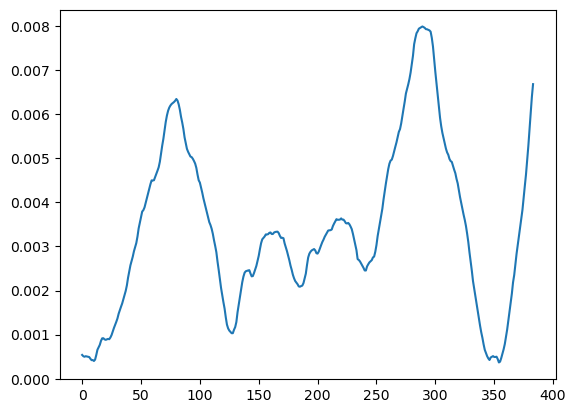

In [133]:
plt.plot(ne[1][:,0])

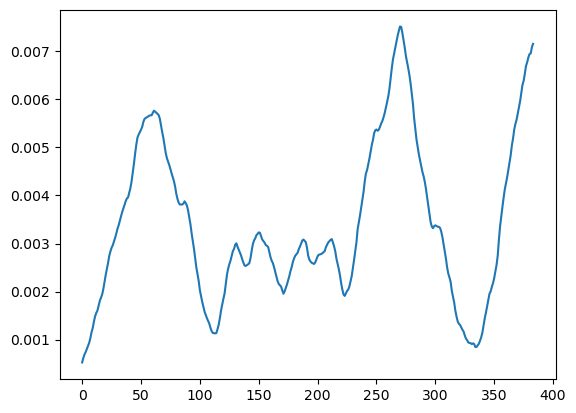

In [134]:
plt.plot(ne[1][:,1])

In [135]:
evl = model.evaluate(tfGenEval)
evl

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


     14/Unknown - 8s 368ms/step - loss: 2.4094e-04 - mae: 0.0114

14/14 [==============================] - 8s 379ms/step - loss: 2.4094e-04 - mae: 0.0114


[0.00024094288528431207, 0.011377334594726562]

In [136]:
p = model.predict(tfGenEval)
p *= 10.0
p.shape

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


     14/Unknown - 7s 335ms/step

14/14 [==============================] - 7s 344ms/step


(5376, 4)

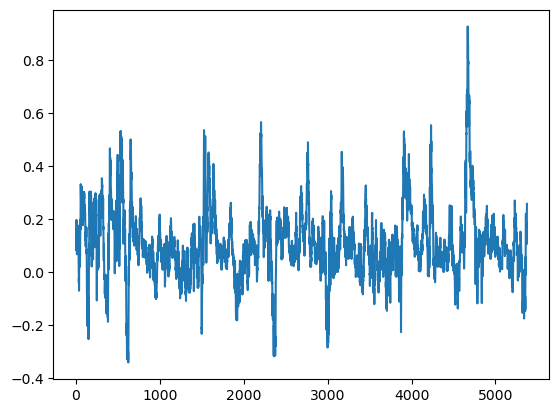

In [137]:
plt.plot(p[:,0])

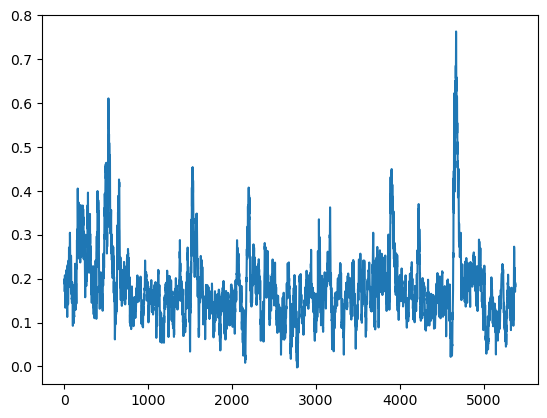

In [138]:
plt.plot(p[:,1])

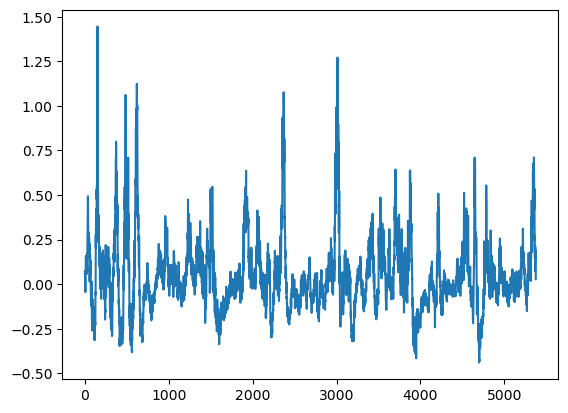

In [139]:
plt.plot(p[:,2])

In [140]:
p.shape

(5376, 4)

In [141]:
tickDF = pd.read_csv(TRAIN_FILES[1])
tickDF

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [142]:
tickDF.shape[0] - p.shape[0]

-55

In [143]:
tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
tickDFcropped

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [144]:
# p_dir = p[:,0]
# p_dir_derivation = p[:,1]

p_entry = p[:,3]
p_exit = p[:,2]
p_neutral = p[:,1]

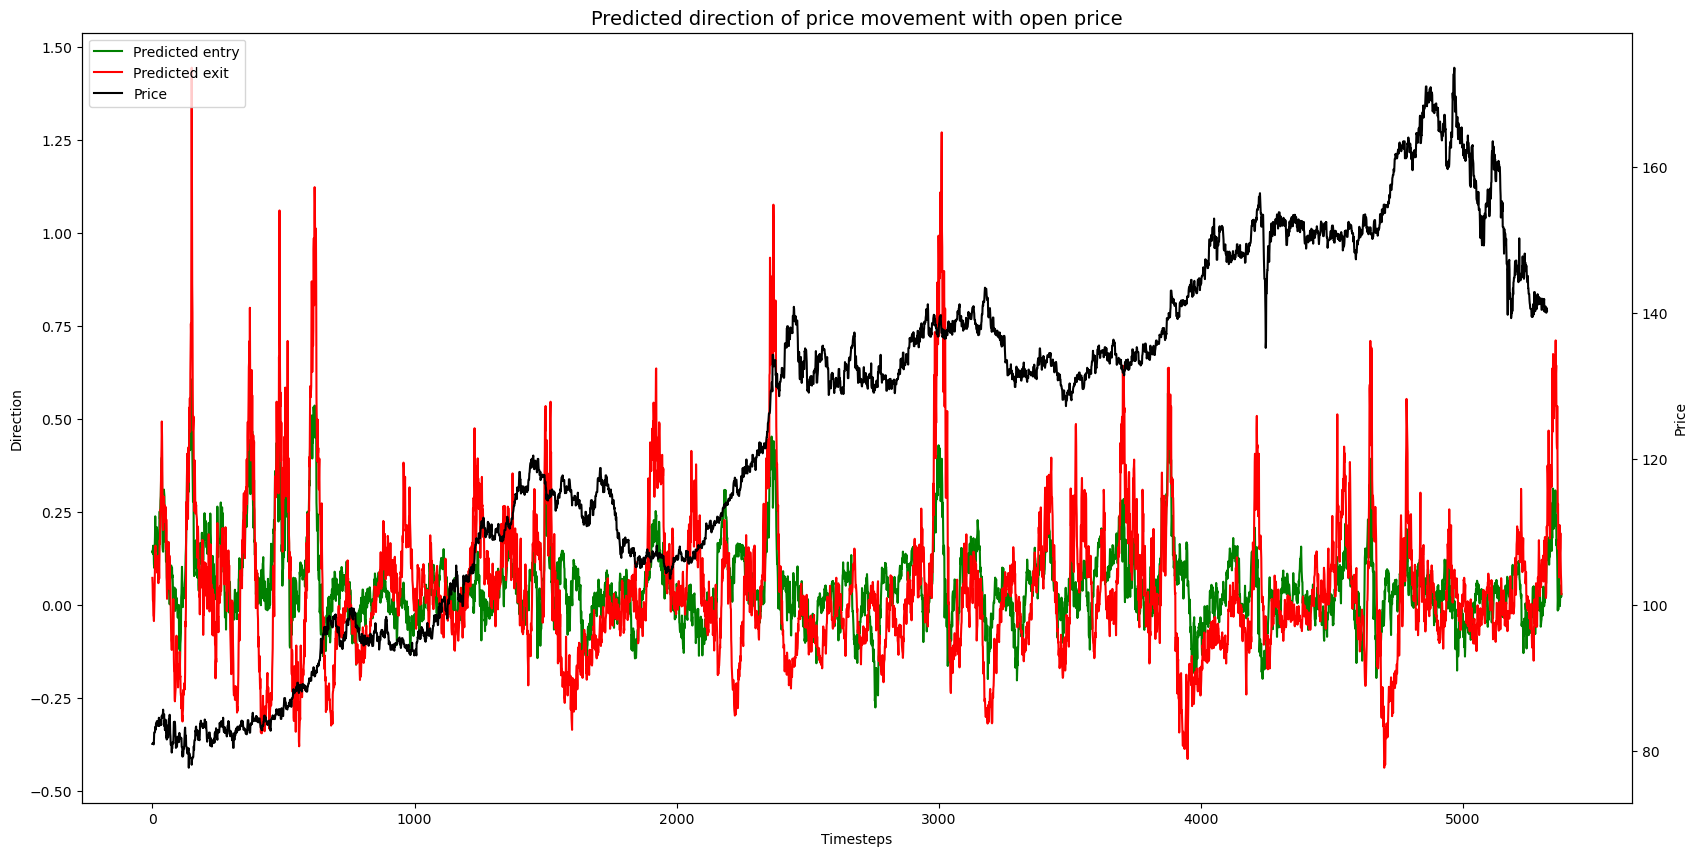

In [145]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_entry, color="green", label="Predicted entry")
_ = ax1.plot(p_exit, color="red", label="Predicted exit")
# _ = ax1.plot(p_neutral, color="gray", label="Predicted neutral")

ax2 = ax1.twinx()

ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [146]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

NameError: name 'p_past_gain' is not defined

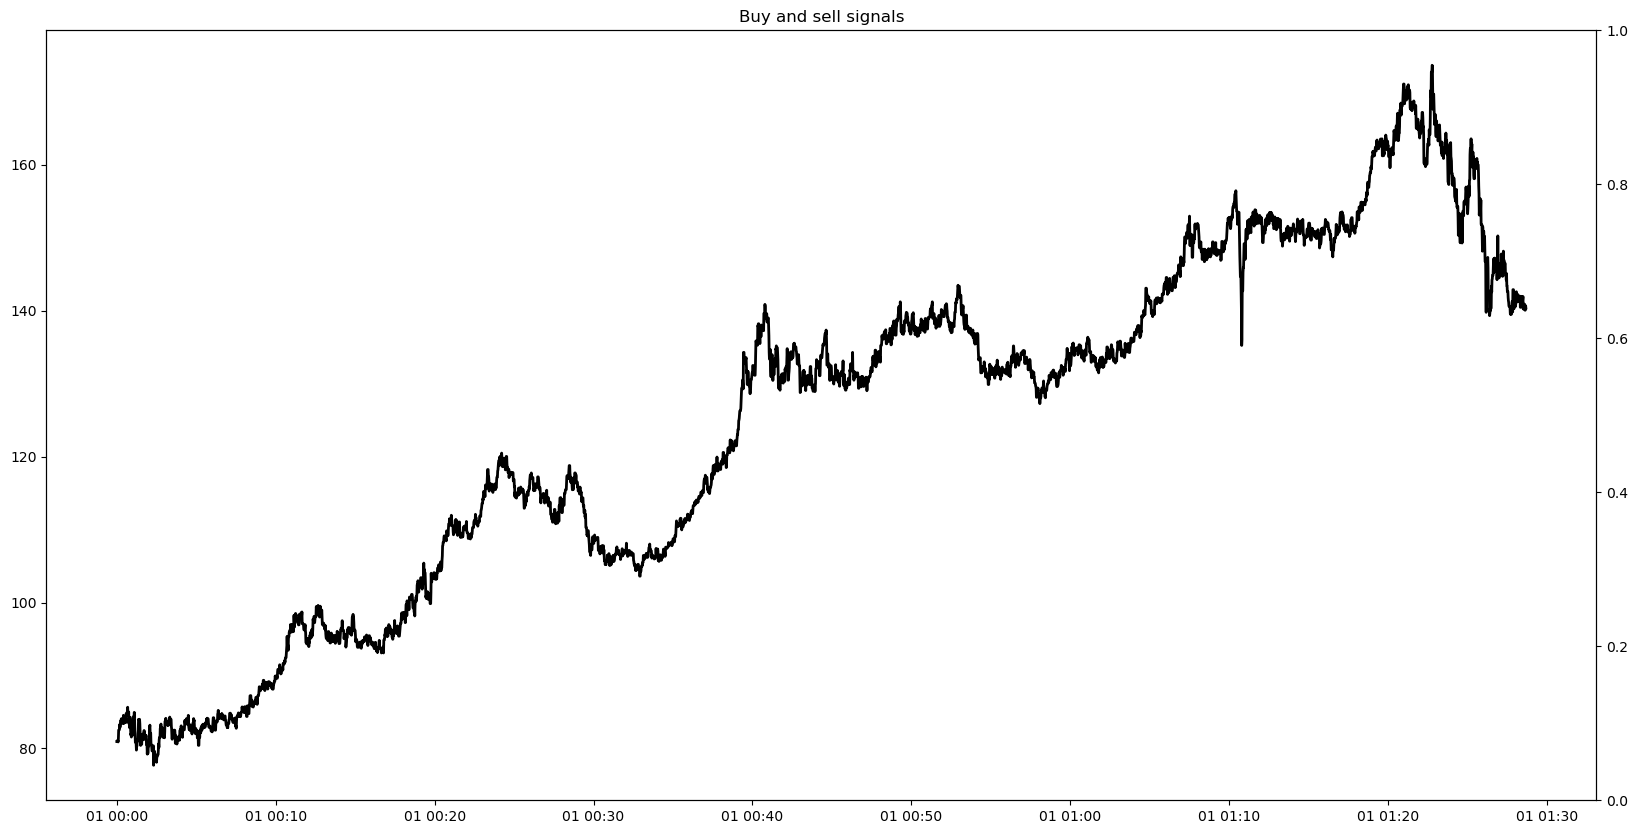

In [147]:
#@title Plot buy and sell signals
chart_name="Buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

_ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_past_gain >= SELL_SIGNAL_THRESHOLD_PAST
yCategoryRise = (p_future_gain > p_past_gain) & (p_past_gain <= BUY_SIGNAL_THRESHOLD_FUTURE) #(p_future_gain >= BUY_SIGNAL_THRESHOLD_FUTURE)

ax2.fill_between(x_datetimes, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes, p_future_gain, color="blue", label="Predicted future gain")
# _ = ax3.plot(x_datetimes, 10.0*p_dir_derivation, color="red", label="10.0 * Predicted price direction derivation")
# ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes), np.max(x_datetimes)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Add predictions to tick tables

In [ ]:
stop

In [ ]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [ ]:
# !mkdir /content/dataset/etffancy/PastFutureSignalsV6
# !mkdir /content/dataset/etffancy/PastFutureSignalsV6/test
# !mkdir /content/dataset/etffancy/PastFutureSignalsV6/eval

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

# fileList = EVAL_FILES
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/eval5"

fileList = TEST_FILES
PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test5"

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                           (BATCH_SIZE, 2)
                                                           )
                                                       )
        p = model.predict(tfGenEval, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_past_gain = p[:,0]
        p_future_gain = p[:,1]

        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]

        tickDFcropped.loc[:,"p_past_gain"] = p_past_gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain

        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))